## 1. 모듈 불러오기

In [33]:
# 필요한 모듈 불러오기
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
from selenium.webdriver.chrome.options import Options
from tqdm import tqdm

In [4]:
# 댓글 크롤링 함수
def crawl_comments(webtoon_url):
    # 드라이버 초기화 및 URL 접속
    driver = webdriver.Chrome()
    driver.get(webtoon_url)
    driver.maximize_window()

    comments_data = []  # 댓글을 저장할 리스트
    seen_comments = set()  # 중복 방지를 위한 셋

    try:
        # 지정된 URL로 이동
        driver.get(webtoon_url)
        time.sleep(3)  # 서버 부하를 줄이기 위해 대기

        print("Start crawling comments...")

        # "댓글 보기" 버튼 클릭
        try:
            view_comment_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, "a.u_cbox_btn_view_comment"))
            )
            view_comment_button.click()
            time.sleep(1)  # 댓글 영역이 열릴 때까지 대기
        except Exception as e:
            print("Error finding or clicking '댓글 보기' button:", e)

        while True:
            try:
                # 댓글 요소 찾기
                comment_elements = driver.find_elements(By.XPATH, "/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li/div[1]/div/div[2]/span[1]")
                new_comments_found = False

                for comment_element in comment_elements:
                    try:
                        # 댓글 텍스트 수집
                        comment_text = comment_element.text
                        if comment_text not in seen_comments:
                            comments_data.append(comment_text)
                            seen_comments.add(comment_text)
                            new_comments_found = True

                    except Exception as e:
                        print(f"Error extracting comment: {e}")

                print(f"Collected {len(comments_data)} comments so far.")

                # "더보기" 버튼 확인 및 클릭
                try:
                    more_button = WebDriverWait(driver, 5).until(
                        EC.element_to_be_clickable((By.XPATH, "/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[7]/a"))
                    )
                    more_button.click()
                    time.sleep(1)  # 다음 댓글 로드까지 대기
                except Exception:
                    print("No more '더보기' button. Ending comment collection.")
                    break

            except Exception as e:
                print(f"Error while processing comments: {e}")
                break

        # 댓글 데이터를 DataFrame에 저장
        df = pd.DataFrame(comments_data, columns=["Comment"])
        df.to_csv("comments_all.csv", index=False, encoding="utf-8-sig")
        print(f"Crawling completed. Total {len(comments_data)} comments saved to 'comments_all.csv'.")

    except Exception as e:
        print(f"Error during crawling: {e}")
    finally:
        driver.quit()

In [3]:
# 감정 분석 및 평가 함수
def sentiment_analysis():
    # 데이터 로드
    df = pd.read_csv("comments_all.csv")
    df['Comment'] = df['Comment'].astype(str)

    # Okt를 사용한 토큰화
    okt = Okt()
    df['Tokenized'] = df['Comment'].apply(okt.morphs)

    # 임의의 감정 레이블 추가 (예시)
    df['Sentiment'] = [1 if '좋다' in tokens or '재미있다' in tokens else 0 for tokens in df['Tokenized']]

    # 데이터 준비
    X = df['Comment']
    y = df['Sentiment']

    # 텍스트 벡터화
    vectorizer = CountVectorizer(tokenizer=lambda x: okt.morphs(x))
    X_vectorized = vectorizer.fit_transform(X)

    # 학습 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

    # 모델 학습
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # 예측
    pred = model.predict(X_test)

    # 평가 지표 계산
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))
    print("Classification Report:\n", classification_report(y_test, pred))
    print("Accuracy Score: ", accuracy_score(y_test, pred))

In [ ]:
# 크롤링 실행
if __name__ == "__main__":
    # 크롤링할 URL 설정
    webtoon_url = "https://comic.naver.com/webtoon/detail?titleId=738194&no=1&week=finish"
    crawl_comments(webtoon_url)

In [2]:
reviews = pd.read_csv('comments_all.csv')
reviews

Comment
0          윤성여씨에 이어 김신혜씨까지.. 이런일들이 진짜 현실에서 일어나고 있었다는게..
1                 몇년동안 감옥에서 청춘을 썩힌 사람한테 이제 어떻게 물어낼건데...
2                       와 김신혜 재심보고 진짜 이 만화는 레전드인걸 다시 느낌
3     김신혜 무죄 판결보고 다시왔습니다 에휴... 허위자백유도한 견찰들 싹다 토막나 죽어...
4            연재할 때 완결까지 달린 거의 유일한 웹툰임... 이거 왜 영화로 안 나옴?
...                                                 ...
1214                                                 이잉
1215                              오 신작 끌어올리자 개꿀잼 작가님 홧팀
1216                                    대작의 냄새가 난다 킁카킁카
1217                                          신작이네 올라가랏
1218                                           오 뭐야 신작?

[1219 rows x 1 columns]

In [ ]:
reviews['Comment']

In [4]:
# 이모지 제거
reviews['Comment'] = reviews['Comment'].apply(lambda x: x.encode('cp949', 'ignore').decode('cp949'))
reviews['Comment']

0            윤성여씨에 이어 김신혜씨까지.. 이런일들이 진짜 현실에서 일어나고 있었다는게..
1                   몇년동안 감옥에서 청춘을 썩힌 사람한테 이제 어떻게 물어낼건데...
2                         와 김신혜 재심보고 진짜 이 만화는 레전드인걸 다시 느낌
3       김신혜 무죄 판결보고 다시왔습니다 에휴... 허위자백유도한 견찰들 싹다 토막나 죽어...
4              연재할 때 완결까지 달린 거의 유일한 웹툰임... 이거 왜 영화로 안 나옴?
                              ...                        
1214                                                   이잉
1215                                오 신작 끌어올리자 개꿀잼 작가님 홧팀
1216                                      대작의 냄새가 난다 킁카킁카
1217                                            신작이네 올라가랏
1218                                             오 뭐야 신작?
Name: Comment, Length: 1219, dtype: object

In [ ]:
from konlpy.tag import Okt
import re

okt = Okt()   # Okt 불러오기
word_list = []
stopwords = ['']

for review in reviews['Comment'] :
    new_review = re.sub('[^0-9가-힣\\s+-]', '', review)
    temp = okt.pos(new_review)

    for word, pos in temp :
        if len(word) == 1 or word in stopwords :
            continue
        if pos == 'Noun' :
            word_list.append(word)

print(word_list)

In [9]:
len(word_list)

4470

In [11]:
from collections import Counter

counter = Counter(word_list)
mydict = dict(counter.most_common(20))
print(mydict)

{'작가': 212, '남녀': 184, '방백': 182, '진짜': 108, '주행': 80, '웹툰': 67, '보고': 66, '사람': 64, '작품': 60, '다시': 58, '명작': 57, '그림': 48, '주인공': 43, '인생': 39, '기대': 26, '이번': 25, '박카스': 25, '생각': 25, '시작': 23, '태호': 22}


In [42]:
from wordcloud import WordCloud
import os

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path = 'C:\Windows\Fonts\TmoneyRoundWindExtraBold.ttf'
).generate_from_frequencies(mydict)

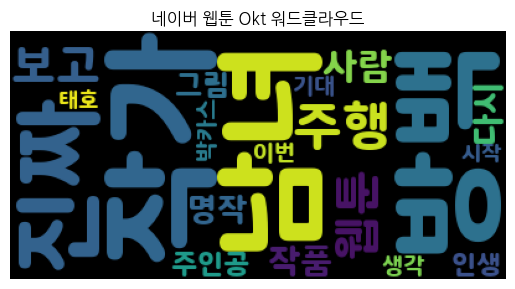

In [43]:
plt.imshow(wordcloud)
plt.title("네이버 웹툰 Okt 워드클라우드")
plt.axis("off")

output_dir = "graphs"
output_path = os.path.join(output_dir, "pos_wordcloud.png")
plt.savefig(output_path, dpi=300, facecolor=plt.gcf().get_facecolor())

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

# 마스크 이미지 가져오기
mask_img = np.array(Image.open("circle.png"))

# 특정 색상 정의
highlight_color = (236, 134, 18)  # rgb(236, 134, 18)
other_colors = [
    (144, 13, 130),  # rgb(144, 13, 130)
    (139, 138, 139), # rgb(139, 138, 139)
    (212, 205, 208),  # rgb(212, 205, 208)
    (94, 195, 177),
    (237, 148, 191)
]

# 강조할 단어 리스트
highlight_words = []

# 색상 함수 정의
def color_func(word, font_size, position, orientation, random_state = None, **kwargs):
    if word in highlight_words:
        return f'rgb({highlight_color[0]}, {highlight_color[1]}, {highlight_color[2]})'
    else:
        # 다른 색상 중 하나를 랜덤하게 선택
        other_color = other_colors[np.random.randint(0, len(other_colors))]
        return f'rgb({other_color[0]}, {other_color[1]}, {other_color[2]})'

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path="C:\Windows\Fonts\TmoneyRoundWindExtraBold.ttf",  # 폰트 경로
    mask=mask_img,
    background_color="white",
    color_func=color_func  # 사용자 정의 색상 함수
).generate_from_frequencies(mydict)

# 워드클라우드 시각화
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("네이버 웹툰 댓글 워드클라우드", fontsize=16)
plt.axis("off")  # 축 숨김
plt.show()

output_dir = "graphs"
output_path = os.path.join(output_dir, "circle_pos_wordcloud.png")
plt.savefig(output_path, dpi=300, facecolor=plt.gcf().get_facecolor())

In [ ]:
# 리스트 안에 문장별로 단어를 묶어주기 위해 sub_list 이용
okt = Okt()   # Okt 불러오기
p_word_list = []
stopwords = ['']

for review in reviews['Comment'] :
    new_review = re.sub('[^0-9가-힣\\s+-]', '', review)
    temp = okt.pos(new_review)
    sub_list = []

    for word, pos in temp :
        if len(word) == 1 or word in stopwords :
            continue
        if pos == 'Noun' :
            sub_list.append(word)
    word_list.append(sub_list)
print(word_list)

In [36]:
len(word_list)

5689

In [37]:
from apyori import apriori

# apriori 이용하여 장바구니 분석 진행
result = list(apriori(word_list))
data = pd.DataFrame(result)

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from konlpy.tag import Okt

# 데이터 로드
df = pd.read_csv("comments_all.csv")  # 크롤링한 댓글 데이터
df['Comment'] = df['Comment'].astype(str)  # 데이터 타입 확인

# 토큰화
okt = Okt()
df['Tokenized'] = df['Comment'].apply(okt.morphs)

# 감정 레이블 추가 (샘플 데이터 생성 - 실제로는 라벨링 필요)
# 1: 긍정, 0: 부정
df['Sentiment'] = [1 if '좋다' in tokens or '재미있다' in tokens else 0 for tokens in df['Tokenized']]

# 데이터 준비
X = df['Comment']
y = df['Sentiment']

# 텍스트 벡터화
vectorizer = CountVectorizer(tokenizer = lambda x: okt.morphs(x))
X_vectorized = vectorizer.fit_transform(X)

# 학습 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# 모델 학습
model = MultinomialNB()
model.fit(X_train, y_train)

# 테스트
pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print(f"모델 정확도: {accuracy * 100:.2f}%")
print('#Test set score: {:.3f}'.format(accuracy_score(y_test,pred))) #test set에 대한 예측정확도를 확인

# 새로운 댓글 감정분석
new_comments = ["싫어요", "최고"]
new_vectorized = vectorizer.transform(new_comments)
predictions = model.predict(new_vectorized)

for comment, sentiment in zip(new_comments, predictions):
    print(f"'{comment}' => {'긍정' if sentiment == 1 else '부정'}")


c:\Code\ML\env311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


모델 정확도: 98.77%
#Test set score: 0.988
'싫어요' => 부정
'최고' => 부정


In [60]:
sentiment_analysis()

c:\Code\ML\env311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Confusion Matrix:
 [[241   3]
 [  0   0]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       244
           1       0.00      0.00      0.00         0

    accuracy                           0.99       244
   macro avg       0.50      0.49      0.50       244
weighted avg       1.00      0.99      0.99       244

Accuracy Score:  0.9877049180327869


c:\Code\ML\env311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Code\ML\env311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Code\ML\env311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 2. 연재중 웹툰 데이터 크롤링

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
from tqdm import tqdm
from selenium.webdriver.chrome.options import Options

# 웹 드라이버로 링크 열기 함수
def open_webtoon_page(webtoon_url):
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # Headless 모드 활성화
    chrome_options.add_argument("--disable-gpu")
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(webtoon_url)
    return driver

def wait_for_element(driver, xpath, timeout=10):
    try:
        element = WebDriverWait(driver, timeout).until(
            EC.presence_of_element_located((By.XPATH, xpath))
        )
        return element
    except Exception as e:
        print(f"Timeout waiting for element: {xpath}")
        return None

def extract_best_comments(driver, webtoon_name, episode_idx, all_data):
    try:
        best_comment_elements = driver.find_elements(By.XPATH, "/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li")

        for idx, comment_element in enumerate(best_comment_elements):
            try:
                # 댓글 텍스트
                comment_text = comment_element.find_element(By.XPATH, f"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[{idx + 1}]/div[1]/div/div[2]/span[2]").text

                # 추천수
                likes = comment_element.find_element(By.XPATH, f"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[{idx + 1}]/div[1]/div/div[4]/div/a[1]/em").text

                # 비추천수
                dislikes = comment_element.find_element(By.XPATH, f"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[{idx + 1}]/div[1]/div/div[4]/div/a[2]/em").text

                # 데이터 저장
                all_data["웹툰 이름"].append(webtoon_name)
                all_data["화수"].append(f"{episode_idx}화")
                all_data["Comment"].append(comment_text)
                all_data["Likes"].append(int(likes.replace(",", "")))
                all_data["Dislikes"].append(int(dislikes.replace(",", "")))
            except Exception as e:
                print(f"Error extracting best comment at index {idx + 1}: {e}")

    except Exception as e:
        print(f"Error finding best comments: {e}")

def crawl_episode_comments(webtoon_name, webtoon_url, episode_idx, all_data):
    episode_url = f"{webtoon_url}&no={episode_idx}"
    print(f"Crawling {webtoon_name} Episode {episode_idx}: {episode_url}")

    driver = open_webtoon_page(episode_url)

    try:
        extract_best_comments(driver, webtoon_name, episode_idx, all_data)
    except Exception as e:
        print(f"Error during crawling episode {episode_idx}: {e}")
    finally:
        driver.quit()

def crawl_best_comments(finish_webtoon):
    all_data = {
        "웹툰 이름": [],
        "화수": [],
        "Comment": [],
        "Likes": [],
        "Dislikes": []
    }

    for idx, row in finish_webtoon.iterrows():
        webtoon_name = row["웹툰 이름"]
        webtoon_url = row["웹툰 링크"]

        for episode_idx in range(1, 6):  # 1화부터 5화까지 크롤링
            crawl_episode_comments(webtoon_name, webtoon_url, episode_idx, all_data)

    # 데이터를 DataFrame으로 저장
    df = pd.DataFrame(all_data)
    df.to_csv("best_comments_with_episodes.csv", index=False, encoding="utf-8-sig")
    print("Crawling completed. Data saved to 'best_comments_with_episodes.csv'.")

# 1화 정렬 버튼 클릭 함수
def click_sort_button(driver):
    try:
        # 첫 번째 위치에서 버튼 찾기
        sort_button = wait_for_element(driver, "/html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]")
        if not sort_button:
            # 두 번째 위치에서 버튼 찾기
            sort_button = wait_for_element(driver, "/html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[1]/div[2]/button[2]")

        if sort_button:
            sort_button.click()
            time.sleep(2)  # 정렬 후 로딩 대기
            return True
        return False
    except Exception as e:
        print(f"Error clicking sort button: {e}")
        return False

# 특정 화 클릭 함수
def click_episode(driver, episode_idx):
    try:
        episode_xpath = f"/html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[{episode_idx}]/a"
        episode_element = wait_for_element(driver, episode_xpath)
        if episode_element:
            episode_element.click()
            time.sleep(2)  # 페이지 로드 대기
            return True
        return False
    except Exception as e:
        print(f"Error clicking episode {episode_idx}: {e}")
        return False

# 좋아요 수 크롤링 함수
def crawl_likes(driver):
    try:
        element = wait_for_element(driver, "/html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]")
        return element.text if element else None
    except Exception as e:
        print(f"Error collecting likes: {e}")
        return None

# 별점주기 참여수 크롤링 함수
def crawl_rating_participants(driver):
    try:
        element = wait_for_element(driver, "/html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]")
        return element.text if element else None
    except Exception as e:
        print(f"Error collecting rating participants: {e}")
        return None

# 댓글 수 크롤링 함수
def crawl_comments_count(driver):
    try:
        # 첫 번째 경로 확인
        element = wait_for_element(driver, "/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span")
        if element:
            return element.text
        
        # 두 번째 경로 확인
        element = wait_for_element(driver, "/html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span")
        if element:
            return element.text

        # 댓글 수를 찾지 못한 경우
        print("Comments count element not found in both paths.")
        return None
    except Exception as e:
        print(f"Error collecting comments count: {e}")
        return None

# 데이터 크롤링 함수
def crawl_webtoon_data(driver):
    return {
        "Likes": crawl_likes(driver),
        "Rating Participants": crawl_rating_participants(driver),
        "Comments Count": crawl_comments_count(driver),
    }

# 완결 웹툰 여부 확인 함수
def is_finished_webtoon(url):
    return "week=finish" in url

In [13]:
webtoon = pd.read_csv('연재중_웹툰데이터_.csv')
webtoon.head()

웹툰 이름  웹툰 별점                                              웹툰 링크  \
0             참교육   9.89  https://comic.naver.com/webtoon/list?titleId=7...   
1            환생천마   9.95  https://comic.naver.com/webtoon/list?titleId=8...   
2          똑 닮은 딸   9.98  https://comic.naver.com/webtoon/list?titleId=7...   
3            신의 탑   9.84  https://comic.naver.com/webtoon/list?titleId=1...   
4  어느날 갑자기 가슴이 커짐   9.81  https://comic.naver.com/webtoon/list?titleId=8...   

  연재 요일     장르     웹툰 관심수  요일별 순위  
0   mon     액션    952,557       1  
1   mon  무협/사극    153,632       2  
2   mon    스릴러    673,334       3  
3   mon    판타지  1,909,208       4  
4   mon     일상     70,824       5

In [4]:
webtoon[['웹툰 이름', '웹툰 링크']]

웹툰 이름                                              웹툰 링크
0                      참교육  https://comic.naver.com/webtoon/list?titleId=7...
1                     환생천마  https://comic.naver.com/webtoon/list?titleId=8...
2                   똑 닮은 딸  https://comic.naver.com/webtoon/list?titleId=7...
3                     신의 탑  https://comic.naver.com/webtoon/list?titleId=1...
4           어느날 갑자기 가슴이 커짐  https://comic.naver.com/webtoon/list?titleId=8...
..                     ...                                                ...
689  밤필드의 아이들 by DARK MOON  https://comic.naver.com/webtoon/list?titleId=8...
690             노래 못 하는 남자  https://comic.naver.com/webtoon/list?titleId=8...
691      마섹남 - 마술하는 섹시한 남자  https://comic.naver.com/webtoon/list?titleId=7...
692           주인공의 주식을 팝니다  https://comic.naver.com/webtoon/list?titleId=8...
693                  프린키피아  https://comic.naver.com/webtoon/list?titleId=8...

[694 rows x 2 columns]

In [5]:
webtoon['웹툰 링크'][1]

'https://comic.naver.com/webtoon/list?titleId=822657&tab=mon'

In [14]:
# 성인 웹툰 제외한 개수 계산
valid_webtoons = webtoon[~webtoon["웹툰 관심수"].str.contains("성인")]

In [ ]:
all_data = {
    "웹툰 이름": [],
    "웹툰 링크": [],
    "화수": [],
    "Likes": [],
    "Rating Participants": [],
    "Comments Count": []
}

error_log = {
    "웹툰 이름": [],
    "웹툰 링크": []
}

for idx, row in tqdm(valid_webtoons.iterrows(), total=len(valid_webtoons), desc="Processing Webtoons"):
    webtoon_list_url = row["웹툰 링크"]
    driver = open_webtoon_page(webtoon_list_url)

    try:
        if not is_finished_webtoon(webtoon_list_url):
            if not click_sort_button(driver):
                continue

        for episode_idx in range(1, 6):  # 1화부터 5화까지 클릭
            if not click_episode(driver, episode_idx):
                continue

            episode_data = crawl_webtoon_data(driver)

            all_data["웹툰 이름"].append(row["웹툰 이름"])
            all_data["웹툰 링크"].append(driver.current_url)
            all_data["화수"].append(f"{episode_idx}화")
            all_data["Likes"].append(episode_data["Likes"])
            all_data["Rating Participants"].append(episode_data["Rating Participants"])
            all_data["Comments Count"].append(episode_data["Comments Count"])

            driver.back()
            time.sleep(2)  # 페이지 로드 대기

    except Exception as e:
        print(f"Error processing webtoon: {e}")
        error_log["웹툰 이름"].append(row["웹툰 이름"])
        error_log["웹툰 링크"].append(webtoon_list_url)
    finally:
        driver.quit()

# 데이터를 데이터프레임으로 저장
result_df = pd.DataFrame(all_data)
result_df.to_csv("webtoon_data.csv", index=False, encoding="utf-8-sig")

error_df = pd.DataFrame(error_log)
error_df.to_csv("webtoon_error_log.csv", index=False, encoding="utf-8-sig")

print(f"Crawling completed. Data saved to 'webtoon_data.csv'.")
print(f"Error log saved to 'webtoon_error_log.csv'.")

In [2]:
existing_data = pd.read_csv('webtoon_data.csv')
existing_data

웹툰 이름                                              웹툰 링크  화수   Likes  \
0       참교육  https://comic.naver.com/webtoon/detail?titleId...  1화  68,157   
1       참교육  https://comic.naver.com/webtoon/detail?titleId...  2화  49,622   
2       참교육  https://comic.naver.com/webtoon/detail?titleId...  3화  47,958   
3       참교육  https://comic.naver.com/webtoon/detail?titleId...  4화  46,823   
4       참교육  https://comic.naver.com/webtoon/detail?titleId...  5화  44,767   
...     ...                                                ...  ..     ...   
3205  프린키피아  https://comic.naver.com/webtoon/detail?titleId...  1화   3,737   
3206  프린키피아  https://comic.naver.com/webtoon/detail?titleId...  2화   1,819   
3207  프린키피아  https://comic.naver.com/webtoon/detail?titleId...  3화   1,464   
3208  프린키피아  https://comic.naver.com/webtoon/detail?titleId...  4화   1,228   
3209  프린키피아  https://comic.naver.com/webtoon/detail?titleId...  5화   1,212   

     Rating Participants Comments Count  
0              58,494 참여          7,824  
1              43,173 참여          3,032  
2              48,409 참여          3,919  
3              43,973 참여          3,622  
4              38,629 참여          4,020  
...                  ...            ...  
3205            3,563 참여            435  
3206            1,823 참여             85  
3207            1,535 참여             53  
3208            1,280 참여             49  
3209            1,235 참여             58  

[3210 rows x 6 columns]

In [6]:
# Assuming `data` and `valid_webtoons` DataFrames are defined
crawl_webtoon = list(existing_data['웹툰 이름'].unique())  # Unique successfully crawled webtoons
valid = list(valid_webtoons['웹툰 이름'])        # Unique expected webtoons to crawl

# Finding webtoons in `valid` but not in `crawl_webtoon`
missing_webtoons = [webtoon for webtoon in valid if webtoon not in crawl_webtoon]

# Print the missing webtoons
print("Missing Webtoons:", missing_webtoons)


Missing Webtoons: ['별난식당', '요리사가 되고 싶은 천마님', '하루만 네가 되고 싶어', '신과함께 돌아온 기사왕님', '사리네 보석함', '마른 가지에 바람처럼', '잠겨죽어도', '사형집행관', '시한부 천재 암흑기사', '도깨비의 밤', '사냥개의 회귀본능', '몽홀', '악당을 업어 키웠더니', '용사참수인', '전생연분', '멸망으로 시작하는! 근미래 생존법', '망돌의 사생', '아임 파인 땡큐, 앤유?', '홍 의관의 은밀한 비밀', '성애적 순애보', '마섹남 - 마술하는 섹시한 남자']


In [20]:
# Assuming `valid_webtoons` contains '웹툰 이름' and '웹툰 링크'
missing_webtoons_df = valid_webtoons[valid_webtoons['웹툰 이름'].isin(missing_webtoons)]

# Display the DataFrame of missing webtoons
print(missing_webtoons_df)

                  웹툰 이름  웹툰 별점  \
22                 별난식당   9.96   
62       요리사가 되고 싶은 천마님   9.86   
131        하루만 네가 되고 싶어   9.95   
132       신과함께 돌아온 기사왕님   7.85   
170             사리네 보석함   9.91   
246         마른 가지에 바람처럼   9.97   
271               잠겨죽어도   9.95   
327               사형집행관   9.87   
331         시한부 천재 암흑기사   9.80   
444              도깨비의 밤   9.95   
465           사냥개의 회귀본능   9.59   
470                  몽홀   9.90   
482         악당을 업어 키웠더니   9.97   
559               용사참수인   9.92   
569                전생연분   9.97   
595  멸망으로 시작하는! 근미래 생존법   9.87   
658              망돌의 사생   9.89   
664       아임 파인 땡큐, 앤유?   9.86   
667        홍 의관의 은밀한 비밀   9.97   
678             성애적 순애보   9.83   
691   마섹남 - 마술하는 섹시한 남자   9.89   

                                                 웹툰 링크 연재 요일     장르   웹툰 관심수  \
22   https://comic.naver.com/webtoon/list?titleId=8...   mon    드라마  149,076   
62   https://comic.naver.com/webtoon/list?titleId=8...   mon    판타지   24,798   
131  https:

In [21]:
# 기존 데이터에서 화수가 5개 미만인 웹툰 찾기
incomplete_webtoons = existing_data["웹툰 이름"].value_counts()[existing_data["웹툰 이름"].value_counts() < 5].index

# missing_webtoons_df에 병합하기
incomplete_webtoons_df = valid_webtoons[valid_webtoons["웹툰 이름"].isin(incomplete_webtoons)]
missing_webtoons_df = pd.concat([missing_webtoons_df, incomplete_webtoons_df]).drop_duplicates()
missing_webtoons_df 

웹툰 이름  웹툰 별점  \
22                 별난식당   9.96   
62       요리사가 되고 싶은 천마님   9.86   
131        하루만 네가 되고 싶어   9.95   
132       신과함께 돌아온 기사왕님   7.85   
170             사리네 보석함   9.91   
246         마른 가지에 바람처럼   9.97   
271               잠겨죽어도   9.95   
327               사형집행관   9.87   
331         시한부 천재 암흑기사   9.80   
444              도깨비의 밤   9.95   
465           사냥개의 회귀본능   9.59   
470                  몽홀   9.90   
482         악당을 업어 키웠더니   9.97   
559               용사참수인   9.92   
569                전생연분   9.97   
595  멸망으로 시작하는! 근미래 생존법   9.87   
658              망돌의 사생   9.89   
664       아임 파인 땡큐, 앤유?   9.86   
667        홍 의관의 은밀한 비밀   9.97   
678             성애적 순애보   9.83   
691   마섹남 - 마술하는 섹시한 남자   9.89   
33                 연애리뷰   9.89   
166           선 넘는 결혼생활   9.80   
192         천재, 만재, 백재!   9.95   
273                동반입대   9.78   
278     천재는 평범하게 살기로 했더   9.92   
326   송이연 50살, 이혼 한 달 차   9.87   
366                노키즈존   9.90   
411                  업셋   9.36   
412         지구대장님의 학교생활   9.21   
426                천중용문   9.80   
544           너의 달콤한 숨을   9.90   
550                  명왕   9.14   
637     축구천재로 오해받는 중입니다   9.86   
665         빙의자 베네핏이 없음   9.78   

                                                 웹툰 링크 연재 요일     장르   웹툰 관심수  \
22   https://comic.naver.com/webtoon/list?titleId=8...   mon    드라마  149,076   
62   https://comic.naver.com/webtoon/list?titleId=8...   mon    판타지   24,798   
131  https://comic.naver.com/webtoon/list?titleId=7...   tue    로맨스  692,931   
132  https://comic.naver.com/webtoon/list?titleId=8...   tue    판타지  107,719   
170  https://comic.naver.com/webtoon/list?titleId=8...   tue     일상   41,937   
246  https://comic.naver.com/webtoon/list?titleId=7...   wed    로맨스  459,821   
271  https://comic.naver.com/webtoon/list?titleId=8...   wed    스릴러   86,758   
327  https://comic.naver.com/webtoon/list?titleId=8...   thu     액션  193,292   
331  https://comic.naver.com/webtoon/list?titleId=8...   thu    판타지  155,544   
444  https://comic.naver.com/webtoon/list?titleId=8...   fri     액션  152,955   
465  https://comic.naver.com/webtoon/list?titleId=8...   fri    판타지   41,833   
470  https://comic.naver.com/webtoon/list?titleId=6...   fri  무협/사극   95,754   
482  https://comic.naver.com/webtoon/list?titleId=8...   fri    로맨스   41,670   
559  https://comic.naver.com/webtoon/list?titleId=7...   sat    판타지   69,463   
569  https://comic.naver.com/webtoon/list?titleId=7...   sat    로맨스  247,748   
595  https://comic.naver.com/webtoon/list?titleId=8...   sat    판타지   20,309   
658  https://comic.naver.com/webtoon/list?titleId=8...   sun    스릴러   33,591   
664  https://comic.naver.com/webtoon/list?titleId=8...   sun    로맨스   71,520   
667  https://comic.naver.com/webtoon/list?titleId=7...   sun    로맨스   81,142   
678  https://comic.naver.com/webtoon/list?titleId=8...   sun    로맨스   50,299   
691  https://comic.naver.com/webtoon/list?titleId=7...   sun    로맨스   54,426   
33   https://comic.naver.com/webtoon/list?titleId=8...   mon    로맨스   48,868   
166  https://comic.naver.com/webtoon/list?titleId=8...   tue    로맨스   13,938   
192  https://comic.naver.com/webtoon/list?titleId=8...   tue    드라마    5,177   
273  https://comic.naver.com/webtoon/list?titleId=8...   wed    드라마    1,613   
278  https://comic.naver.com/webtoon/list?titleId=8...   wed    드라마   17,269   
326  https://comic.naver.com/webtoon/list?titleId=8...   thu    드라마   23,643   
366  https://comic.naver.com/webtoon/list?titleId=8...   thu    판타지    5,165   
411  https://comic.naver.com/webtoon/list?titleId=8...   thu    스포츠    2,876   
412  https://comic.naver.com/webtoon/list?titleId=8...   thu     액션    2,768   
426  https://comic.naver.com/webtoon/list?titleId=8...   fri  무협/사극   29,854   
544  https://comic.naver.com/webtoon/list?titleId=8...   sat    판타지   25,772   
550  https://comic.naver.com/webtoon/list?titleId=8...   sat     액션    8,440   
637  https://comic.naver.com/webtoon/list?titleId=8...   sun    스포츠   26,

In [42]:
print(missing_webtoons_df['웹툰 링크'][33])


https://comic.naver.com/webtoon/list?titleId=835082&tab=mon


In [43]:
missing_webtoons_df.to_csv("missing_webtoons.csv", index=False, encoding="utf-8-sig")

In [54]:
all_data = {
    "웹툰 이름": [],
    "웹툰 링크": [],
    "화수": [],
    "Likes": [],
    "Rating Participants": [],
    "Comments Count": []
}

error_log = {
    "웹툰 이름": [],
    "웹툰 링크": []
}

for idx, row in tqdm(missing_webtoons_df.iterrows(), total=len(missing_webtoons_df), desc="Processing Missing Webtoons"):
    webtoon_list_url = row["웹툰 링크"]
    driver = open_webtoon_page(webtoon_list_url)

    try:
        if not is_finished_webtoon(webtoon_list_url):
            if not click_sort_button(driver):
                continue

        for episode_idx in range(1, 6):  # 1화부터 5화까지 클릭
            if not click_episode(driver, episode_idx):
                continue

            episode_data = crawl_webtoon_data(driver)

            all_data["웹툰 이름"].append(row["웹툰 이름"])
            all_data["웹툰 링크"].append(driver.current_url)
            all_data["화수"].append(f"{episode_idx}화")
            all_data["Likes"].append(episode_data["Likes"])
            all_data["Rating Participants"].append(episode_data["Rating Participants"])
            all_data["Comments Count"].append(episode_data["Comments Count"])

            driver.back()
            time.sleep(2)  # 페이지 로드 대기

    except Exception as e:
        print(f"Error processing webtoon: {e}")
        error_log["웹툰 이름"].append(row["웹툰 이름"])
        error_log["웹툰 링크"].append(webtoon_list_url)
    finally:
        driver.quit()

# 크롤링된 데이터 기존 데이터에 추가
new_data_df = pd.DataFrame(all_data)

new_data_df.to_csv("updated_webtoon.csv", index=False, encoding="utf-8-sig")

# 에러 로그 저장
error_df = pd.DataFrame(error_log)
error_df.to_csv("webtoon_error_log.csv", index=False, encoding="utf-8-sig")


Processing Missing Webtoons:  31%|███▏      | 11/35 [12:29<28:22, 70.95s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]


Processing Missing Webtoons:  57%|█████▋    | 20/35 [20:01<11:45, 47.07s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]


Processing Missing Webtoons:  60%|██████    | 21/35 [20:51<11:10, 47.90s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span
Comments count element not found in both paths.
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[4]/a
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[5]/a


Processing Missing Webtoons:  63%|██████▎   | 22/35 [23:53<19:07, 88.27s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span
Comments count element not found in both paths.
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[5]/a


Processing Missing Webtoons:  66%|██████▌   | 23/35 [25:37<18:36, 93.02s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span
Comments count element not found in both paths.
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[4]/a
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[5]/a


Processing Missing Webtoons:  69%|██████▊   | 24/35 [27:25<17:50, 97.28s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span
Comments count element not found in both paths.
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[3]/a
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[4]/a
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[5]/a


Processing Missing Webtoons:  71%|███████▏  | 25/35 [29:17<16:56, 101.69s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span
Comments count element not found in both paths.
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[5]/a


Processing Missing Webtoons:  74%|███████▍  | 26/35 [31:03<15:27, 103.07s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span
Comments count element not found in both paths.
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[5]/a


Processing Missing Webtoons:  77%|███████▋  | 27/35 [32:44<13:39, 102.45s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span
Comments count element not found in both paths.
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[5]/a


Processing Missing Webtoons:  80%|████████  | 28/35 [34:39<12:24, 106.31s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span
Comments count element not found in both paths.
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[4]/a
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[5]/a


Processing Missing Webtoons:  83%|████████▎ | 29/35 [36:34<10:52, 108.76s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span
Comments count element not found in both paths.
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[4]/a
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[5]/a


Processing Missing Webtoons:  86%|████████▌ | 30/35 [38:28<09:11, 110.39s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span
Comments count element not found in both paths.
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[5]/a


Processing Missing Webtoons:  89%|████████▊ | 31/35 [40:34<07:40, 115.12s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span
Comments count element not found in both paths.
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[5]/a


Processing Missing Webtoons:  91%|█████████▏| 32/35 [42:23<05:39, 113.21s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span
Comments count element not found in both paths.
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[5]/a


Processing Missing Webtoons:  94%|█████████▍| 33/35 [44:20<03:48, 114.38s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span
Comments count element not found in both paths.
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[5]/a


Processing Missing Webtoons:  97%|█████████▋| 34/35 [46:08<01:52, 112.59s/it]

Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/div/div/a/em[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[1]/div[1]/button[2]/span[2]
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[1]/span
Timeout waiting for element: /html/body/div[1]/div[5]/div/div/div[5]/div[1]/div[3]/div/div/div[1]/span
Comments count element not found in both paths.
Timeout waiting for element: /html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[5]/a


Processing Missing Webtoons: 100%|██████████| 35/35 [48:13<00:00, 82.67s/it] 


In [3]:
existing_data = pd.read_csv('webtoon_data.csv')
existing_data[existing_data['웹툰 이름'] == '연애리뷰']

index 웹툰 이름                                              웹툰 링크  화수  \
143     143  연애리뷰  https://comic.naver.com/webtoon/detail?titleId...  1화   
3261   3367  연애리뷰  https://comic.naver.com/webtoon/detail?titleId...  2화   

      Likes Rating Participants Comments Count  
143   3,383            2,647 참여            401  
3261  2,257            1,705 참여            190

In [41]:
existing_data

웹툰 이름                                              웹툰 링크  \
0                   참교육  https://comic.naver.com/webtoon/detail?titleId...   
1                   참교육  https://comic.naver.com/webtoon/detail?titleId...   
2                   참교육  https://comic.naver.com/webtoon/detail?titleId...   
3                   참교육  https://comic.naver.com/webtoon/detail?titleId...   
4                   참교육  https://comic.naver.com/webtoon/detail?titleId...   
...                 ...                                                ...   
3256  마섹남 - 마술하는 섹시한 남자  https://comic.naver.com/webtoon/detail?titleId...   
3257  마섹남 - 마술하는 섹시한 남자  https://comic.naver.com/webtoon/detail?titleId...   
3258  마섹남 - 마술하는 섹시한 남자  https://comic.naver.com/webtoon/detail?titleId...   
3259  마섹남 - 마술하는 섹시한 남자  https://comic.naver.com/webtoon/detail?titleId...   
3260  마섹남 - 마술하는 섹시한 남자  https://comic.naver.com/webtoon/detail?titleId...   

      화수   Likes Rating Participants Comments Count  
0     1화  68,157           58,494 참여          7,824  
1     2화  49,622           43,173 참여          3,032  
2     3화  47,958           48,409 참여          3,919  
3     4화  46,823           43,973 참여          3,622  
4     5화  44,767           38,629 참여          4,020  
...   ..     ...                 ...            ...  
3256  1화   5,888            4,878 참여            457  
3257  2화   4,841            4,008 참여            293  
3258  3화   4,066            3,284 참여            168  
3259  4화   3,700            3,037 참여            196  
3260  5화   3,156            2,638 참여            143  

[3261 rows x 6 columns]

In [4]:
update_data = pd.read_csv('updated_webtoon.csv')

# 결측치 확인
print(update_data.isna().sum())

# 결측치가 있는 행 제거
update_data = update_data.dropna()

print(update_data.isna().sum())

웹툰 이름                   0
웹툰 링크                   0
화수                      0
Likes                  14
Rating Participants    14
Comments Count         14
dtype: int64
웹툰 이름                  0
웹툰 링크                  0
화수                     0
Likes                  0
Rating Participants    0
Comments Count         0
dtype: int64


In [7]:
updated_data = pd.read_csv('webtoon_data.csv')
updated_data

index            웹툰 이름  \
0         0              참교육   
1         1              참교육   
2         2              참교육   
3         3              참교육   
4         4              참교육   
...     ...              ...   
3270   3398             천중용문   
3271   3402        너의 달콤한 숨을   
3272   3406               명왕   
3273   3410  축구천재로 오해받는 중입니다   
3274   3414      빙의자 베네핏이 없음   

                                                  웹툰 링크  화수   Likes  \
0     https://comic.naver.com/webtoon/detail?titleId...  1화  68,157   
1     https://comic.naver.com/webtoon/detail?titleId...  2화  49,622   
2     https://comic.naver.com/webtoon/detail?titleId...  3화  47,958   
3     https://comic.naver.com/webtoon/detail?titleId...  4화  46,823   
4     https://comic.naver.com/webtoon/detail?titleId...  5화  44,767   
...                                                 ...  ..     ...   
3270  https://comic.naver.com/webtoon/detail?titleId...  3화     972   
3271  https://comic.naver.com/webtoon/detail?titleId...  3화     500   
3272  https://comic.naver.com/webtoon/detail?titleId...  3화     209   
3273  https://comic.naver.com/webtoon/detail?titleId...  3화     611   
3274  https://comic.naver.com/webtoon/detail?titleId...  3화     355   

     Rating Participants Comments Count  
0              58,494 참여          7,824  
1              43,173 참여          3,032  
2              48,409 참여          3,919  
3              43,973 참여          3,622  
4              38,629 참여          4,020  
...                  ...            ...  
3270            1,436 참여            105  
3271              547 참여             55  
3272              233 참여             30  
3273              569 참여             65  
3274              299 참여             52  

[3275 rows x 7 columns]

In [ ]:
# # 기존 데이터와 누락된 데이터 병합
# updated_data = pd.concat([existing_data, new_data_df], ignore_index=True)
# updated_data

In [ ]:
updated_data.isna().sum()

In [31]:
# 결측치가 있는 행 제거
updated_data = updated_data.dropna()

# 기존 데이터에서 중복된 행 제거
# 중복 기준은 '웹툰 이름', '화수' 두 컬럼으로 설정
updated_data = updated_data.drop_duplicates(subset=["웹툰 이름", "화수"], keep="first")

# 인덱스 초기화
updated_data = updated_data.reset_index(drop = True)

# 업데이트된 데이터 저장
updated_data.to_csv("webtoon_data.csv", index=False, encoding="utf-8-sig")

In [32]:
updated_data

웹툰 이름                                              웹툰 링크  화수  Likes  \
0     108명의 그녀들  https://comic.naver.com/webtoon/detail?titleId...  1화  6,393   
1     108명의 그녀들  https://comic.naver.com/webtoon/detail?titleId...  2화  5,827   
2     108명의 그녀들  https://comic.naver.com/webtoon/detail?titleId...  3화  5,544   
3     108명의 그녀들  https://comic.naver.com/webtoon/detail?titleId...  4화  5,260   
4     108명의 그녀들  https://comic.naver.com/webtoon/detail?titleId...  5화  5,038   
...         ...                                                ...  ..    ...   
3270     히어로메이커  https://comic.naver.com/webtoon/detail?titleId...  1화  7,554   
3271     히어로메이커  https://comic.naver.com/webtoon/detail?titleId...  2화  5,324   
3272     히어로메이커  https://comic.naver.com/webtoon/detail?titleId...  3화  4,834   
3273     히어로메이커  https://comic.naver.com/webtoon/detail?titleId...  4화  4,329   
3274     히어로메이커  https://comic.naver.com/webtoon/detail?titleId...  5화  4,112   

     Rating Participants Comments Count  
0               5,741 참여            253  
1               5,201 참여            133  
2               4,794 참여            169  
3               4,513 참여            150  
4               4,347 참여            173  
...                  ...            ...  
3270           14,588 참여          5,406  
3271           11,837 참여          1,063  
3272           10,981 참여          1,235  
3273            9,482 참여          1,541  
3274            9,594 참여            954  

[3275 rows x 6 columns]

### 2-1. 연재중 웹툰 데이터 전처리 및 EDA

In [156]:
data = pd.read_csv('webtoon_data.csv')
webtoon = pd.read_csv('연재중 웹툰 데이터_최종.csv')

webtoon.drop('Unnamed: 0', axis = 1, inplace=True)

In [157]:
data

웹툰 이름                                              웹툰 링크  화수  Likes  \
0     108명의 그녀들  https://comic.naver.com/webtoon/detail?titleId...  1화  6,393   
1     108명의 그녀들  https://comic.naver.com/webtoon/detail?titleId...  2화  5,827   
2     108명의 그녀들  https://comic.naver.com/webtoon/detail?titleId...  3화  5,544   
3     108명의 그녀들  https://comic.naver.com/webtoon/detail?titleId...  4화  5,260   
4     108명의 그녀들  https://comic.naver.com/webtoon/detail?titleId...  5화  5,038   
...         ...                                                ...  ..    ...   
3275  마왕까지 한 걸음  https://comic.naver.com/webtoon/list?titleId=7...  1화  22113   
3276  마왕까지 한 걸음  https://comic.naver.com/webtoon/list?titleId=7...  2화  20325   
3277  마왕까지 한 걸음  https://comic.naver.com/webtoon/list?titleId=7...  3화  17426   
3278  마왕까지 한 걸음  https://comic.naver.com/webtoon/list?titleId=7...  4화  17544   
3279  마왕까지 한 걸음  https://comic.naver.com/webtoon/list?titleId=7...  5화  16586   

     Rating Participants Comments Count  
0               5,741 참여            253  
1               5,201 참여            133  
2               4,794 참여            169  
3               4,513 참여            150  
4               4,347 참여            173  
...                  ...            ...  
3275               18920           2078  
3276               18558           1188  
3277               21249            517  
3278               29559            709  
3279               16827            533  

[3280 rows x 6 columns]

In [158]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3280 entries, 0 to 3279
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   웹툰 이름                3280 non-null   object
 1   웹툰 링크                3280 non-null   object
 2   화수                   3280 non-null   object
 3   Likes                3280 non-null   object
 4   Rating Participants  3280 non-null   object
 5   Comments Count       3280 non-null   object
dtypes: object(6)
memory usage: 153.9+ KB


In [159]:
data.describe()

웹툰 이름                                              웹툰 링크    화수  \
count        3280                                               3280  3280   
unique        667                                               3276     5   
top     108명의 그녀들  https://comic.naver.com/webtoon/list?titleId=7...    1화   
freq            5                                                  5   667   

        Likes Rating Participants Comments Count  
count    3280                3280           3280  
unique   2884                2890           1199  
top     1,051            1,942 참여            104  
freq        4                   6             16

In [160]:
data.dtypes

웹툰 이름                  object
웹툰 링크                  object
화수                     object
Likes                  object
Rating Participants    object
Comments Count         object
dtype: object

In [161]:
# 별점 참여자수 열에서 '참여'라는 문자열 삭제
data["Rating Participants"] = data["Rating Participants"].apply(
    lambda x: x.replace(" 참여", "") if isinstance(x, str) else x
)

# 별점 참여자수 열에서 ','라는 문자열 삭제
data["Rating Participants"] = data["Rating Participants"].apply(
    lambda x: x.replace(",", "") if isinstance(x, str) else x
)

data['Rating Participants']

0        5741
1        5201
2        4794
3        4513
4        4347
        ...  
3275    18920
3276    18558
3277    21249
3278    29559
3279    16827
Name: Rating Participants, Length: 3280, dtype: object

In [162]:
# 좋아요 수 열에서 ','라는 문자열 삭제
data["Likes"] = data["Likes"].apply(
    lambda x: x.replace(",", "") if isinstance(x, str) else x
)

data['Likes']

0        6393
1        5827
2        5544
3        5260
4        5038
        ...  
3275    22113
3276    20325
3277    17426
3278    17544
3279    16586
Name: Likes, Length: 3280, dtype: object

In [163]:
# 전체 댓글 수 열에서 ','라는 문자열 삭제
data["Comments Count"] = data["Comments Count"].apply(
    lambda x: x.replace(",", "") if isinstance(x, str) else x
)

data['Comments Count']

0        253
1        133
2        169
3        150
4        173
        ... 
3275    2078
3276    1188
3277     517
3278     709
3279     533
Name: Comments Count, Length: 3280, dtype: object

In [164]:
data.columns

Index(['웹툰 이름', '웹툰 링크', '화수', 'Likes', 'Rating Participants',
       'Comments Count'],
      dtype='object')

In [165]:
# 결측치(NaN)를 처리하고 int64로 변환
data[['Likes', 'Rating Participants', 'Comments Count']] = data[['Likes', 'Rating Participants', 'Comments Count']].apply(
    pd.to_numeric, errors='coerce'
).fillna(0).astype('int64')

In [166]:
# Group by '웹툰 이름' and sum the columns
metadata = data.groupby('웹툰 이름')[['Likes', 'Rating Participants', 'Comments Count']].sum()

# Sort each column in descending order
metadata = metadata.sort_values(by=['Likes', 'Rating Participants', 'Comments Count'], ascending=False)

# Display the resulting DataFrame
metadata

Likes  Rating Participants  Comments Count
웹툰 이름                                                    
전지적 독자 시점     360854               303116           37049
육아일기          357246               186471           36279
화산귀환          321386               262763           12020
외모지상주의        316606               598148          110807
하루만 네가 되고 싶어  268915               225959           15467
...              ...                  ...             ...
명왕               957                 1205             182
시프트              842                  963             109
업셋               626                  671             201
지구대장님의 학교생활      385                  455              87
동반입대             250                  290             122

[667 rows x 3 columns]

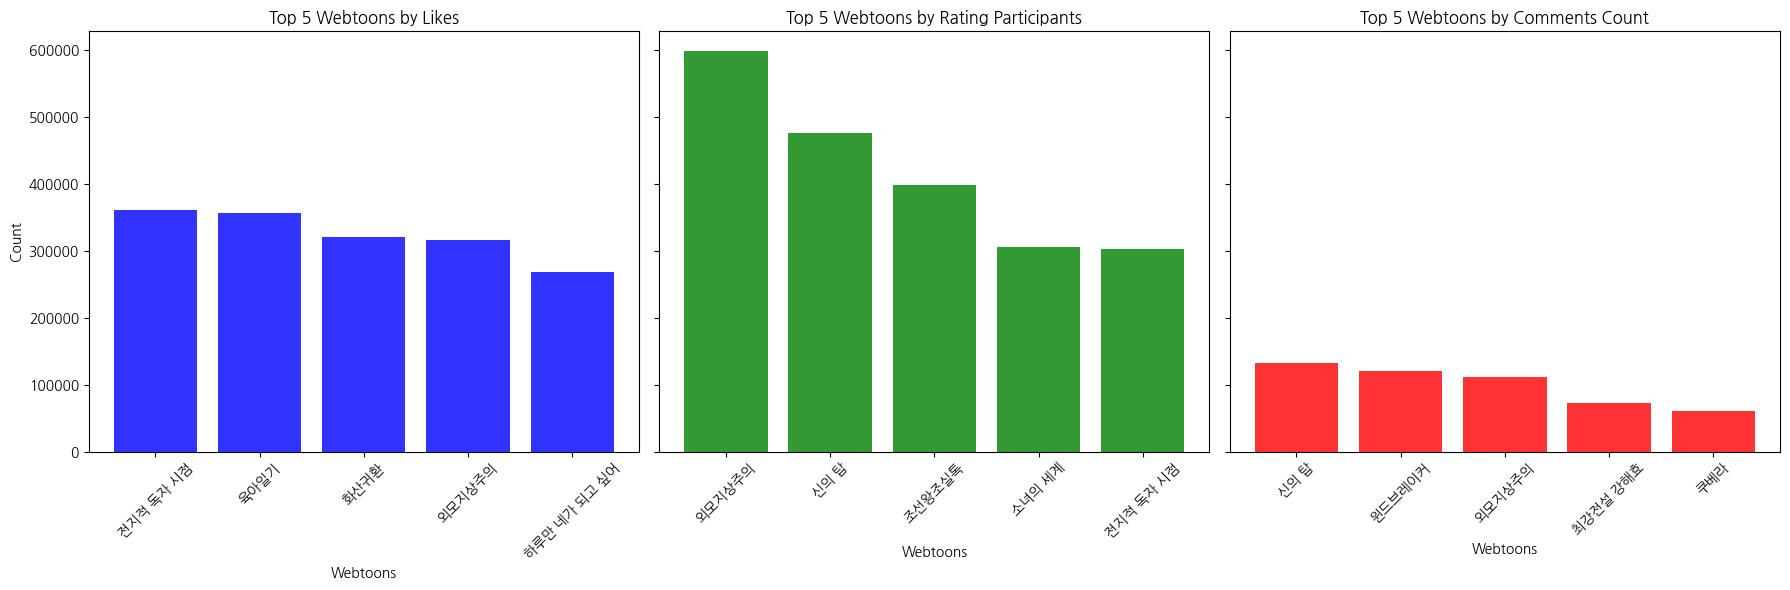

In [168]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 상위 5개 웹툰 데이터를 지표별로 추출
likes_top_5 = metadata.nlargest(5, 'Likes')
rating_top_5 = metadata.nlargest(5, 'Rating Participants')
comments_top_5 = metadata.nlargest(5, 'Comments Count')

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Likes 상위 5개 막대 그래프
axes[0].bar(likes_top_5.index, likes_top_5['Likes'], color='blue', alpha=0.8)
axes[0].set_title('Top 5 Webtoons by Likes')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Webtoons')
axes[0].tick_params(axis='x', rotation=45)

# Rating Participants 상위 5개 막대 그래프
axes[1].bar(rating_top_5.index, rating_top_5['Rating Participants'], color='green', alpha=0.8)
axes[1].set_title('Top 5 Webtoons by Rating Participants')
axes[1].set_xlabel('Webtoons')
axes[1].tick_params(axis='x', rotation=45)

# Comments Count 상위 5개 막대 그래프
axes[2].bar(comments_top_5.index, comments_top_5['Comments Count'], color='red', alpha=0.8)
axes[2].set_title('Top 5 Webtoons by Comments Count')
axes[2].set_xlabel('Webtoons')
axes[2].tick_params(axis='x', rotation=45)

# 그래프 간 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()

Correlation Matrix:
                        Likes  Rating Participants  Comments Count
Likes                1.000000             0.893827        0.614821
Rating Participants  0.893827             1.000000        0.821935
Comments Count       0.614821             0.821935        1.000000


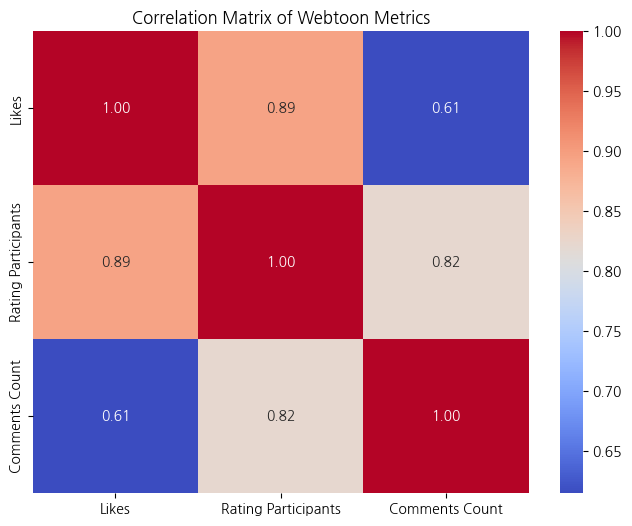

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관관계 계산
correlation_matrix = metadata.corr()

# 상관관계 출력
print("Correlation Matrix:")
print(correlation_matrix)

# 상관관계 히트맵
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Webtoon Metrics")
plt.show()

In [120]:
# 성인 웹툰 여부 확인 함수
def is_adult_webtoon(row):
    return row.get("웹툰 관심수", "") == "성인"

In [169]:
# 성인 웹툰 제외한 개수 계산
valid_webtoons = webtoon[~webtoon["웹툰 관심수"].str.contains("성인")]

In [170]:
# metadata의 지표를 webtoon 데이터프레임에 추가
valid_webtoons = valid_webtoons.merge(
    metadata[['Likes', 'Rating Participants', 'Comments Count']],
    left_on='웹툰 이름', 
    right_index=True, 
    how='left'
)

valid_webtoons.head()

웹툰 이름  웹툰 별점                                              웹툰 링크  \
0             참교육   9.89  https://comic.naver.com/webtoon/list?titleId=7...   
1            환생천마   9.95  https://comic.naver.com/webtoon/list?titleId=8...   
2          똑 닮은 딸   9.98  https://comic.naver.com/webtoon/list?titleId=7...   
3            신의 탑   9.84  https://comic.naver.com/webtoon/list?titleId=1...   
4  어느날 갑자기 가슴이 커짐   9.81  https://comic.naver.com/webtoon/list?titleId=8...   

  연재 요일     장르     웹툰 관심수  요일별 순위   회차  원작 유무                 작가이름      작품 수  \
0   mon     액션    952,557       1  179      0       ['한가람', '채용택']  2.500000   
1   mon  무협/사극    153,632       2   52      1  ['부겸', '장영훈', 'JP']  4.333333   
2   mon    스릴러    673,334       3  142      0               ['이담']  1.000000   
3   mon    판타지  1,909,208       4  653      0              ['SIU']  1.000000   
4   mon     일상     70,824       5   25      0              ['물렁이']  1.000000   

   전작 유무   Likes  Rating Participants  Comments Count  
0    1.0  257327               232678           22417  
1    1.0   29817                37419            2213  
2    0.0  160967               133750            6172  
3    0.0  262687               476327          131963  
4    0.0   48787                30052            6003

In [172]:
valid_webtoons.columns = ['webtoon_name', 'rating', 'link', 'day', 'genre', 'interest', 'rank_day', 'episode_count', 'originality', 'authors', 'work_count', 'previous_work', 'likes', 'rating_participants', 'comments_count']
valid_webtoons

webtoon_name  rating  \
0                      참교육    9.89   
1                     환생천마    9.95   
2                   똑 닮은 딸    9.98   
3                     신의 탑    9.84   
4           어느날 갑자기 가슴이 커짐    9.81   
..                     ...     ...   
689  밤필드의 아이들 by DARK MOON    9.84   
690             노래 못 하는 남자    9.92   
691      마섹남 - 마술하는 섹시한 남자    9.89   
692           주인공의 주식을 팝니다    9.84   
693                  프린키피아    9.84   

                                                  link  day  genre   interest  \
0    https://comic.naver.com/webtoon/list?titleId=7...  mon     액션    952,557   
1    https://comic.naver.com/webtoon/list?titleId=8...  mon  무협/사극    153,632   
2    https://comic.naver.com/webtoon/list?titleId=7...  mon    스릴러    673,334   
3    https://comic.naver.com/webtoon/list?titleId=1...  mon    판타지  1,909,208   
4    https://comic.naver.com/webtoon/list?titleId=8...  mon     일상     70,824   
..                                                 ...  ...    ...        ...   
689  https://comic.naver.com/webtoon/list?titleId=8...  sun    판타지     49,934   
690  https://comic.naver.com/webtoon/list?titleId=8...  sun    로맨스     22,545   
691  https://comic.naver.com/webtoon/list?titleId=7...  sun    로맨스     54,426   
692  https://comic.naver.com/webtoon/list?titleId=8...  sun    로맨스     57,199   
693  https://comic.naver.com/webtoon/list?titleId=8...  sun    판타지     23,203   

     rank_day episode_count  originality               authors  work_count  \
0           1           179            0        ['한가람', '채용택']    2.500000   
1           2            52            1   ['부겸', '장영훈', 'JP']    4.333333   
2           3           142            0                ['이담']    1.000000   
3           4           653            0               ['SIU']    1.000000   
4           5            25            0               ['물렁이']    1.000000   
..        ...           ...          ...                   ...         ...   
689        91            48            0              ['HYBE']    7.000000   
690        92            57            0         ['재은', '이해금']    1.000000   
691        93            90            1  ['랑또', '육시몬', '티르스']    4.000000   
692        94            96            1   ['목감기', '가얌', '50']    1.333333   
693        95            66            0         ['버튼', '한경찰']    3.500000   

     previous_work   likes  rating_participants  comments_count  
0              1.0  257327               232678           22417  
1              1.0   29817                37419            2213  
2              0.0  160967               133750            6172  
3              0.0  262687               476327          131963  
4              0.0   48787                30052            6003  
..             ...     ...                  ...             ...  
689            1.0   11676                 7777            2513  
690            0.0    4658                 3955             282  
691            1.0   21651                17845            1257  
692            1.0   27970                21482            1275  
693            1.0    9460                 9436             680  

[667 rows x 15 columns]

In [173]:
valid_webtoons.reset_index(drop = True, inplace=True)
valid_webtoons

webtoon_name  rating  \
0                      참교육    9.89   
1                     환생천마    9.95   
2                   똑 닮은 딸    9.98   
3                     신의 탑    9.84   
4           어느날 갑자기 가슴이 커짐    9.81   
..                     ...     ...   
662  밤필드의 아이들 by DARK MOON    9.84   
663             노래 못 하는 남자    9.92   
664      마섹남 - 마술하는 섹시한 남자    9.89   
665           주인공의 주식을 팝니다    9.84   
666                  프린키피아    9.84   

                                                  link  day  genre   interest  \
0    https://comic.naver.com/webtoon/list?titleId=7...  mon     액션    952,557   
1    https://comic.naver.com/webtoon/list?titleId=8...  mon  무협/사극    153,632   
2    https://comic.naver.com/webtoon/list?titleId=7...  mon    스릴러    673,334   
3    https://comic.naver.com/webtoon/list?titleId=1...  mon    판타지  1,909,208   
4    https://comic.naver.com/webtoon/list?titleId=8...  mon     일상     70,824   
..                                                 ...  ...    ...        ...   
662  https://comic.naver.com/webtoon/list?titleId=8...  sun    판타지     49,934   
663  https://comic.naver.com/webtoon/list?titleId=8...  sun    로맨스     22,545   
664  https://comic.naver.com/webtoon/list?titleId=7...  sun    로맨스     54,426   
665  https://comic.naver.com/webtoon/list?titleId=8...  sun    로맨스     57,199   
666  https://comic.naver.com/webtoon/list?titleId=8...  sun    판타지     23,203   

     rank_day episode_count  originality               authors  work_count  \
0           1           179            0        ['한가람', '채용택']    2.500000   
1           2            52            1   ['부겸', '장영훈', 'JP']    4.333333   
2           3           142            0                ['이담']    1.000000   
3           4           653            0               ['SIU']    1.000000   
4           5            25            0               ['물렁이']    1.000000   
..        ...           ...          ...                   ...         ...   
662        91            48            0              ['HYBE']    7.000000   
663        92            57            0         ['재은', '이해금']    1.000000   
664        93            90            1  ['랑또', '육시몬', '티르스']    4.000000   
665        94            96            1   ['목감기', '가얌', '50']    1.333333   
666        95            66            0         ['버튼', '한경찰']    3.500000   

     previous_work   likes  rating_participants  comments_count  
0              1.0  257327               232678           22417  
1              1.0   29817                37419            2213  
2              0.0  160967               133750            6172  
3              0.0  262687               476327          131963  
4              0.0   48787                30052            6003  
..             ...     ...                  ...             ...  
662            1.0   11676                 7777            2513  
663            0.0    4658                 3955             282  
664            1.0   21651                17845            1257  
665            1.0   27970                21482            1275  
666            1.0    9460                 9436             680  

[667 rows x 15 columns]

In [175]:
valid_webtoons["interest"] = valid_webtoons["interest"].apply(
    lambda x: x.replace(",", "") if isinstance(x, str) else x
)

# 결측치(NaN)를 처리하고 int64로 변환
valid_webtoons[['interest']] = valid_webtoons[['interest']].apply(
    pd.to_numeric, errors='coerce'
).fillna(0).astype('int64')

valid_webtoons

webtoon_name  rating  \
0                      참교육    9.89   
1                     환생천마    9.95   
2                   똑 닮은 딸    9.98   
3                     신의 탑    9.84   
4           어느날 갑자기 가슴이 커짐    9.81   
..                     ...     ...   
662  밤필드의 아이들 by DARK MOON    9.84   
663             노래 못 하는 남자    9.92   
664      마섹남 - 마술하는 섹시한 남자    9.89   
665           주인공의 주식을 팝니다    9.84   
666                  프린키피아    9.84   

                                                  link  day  genre  interest  \
0    https://comic.naver.com/webtoon/list?titleId=7...  mon     액션    952557   
1    https://comic.naver.com/webtoon/list?titleId=8...  mon  무협/사극    153632   
2    https://comic.naver.com/webtoon/list?titleId=7...  mon    스릴러    673334   
3    https://comic.naver.com/webtoon/list?titleId=1...  mon    판타지   1909208   
4    https://comic.naver.com/webtoon/list?titleId=8...  mon     일상     70824   
..                                                 ...  ...    ...       ...   
662  https://comic.naver.com/webtoon/list?titleId=8...  sun    판타지     49934   
663  https://comic.naver.com/webtoon/list?titleId=8...  sun    로맨스     22545   
664  https://comic.naver.com/webtoon/list?titleId=7...  sun    로맨스     54426   
665  https://comic.naver.com/webtoon/list?titleId=8...  sun    로맨스     57199   
666  https://comic.naver.com/webtoon/list?titleId=8...  sun    판타지     23203   

     rank_day episode_count  originality               authors  work_count  \
0           1           179            0        ['한가람', '채용택']    2.500000   
1           2            52            1   ['부겸', '장영훈', 'JP']    4.333333   
2           3           142            0                ['이담']    1.000000   
3           4           653            0               ['SIU']    1.000000   
4           5            25            0               ['물렁이']    1.000000   
..        ...           ...          ...                   ...         ...   
662        91            48            0              ['HYBE']    7.000000   
663        92            57            0         ['재은', '이해금']    1.000000   
664        93            90            1  ['랑또', '육시몬', '티르스']    4.000000   
665        94            96            1   ['목감기', '가얌', '50']    1.333333   
666        95            66            0         ['버튼', '한경찰']    3.500000   

     previous_work   likes  rating_participants  comments_count  
0              1.0  257327               232678           22417  
1              1.0   29817                37419            2213  
2              0.0  160967               133750            6172  
3              0.0  262687               476327          131963  
4              0.0   48787                30052            6003  
..             ...     ...                  ...             ...  
662            1.0   11676                 7777            2513  
663            0.0    4658                 3955             282  
664            1.0   21651                17845            1257  
665            1.0   27970                21482            1275  
666            1.0    9460                 9436             680  

[667 rows x 15 columns]

In [176]:
valid_webtoons.to_csv("webtoon_metadata.csv", index=False, encoding="utf-8-sig")

### 2-2. 연재중 웹툰 메타데이터 EDA

In [34]:
valid_webtoons = pd.read_csv('webtoon_metadata.csv')

In [37]:
valid_webtoons['genre'].value_counts()

genre
로맨스      194
판타지      158
드라마       94
액션        78
무협/사극     36
스릴러       35
개그        28
일상        26
스포츠       13
감성         5
Name: count, dtype: int64

In [36]:
valid_webtoons

webtoon_name  rating  \
0                      참교육    9.89   
1                     환생천마    9.95   
2                   똑 닮은 딸    9.98   
3                     신의 탑    9.84   
4           어느날 갑자기 가슴이 커짐    9.81   
..                     ...     ...   
662  밤필드의 아이들 by DARK MOON    9.84   
663             노래 못 하는 남자    9.92   
664      마섹남 - 마술하는 섹시한 남자    9.89   
665           주인공의 주식을 팝니다    9.84   
666                  프린키피아    9.84   

                                                  link  day  genre  interest  \
0    https://comic.naver.com/webtoon/list?titleId=7...  mon     액션    952557   
1    https://comic.naver.com/webtoon/list?titleId=8...  mon  무협/사극    153632   
2    https://comic.naver.com/webtoon/list?titleId=7...  mon    스릴러    673334   
3    https://comic.naver.com/webtoon/list?titleId=1...  mon    판타지   1909208   
4    https://comic.naver.com/webtoon/list?titleId=8...  mon     일상     70824   
..                                                 ...  ...    ...       ...   
662  https://comic.naver.com/webtoon/list?titleId=8...  sun    판타지     49934   
663  https://comic.naver.com/webtoon/list?titleId=8...  sun    로맨스     22545   
664  https://comic.naver.com/webtoon/list?titleId=7...  sun    로맨스     54426   
665  https://comic.naver.com/webtoon/list?titleId=8...  sun    로맨스     57199   
666  https://comic.naver.com/webtoon/list?titleId=8...  sun    판타지     23203   

     rank_day episode_count  originality               authors  work_count  \
0           1           179            0        ['한가람', '채용택']    2.500000   
1           2            52            1   ['부겸', '장영훈', 'JP']    4.333333   
2           3           142            0                ['이담']    1.000000   
3           4           653            0               ['SIU']    1.000000   
4           5            25            0               ['물렁이']    1.000000   
..        ...           ...          ...                   ...         ...   
662        91            48            0              ['HYBE']    7.000000   
663        92            57            0         ['재은', '이해금']    1.000000   
664        93            90            1  ['랑또', '육시몬', '티르스']    4.000000   
665        94            96            1   ['목감기', '가얌', '50']    1.333333   
666        95            66            0         ['버튼', '한경찰']    3.500000   

     previous_work   likes  rating_participants  comments_count  
0              1.0  257327               232678           22417  
1              1.0   29817                37419            2213  
2              0.0  160967               133750            6172  
3              0.0  262687               476327          131963  
4              0.0   48787                30052            6003  
..             ...     ...                  ...             ...  
662            1.0   11676                 7777            2513  
663            0.0    4658                 3955             282  
664            1.0   21651                17845            1257  
665            1.0   27970                21482            1275  
666            1.0    9460                 9436             680  

[667 rows x 15 columns]

In [43]:
def grby(target) :
    print(valid_webtoons.groupby(target)['likes'].sum().sort_values(ascending = False))
    print(valid_webtoons.groupby(target)['rating_participants'].sum().sort_values(ascending = False))
    print(valid_webtoons.groupby(target)['comments_count'].sum().sort_values(ascending = False))
    print(valid_webtoons.groupby(target)['interest'].sum().sort_values(ascending = False))

In [44]:
grby('day')

day
wed    4925592
fri    4242997
tue    4202844
mon    3746792
thu    3274505
sat    3140404
sun    3086583
Name: likes, dtype: int64
day
wed    4758477
fri    4483520
tue    4169385
mon    3942388
thu    3189803
sat    3035628
sun    2965742
Name: rating_participants, dtype: int64
day
mon    521909
fri    420291
wed    410112
tue    390787
thu    348833
sat    245141
sun    216943
Name: comments_count, dtype: int64
day
fri    15467017
wed    15289515
mon    14215840
tue    12936141
thu    11119134
sun    10565739
sat     9891843
Name: interest, dtype: int64


In [45]:
grby('genre')

genre
로맨스      6748711
판타지      6077000
액션       3678323
드라마      3666695
무협/사극    1644713
일상       1580815
스릴러      1385004
개그       1258162
스포츠       372589
감성        207705
Name: likes, dtype: int64
genre
판타지      6365870
로맨스      5694007
드라마      4071734
액션       3646405
무협/사극    1880253
스릴러      1567662
개그       1396961
일상       1272388
스포츠       459877
감성        189786
Name: rating_participants, dtype: int64
genre
판타지      728625
로맨스      386770
드라마      369557
액션       360509
일상       157280
스포츠      139237
무협/사극    136130
스릴러      134399
개그       127936
감성        13573
Name: comments_count, dtype: int64
genre
로맨스      24092893
판타지      21248800
액션       13270887
드라마      13169509
무협/사극     6655662
스릴러       3744900
일상        2474413
개그        2315735
스포츠       2049443
감성         462987
Name: interest, dtype: int64


In [108]:
# 상관관계 분석
correlation_matrix = valid_webtoons[["웹툰 관심수", "좋아요 수", "별점 참여 수", "전체 댓글 수"]].corr()

# 결과 출력
print("상관관계 분석 결과:")
print(correlation_matrix)

상관관계 분석 결과:
           웹툰 관심수     좋아요 수   별점 참여 수   전체 댓글 수
웹툰 관심수   1.000000  0.850611  0.876690  0.749172
좋아요 수    0.850611  1.000000  0.894007  0.614504
별점 참여 수  0.876690  0.894007  1.000000  0.821351
전체 댓글 수  0.749172  0.614504  0.821351  1.000000


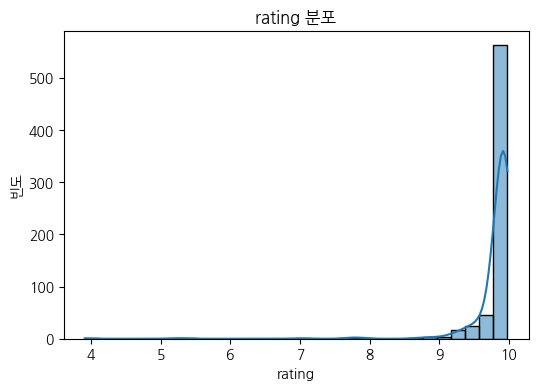

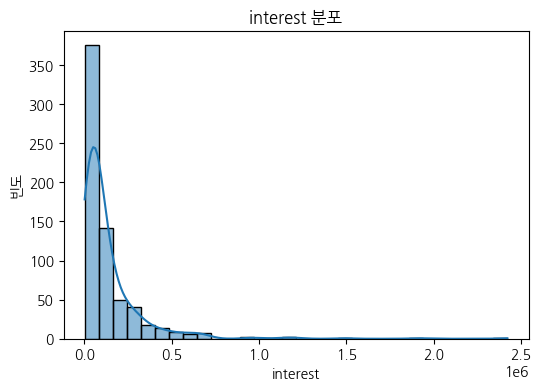

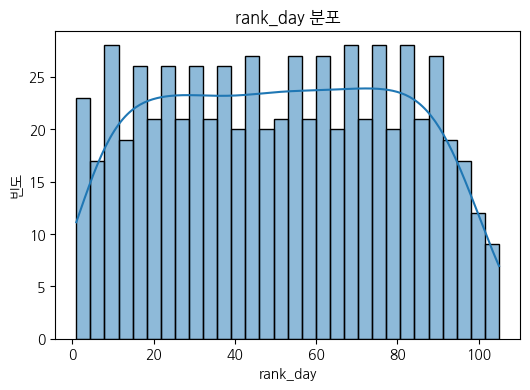

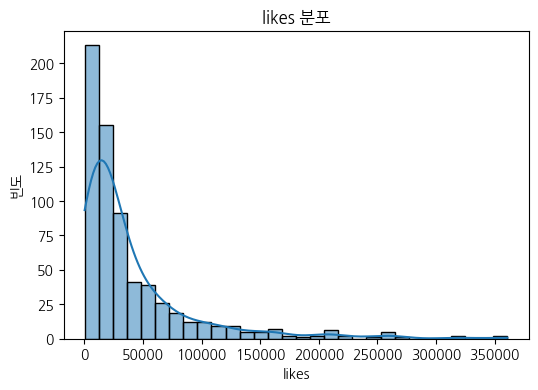

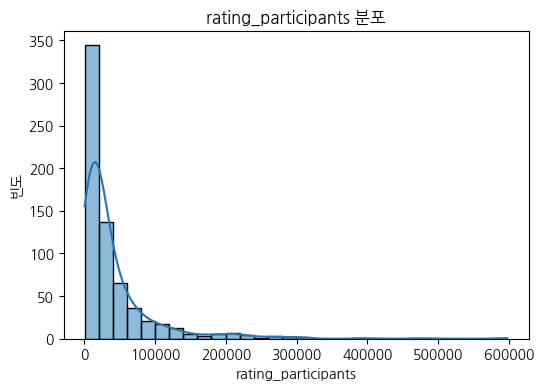

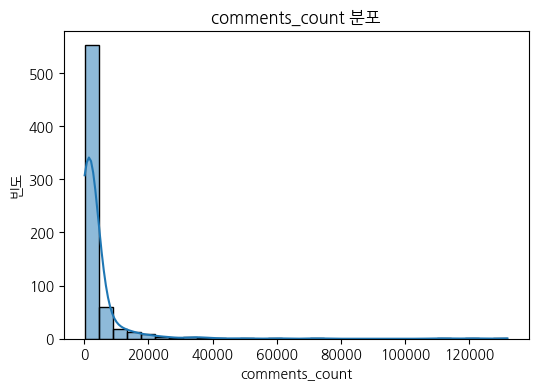

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 주요 수치형 변수 분포
num_cols = ["rating", "interest", "rank_day", "likes", "rating_participants", "comments_count"]

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(valid_webtoons[col], kde=True, bins=30)
    plt.title(f"{col} 분포")
    plt.xlabel(col)
    plt.ylabel("빈도")
    plt.show()

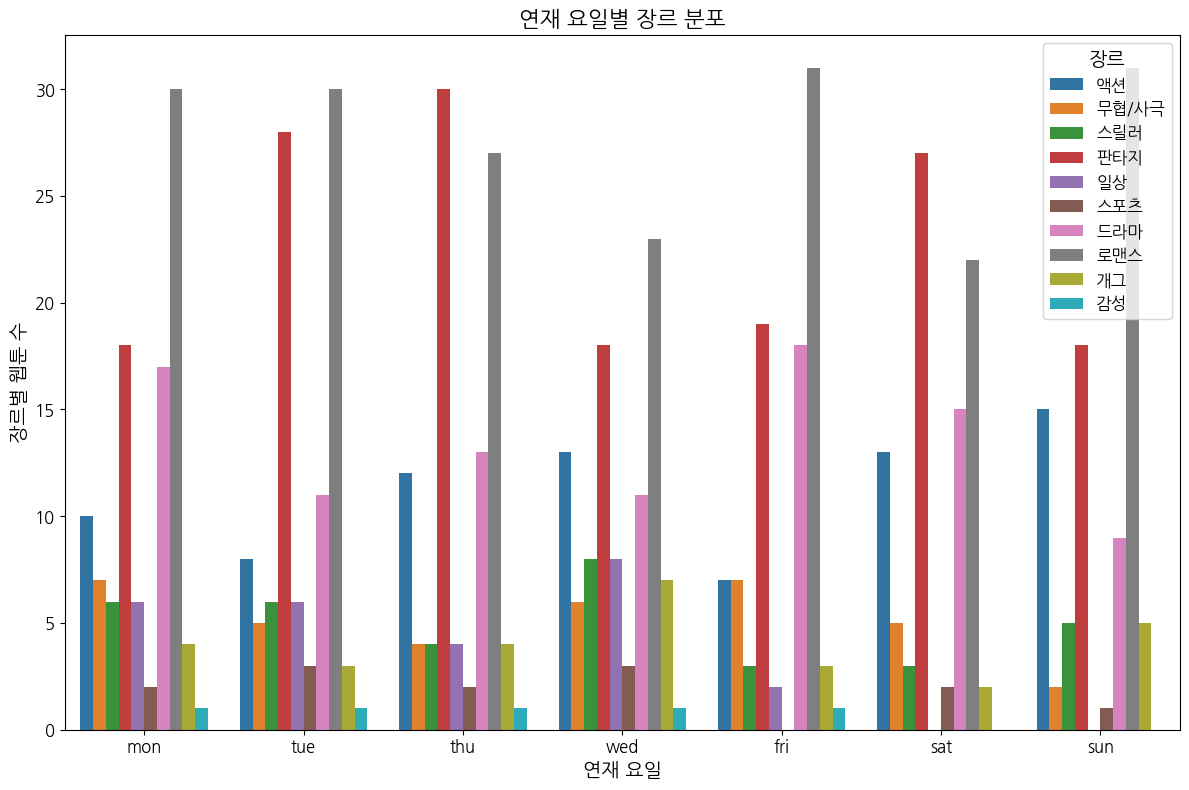

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# 연재 요일별로 장르 분포를 시각화
plt.figure(figsize = (12, 8))
sns.countplot(data = valid_webtoons, x = "day", hue = "genre", order = valid_webtoons["day"].value_counts().index)

# 그래프 꾸미기
plt.title("연재 요일별 장르 분포", fontsize=16)
plt.xlabel("연재 요일", fontsize=14)
plt.ylabel("장르별 웹툰 수", fontsize=14)
plt.legend(title="장르", fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# 그래프 표시
plt.show()


In [49]:
# 요일 순서 지정
day_order = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]

# 요일별로 '웹툰 관심수'가 가장 높은 수치만 뽑기
top_interest_per_day = valid_webtoons.groupby("day")["interest"].mean().reset_index()

# 요일 순서에 따라 정렬
top_interest_per_day["day"] = pd.Categorical(top_interest_per_day["day"], categories=day_order, ordered=True)
top_interest_per_day = top_interest_per_day.sort_values("day")

top_interest_per_day

day       interest
1  mon  140750.891089
5  tue  128080.603960
6  wed  156015.459184
4  thu  110090.435644
0  fri  169967.219780
2  sat  111144.303371
3  sun  122857.430233

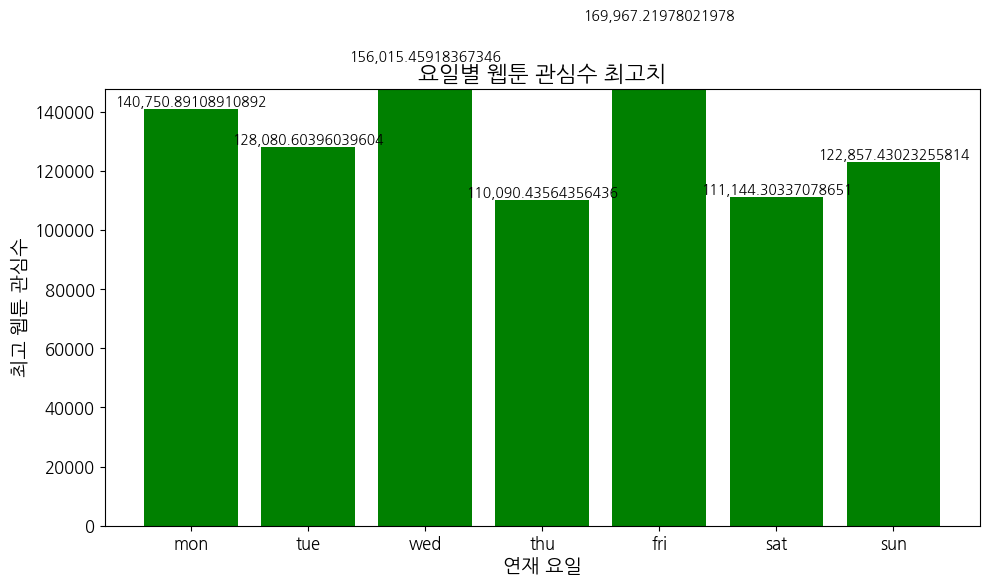

In [50]:
# 막대그래프 그리기
plt.figure(figsize=(10, 6))
bars = plt.bar(top_interest_per_day["day"], top_interest_per_day["interest"], color='green')

# y축 범위 조정: 최대값의 10% 여유를 추가
plt.ylim(0, top_interest_per_day["interest"].mean() * 1.1)

# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # 막대의 중앙 x 위치
        height,  # 막대의 높이
        f"{height:,}",  # 값 표시 (천 단위 쉼표 추가)
        ha='center',  # 가운데 정렬
        va='bottom',  # 텍스트의 아래쪽 정렬
        fontsize=10
    )

# 그래프 꾸미기
plt.title("요일별 웹툰 관심수 최고치", fontsize=16)
plt.xlabel("연재 요일", fontsize=14)
plt.ylabel("최고 웹툰 관심수", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# 그래프 표시
plt.show()

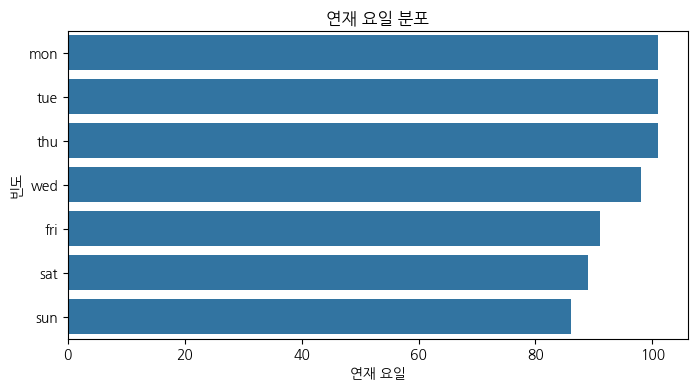

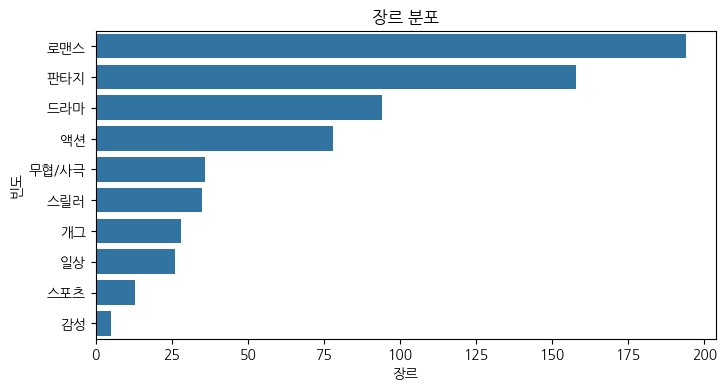

In [23]:
# 범주형 변수: 연재 요일, 장르
for col in ["연재 요일", "장르"]:
    plt.figure(figsize=(8, 4))
    sns.countplot(valid_webtoons[col], order=valid_webtoons[col].value_counts().index)
    plt.title(f"{col} 분포")
    plt.xlabel(col)
    plt.ylabel("빈도")
    plt.show()

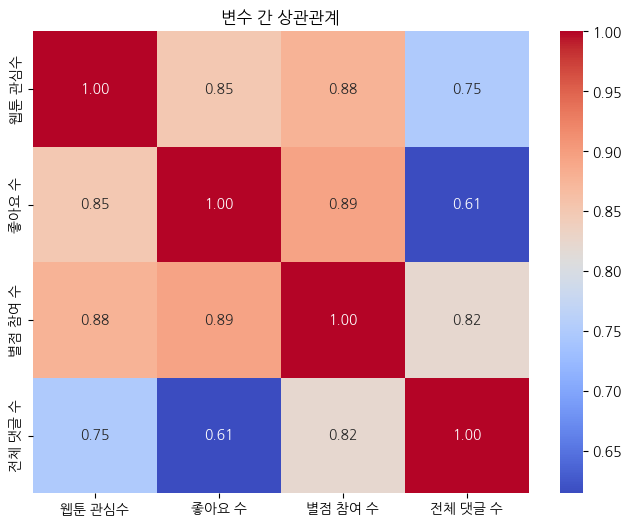

In [25]:
# 상관관계 계산 및 시각화
corr_matrix = valid_webtoons[["웹툰 관심수", "좋아요 수", "별점 참여 수", "전체 댓글 수"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("변수 간 상관관계")
plt.show()

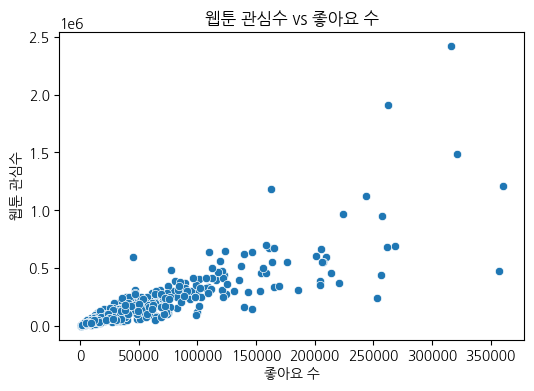

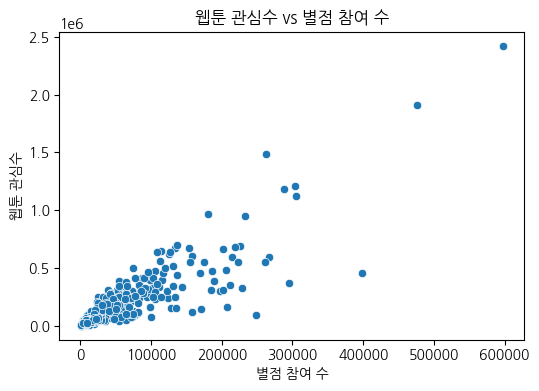

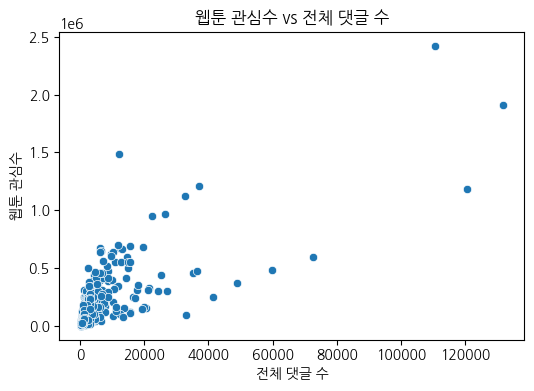

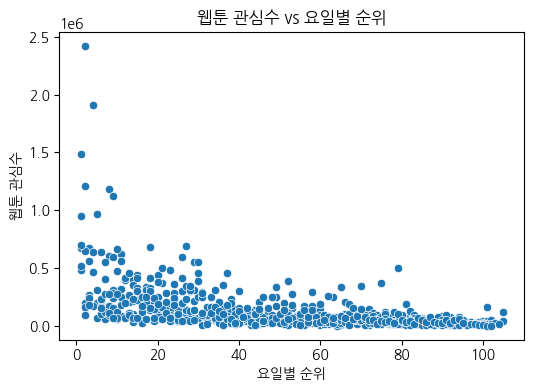

In [26]:
# 흥행 지표와 다른 변수 간 관계
target = "웹툰 관심수"
features = ["좋아요 수", "별점 참여 수", "전체 댓글 수", "요일별 순위"]

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=valid_webtoons[feature], y=valid_webtoons[target])
    plt.title(f"{target} vs {feature}")
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()


### 2-3. 연재중 웹툰 댓글 크롤링

In [19]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
from tqdm import tqdm
from selenium.webdriver.chrome.options import Options

# 웹 드라이버로 링크 열기 함수
def open_webtoon_page(webtoon_url):
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # Headless 모드 활성화
    chrome_options.add_argument("--disable-gpu")
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(webtoon_url)
    return driver

def wait_for_element(driver, xpath, timeout=10):
    try:
        element = WebDriverWait(driver, timeout).until(
            EC.presence_of_element_located((By.XPATH, xpath))
        )
        return element
    except Exception as e:
        print(f"Timeout waiting for element: {xpath}")
        return None

def click_sort_button(driver):
    try:
        # 첫 번째 위치에서 버튼 찾기
        sort_button = wait_for_element(driver, "/html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[2]/div[2]/button[2]")
        if not sort_button:
            # 두 번째 위치에서 버튼 찾기
            sort_button = wait_for_element(driver, "/html/body/div[1]/div/div[2]/div/div[1]/div[3]/div[1]/div[2]/button[2]")

        if sort_button:
            sort_button.click()
            time.sleep(2)  # 정렬 후 로딩 대기
            return True
        return False
    except Exception as e:
        print(f"Error clicking sort button: {e}")
        return False

def extract_best_comments(driver, webtoon_name, episode_idx, all_data):
    try:
        best_comment_elements = driver.find_elements(By.XPATH, "/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li")

        for idx, comment_element in enumerate(best_comment_elements):
            try:
                # 댓글 텍스트 확인 (두 가지 Xpath 확인)
                try:
                    comment_text = comment_element.find_element(By.XPATH, f"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[{idx + 1}]/div[1]/div/div[2]/span[2]").text
                except Exception:
                    comment_text = comment_element.find_element(By.XPATH, f"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[{idx + 1}]/div[1]/div/div[2]").text

                # 추천수
                likes = comment_element.find_element(By.XPATH, f"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[{idx + 1}]/div[1]/div/div[4]/div/a[1]/em").text

                # 비추천수
                dislikes = comment_element.find_element(By.XPATH, f"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[{idx + 1}]/div[1]/div/div[4]/div/a[2]/em").text

                # 데이터 저장
                all_data["웹툰 이름"].append(webtoon_name)
                all_data["화수"].append(f"{episode_idx}화")
                all_data["Comment"].append(comment_text)
                all_data["Likes"].append(int(likes.replace(",", "")))
                all_data["Dislikes"].append(int(dislikes.replace(",", "")))
            except Exception as e:
                print(f"Error extracting best comment at index {idx + 1}: {e}")

    except Exception as e:
        print(f"Error finding best comments: {e}")


def crawl_episode_comments(driver, webtoon_name, episode_idx, all_data):
    try:
        episode_xpath = f"/html/body/div[1]/div/div[2]/div/div[1]/div[3]/ul/li[{episode_idx}]/a"
        episode_element = wait_for_element(driver, episode_xpath)
        if episode_element:
            episode_element.click()
            time.sleep(2)  # 페이지 로드 대기
            extract_best_comments(driver, webtoon_name, episode_idx, all_data)
    except Exception as e:
        print(f"Error during crawling episode {episode_idx}: {e}")

def crawl_best_comments(webtoon_data):
    all_data = {
        "웹툰 이름": [],
        "화수": [],
        "Comment": [],
        "Likes": [],
        "Dislikes": []
    }

    total_iterations = len(webtoon_data) * 5  # 각 웹툰당 5회씩 크롤링
    with tqdm(total=total_iterations, desc="Processing Webtoons") as pbar:
        for idx, row in webtoon_data.iterrows():
            webtoon_name = row["웹툰 이름"]
            webtoon_url = row["웹툰 링크"]

            driver = open_webtoon_page(webtoon_url)

            try:
                # '1화부터' 버튼 클릭 (연재 중인 웹툰의 경우)
                if not is_finished_webtoon(webtoon_url):
                    click_sort_button(driver)

                for episode_idx in range(1, 6):  # 1화부터 5화까지 크롤링
                    crawl_episode_comments(driver, webtoon_name, episode_idx, all_data)
                    pbar.update(1)
            except Exception as e:
                print(f"Error processing webtoon {webtoon_name}: {e}")
            finally:
                driver.quit()

    # 데이터를 DataFrame으로 저장
    df = pd.DataFrame(all_data)
    df.to_csv("best_comments_with_episodes.csv", index=False, encoding="utf-8-sig")
    print("Crawling completed. Data saved to 'best_comments_with_episodes.csv'.")

def is_finished_webtoon(url):
    return "week=finish" in url

In [16]:
webtoon = pd.read_csv('연재중_웹툰데이터_.csv')
webtoon

웹툰 이름  웹툰 별점  \
0                      참교육   9.89   
1                     환생천마   9.95   
2                   똑 닮은 딸   9.98   
3                     신의 탑   9.84   
4           어느날 갑자기 가슴이 커짐   9.81   
..                     ...    ...   
689  밤필드의 아이들 by DARK MOON   9.84   
690             노래 못 하는 남자   9.92   
691      마섹남 - 마술하는 섹시한 남자   9.89   
692           주인공의 주식을 팝니다   9.84   
693                  프린키피아   9.84   

                                                 웹툰 링크 연재 요일     장르  \
0    https://comic.naver.com/webtoon/list?titleId=7...   mon     액션   
1    https://comic.naver.com/webtoon/list?titleId=8...   mon  무협/사극   
2    https://comic.naver.com/webtoon/list?titleId=7...   mon    스릴러   
3    https://comic.naver.com/webtoon/list?titleId=1...   mon    판타지   
4    https://comic.naver.com/webtoon/list?titleId=8...   mon     일상   
..                                                 ...   ...    ...   
689  https://comic.naver.com/webtoon/list?titleId=8...   sun    판타지   
690  https://comic.naver.com/webtoon/list?titleId=8...   sun    로맨스   
691  https://comic.naver.com/webtoon/list?titleId=7...   sun    로맨스   
692  https://comic.naver.com/webtoon/list?titleId=8...   sun    로맨스   
693  https://comic.naver.com/webtoon/list?titleId=8...   sun    판타지   

        웹툰 관심수  요일별 순위  
0      952,557       1  
1      153,632       2  
2      673,334       3  
3    1,909,208       4  
4       70,824       5  
..         ...     ...  
689     49,934      91  
690     22,545      92  
691     54,426      93  
692     57,199      94  
693     23,203      95  

[694 rows x 7 columns]

In [18]:
# 성인 웹툰 제외한 개수 계산
valid_webtoons = webtoon[~webtoon["웹툰 관심수"].str.contains("성인")]

In [ ]:
crawl_best_comments(valid_webtoons)

## 3. 완결 웹툰 메타데이터 크롤링

In [33]:
webtoon = pd.read_csv('완결 웹툰 데이터_최종.csv')
webtoon = webtoon.drop('Unnamed: 0', axis = 1)
webtoon

조회수 순위                웹툰 이름  웹툰 별점  \
0        20                 연애혁명   9.87   
1       100                마음의소리   9.86   
2        67                프리드로우   9.79   
3        89                 노블레스   9.62   
4        48            갓 오브 하이스쿨   9.64   
..      ...                  ...    ...   
670     699  유미의 세포들 외전 : 프로 직장인   9.96   
671     392                한줌물망초   9.96   
672    1492              아찔한 전남편   9.89   
673     308                  절벽귀   9.97   
674    1543                 엑스애쉬   9.87   

                                                 웹툰 링크   장르   웹툰 관심수    회차  \
0    https://comic.naver.com/webtoon/list?titleId=5...  드라마  2622242   442   
1    https://comic.naver.com/webtoon/list?titleId=2...   개그  1750053  1238   
2    https://comic.naver.com/webtoon/list?titleId=5...  드라마  1575709   516   
3    https://comic.naver.com/webtoon/list?titleId=2...  판타지  1371554   545   
4    https://comic.naver.com/webtoon/list?titleId=3...  판타지  1371113   573   
..                                                 ...  ...      ...   ...   
670  https://comic.naver.com/webtoon/list?titleId=7...  로맨스   100757     6   
671  https://comic.naver.com/webtoon/list?titleId=4...  판타지   100152    96   
672  https://comic.naver.com/webtoon/list?titleId=7...  로맨스   100123   101   
673  https://comic.naver.com/webtoon/list?titleId=6...  스릴러   100073     8   
674  https://comic.naver.com/webtoon/list?titleId=7...  판타지   100002   108   

     원작 유무                 작가이름       작품 수  전작 유무  
0        0              ['232']   2.000000      0  
1        0               ['조석']  18.000000      0  
2        0              ['전선욱']   3.000000      0  
3        0       ['손제호', '이광수']   3.500000      0  
4        0              ['박용제']   2.000000      1  
..     ...                  ...        ...    ...  
670      0              ['이동건']  11.000000      1  
671      0              ['혜진양']   5.000000      1  
672      1  ['마풍각', '여백', '별규']   1.666667      0  
673      0              ['오성대']   4.000000      1  
674      0       ['김세훈', '이광수']   4.500000      1  

[675 rows x 11 columns]

In [34]:
webtoon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   조회수 순위  675 non-null    int64  
 1   웹툰 이름   675 non-null    object 
 2   웹툰 별점   675 non-null    float64
 3   웹툰 링크   675 non-null    object 
 4   장르      675 non-null    object 
 5   웹툰 관심수  675 non-null    int64  
 6   회차      675 non-null    object 
 7   원작 유무   675 non-null    int64  
 8   작가이름    675 non-null    object 
 9   작품 수    675 non-null    float64
 10  전작 유무   675 non-null    int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 58.1+ KB


In [13]:
all_data = {
    "웹툰 이름": [],
    "웹툰 링크": [],
    "화수": [],
    "Likes": [],
    "Rating Participants": [],
    "Comments Count": []
}

error_log = {
    "웹툰 이름": [],
    "웹툰 링크": []
}

for idx, row in tqdm(webtoon.iterrows(), total=len(webtoon), desc="Processing Webtoons"):
    webtoon_list_url = row["웹툰 링크"]
    driver = open_webtoon_page(webtoon_list_url)

    try:
        for episode_idx in range(1, 6):  # 1화부터 5화까지 클릭
            if not click_episode(driver, episode_idx):
                continue 

            episode_data = crawl_webtoon_data(driver)

            all_data["웹툰 이름"].append(row["웹툰 이름"])
            all_data["웹툰 링크"].append(driver.current_url)
            all_data["화수"].append(f"{episode_idx}화")
            all_data["Likes"].append(episode_data["Likes"])
            all_data["Rating Participants"].append(episode_data["Rating Participants"])
            all_data["Comments Count"].append(episode_data["Comments Count"])

            driver.back()
            time.sleep(2)  # 페이지 로드 대기

    except Exception as e:
        print(f"Error processing webtoon: {e}")
        error_log["웹툰 이름"].append(row["웹툰 이름"])
        error_log["웹툰 링크"].append(webtoon_list_url)
    finally:
        driver.quit()

# 데이터를 데이터프레임으로 저장
result_df = pd.DataFrame(all_data)
result_df.to_csv("finish_webtoon_data.csv", index=False, encoding="utf-8-sig")

error_df = pd.DataFrame(error_log)
error_df.to_csv("webtoon_error_log.csv", index=False, encoding="utf-8-sig")

print(f"Crawling completed. Data saved to 'finish_webtoon_data.csv'.")
print(f"Error log saved to 'webtoon_error_log.csv'.")

### 3-1. 완결 웹툰 데이터 전처리 및 EDA

In [35]:
finish_webtoon = pd.read_csv('finish_webtoon_data.csv')
finish_webtoon

웹툰 이름                                              웹툰 링크  화수    Likes  \
0     연애혁명  https://comic.naver.com/webtoon/detail?titleId...  1화  99,999+   
1     연애혁명  https://comic.naver.com/webtoon/detail?titleId...  2화   75,731   
2     연애혁명  https://comic.naver.com/webtoon/detail?titleId...  3화   74,473   
3     연애혁명  https://comic.naver.com/webtoon/detail?titleId...  4화   67,925   
4     연애혁명  https://comic.naver.com/webtoon/detail?titleId...  5화   69,687   
...    ...                                                ...  ..      ...   
3338  엑스애쉬  https://comic.naver.com/webtoon/detail?titleId...  1화   12,482   
3339  엑스애쉬  https://comic.naver.com/webtoon/detail?titleId...  2화    7,422   
3340  엑스애쉬  https://comic.naver.com/webtoon/detail?titleId...  3화    6,253   
3341  엑스애쉬  https://comic.naver.com/webtoon/detail?titleId...  4화    5,785   
3342  엑스애쉬  https://comic.naver.com/webtoon/detail?titleId...  5화    5,444   

     Rating Participants Comments Count  
0             172,405 참여         53,188  
1             133,801 참여         15,304  
2             172,104 참여         12,936  
3             118,726 참여         18,557  
4             116,763 참여         16,348  
...                  ...            ...  
3338           14,169 참여          2,199  
3339            6,842 참여            743  
3340            5,987 참여            584  
3341            5,554 참여            577  
3342            5,160 참여            551  

[3343 rows x 6 columns]

In [36]:
# 별점 참여자수 열에서 '참여'라는 문자열 삭제
finish_webtoon["Rating Participants"] = finish_webtoon["Rating Participants"].apply(
    lambda x: x.replace(" 참여", "") if isinstance(x, str) else x
)

# 별점 참여자수 열에서 ','라는 문자열 삭제
finish_webtoon["Rating Participants"] = finish_webtoon["Rating Participants"].apply(
    lambda x: x.replace(",", "") if isinstance(x, str) else x
)

finish_webtoon['Rating Participants']

0       172405
1       133801
2       172104
3       118726
4       116763
         ...  
3338     14169
3339      6842
3340      5987
3341      5554
3342      5160
Name: Rating Participants, Length: 3343, dtype: object

In [37]:
# 좋아요 수 열에서 ','라는 문자열 삭제
finish_webtoon["Likes"] = finish_webtoon["Likes"].apply(
    lambda x: x.replace(",", "") if isinstance(x, str) else x
)

finish_webtoon["Likes"] = finish_webtoon["Likes"].apply(
    lambda x: x.replace("99999+", "99999") if isinstance(x, str) else x
)

finish_webtoon['Likes']

0       99999
1       75731
2       74473
3       67925
4       69687
        ...  
3338    12482
3339     7422
3340     6253
3341     5785
3342     5444
Name: Likes, Length: 3343, dtype: object

In [38]:
# 전체 댓글 수 열에서 ','라는 문자열 삭제
finish_webtoon["Comments Count"] = finish_webtoon["Comments Count"].apply(
    lambda x: x.replace(",", "") if isinstance(x, str) else x
)

finish_webtoon['Comments Count']

0       53188
1       15304
2       12936
3       18557
4       16348
        ...  
3338     2199
3339      743
3340      584
3341      577
3342      551
Name: Comments Count, Length: 3343, dtype: object

In [39]:
finish_webtoon.columns

Index(['웹툰 이름', '웹툰 링크', '화수', 'Likes', 'Rating Participants',
       'Comments Count'],
      dtype='object')

In [40]:
# 결측치(NaN)를 처리하고 int64로 변환
finish_webtoon[['Likes', 'Rating Participants', 'Comments Count']] = finish_webtoon[['Likes', 'Rating Participants', 'Comments Count']].apply(
    pd.to_numeric, errors='coerce'
).fillna(0).astype('int64')

In [41]:
# Group by '웹툰 이름' and sum the columns
metadata = finish_webtoon.groupby('웹툰 이름')[['Likes', 'Rating Participants', 'Comments Count']].sum()

# Sort each column in descending order
metadata = metadata.sort_values(by=['Likes', 'Rating Participants', 'Comments Count'], ascending=False)

# Display the resulting DataFrame
metadata

Likes  Rating Participants  Comments Count
웹툰 이름                                                 
무한도전 릴레이툰  494070               973436          225528
대학일기       442694               289851           83347
독립일기       439294               227542           39315
연애혁명       387815               713799          116333
여신강림       373202               356731           41199
...           ...                  ...             ...
죄의 파편        6105               197839           44729
라이징패스트볼      5102                39067            8888
어빌리티         4445                83731           24310
기사도          4095               110195           42510
쎈놈           2354                 2657             567

[675 rows x 3 columns]

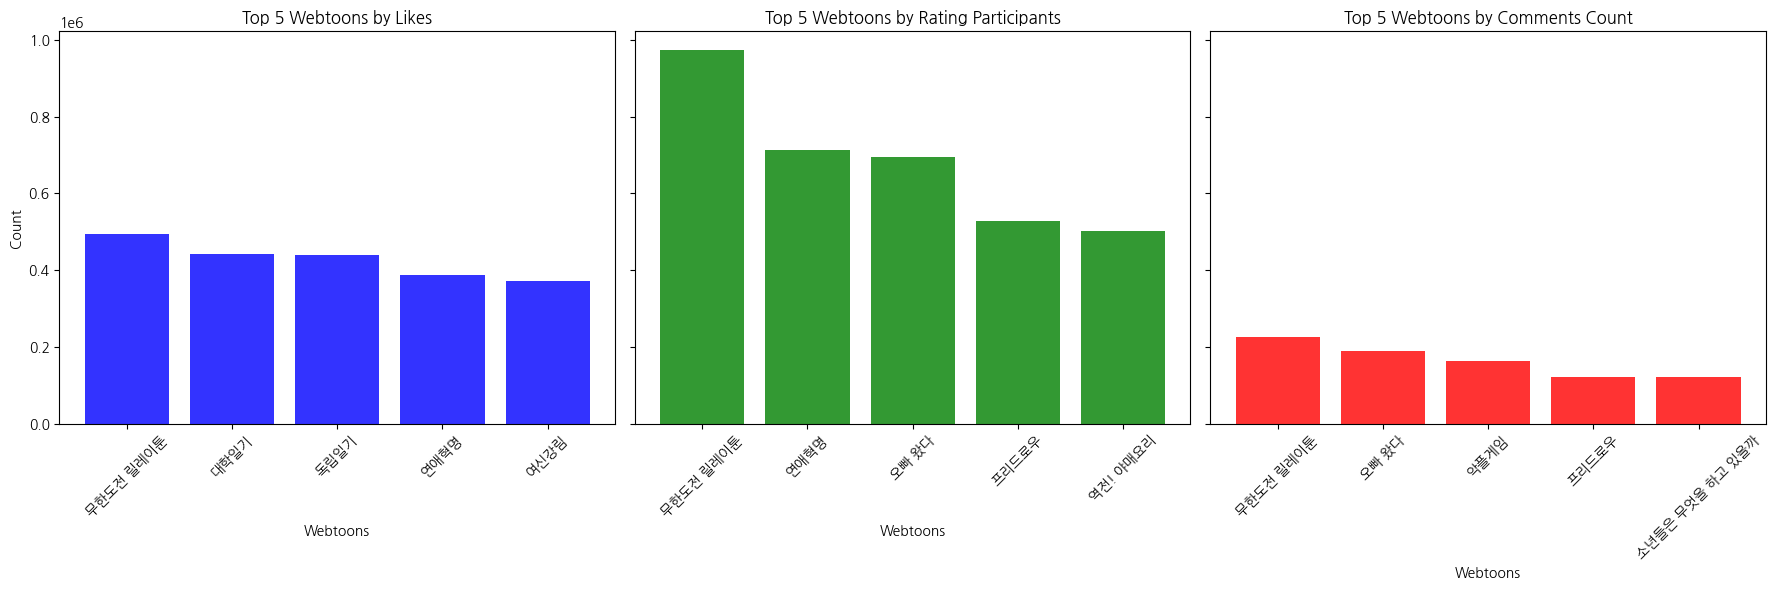

In [9]:
import matplotlib.pyplot as plt

# 상위 5개 웹툰 데이터를 지표별로 추출
likes_top_5 = metadata.nlargest(5, 'Likes')
rating_top_5 = metadata.nlargest(5, 'Rating Participants')
comments_top_5 = metadata.nlargest(5, 'Comments Count')

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Likes 상위 5개 막대 그래프
axes[0].bar(likes_top_5.index, likes_top_5['Likes'], color='blue', alpha=0.8)
axes[0].set_title('Top 5 Webtoons by Likes')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Webtoons')
axes[0].tick_params(axis='x', rotation=45)

# Rating Participants 상위 5개 막대 그래프
axes[1].bar(rating_top_5.index, rating_top_5['Rating Participants'], color='green', alpha=0.8)
axes[1].set_title('Top 5 Webtoons by Rating Participants')
axes[1].set_xlabel('Webtoons')
axes[1].tick_params(axis='x', rotation=45)

# Comments Count 상위 5개 막대 그래프
axes[2].bar(comments_top_5.index, comments_top_5['Comments Count'], color='red', alpha=0.8)
axes[2].set_title('Top 5 Webtoons by Comments Count')
axes[2].set_xlabel('Webtoons')
axes[2].tick_params(axis='x', rotation=45)

# 그래프 간 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()

Correlation Matrix:
                        Likes  Rating Participants  Comments Count
Likes                1.000000             0.568401        0.246969
Rating Participants  0.568401             1.000000        0.789168
Comments Count       0.246969             0.789168        1.000000


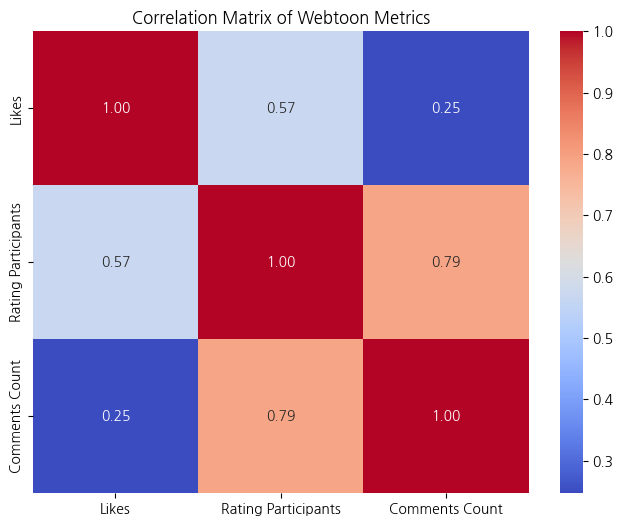

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관관계 계산
correlation_matrix = metadata.corr()

# 상관관계 출력
print("Correlation Matrix:")
print(correlation_matrix)

# 상관관계 히트맵
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Webtoon Metrics")
plt.show()

In [49]:
# metadata의 지표를 webtoon 데이터프레임에 추가
finish_webtoons = webtoon.merge(
    metadata[['Likes', 'Rating Participants', 'Comments Count']],
    left_on='웹툰 이름', 
    right_index=True, 
    how='left'
)

finish_webtoons.head()

조회수 순위      웹툰 이름  웹툰 별점  \
0      20       연애혁명   9.87   
1     100      마음의소리   9.86   
2      67      프리드로우   9.79   
3      89       노블레스   9.62   
4      48  갓 오브 하이스쿨   9.64   

                                               웹툰 링크   장르   웹툰 관심수    회차  \
0  https://comic.naver.com/webtoon/list?titleId=5...  드라마  2622242   442   
1  https://comic.naver.com/webtoon/list?titleId=2...   개그  1750053  1238   
2  https://comic.naver.com/webtoon/list?titleId=5...  드라마  1575709   516   
3  https://comic.naver.com/webtoon/list?titleId=2...  판타지  1371554   545   
4  https://comic.naver.com/webtoon/list?titleId=3...  판타지  1371113   573   

   원작 유무            작가이름  작품 수  전작 유무   Likes  Rating Participants  \
0      0         ['232']   2.0      0  387815               713799   
1      0          ['조석']  18.0      0  110500               268305   
2      0         ['전선욱']   3.0      0  193124               528133   
3      0  ['손제호', '이광수']   3.5      0   91983               263859   
4      0         ['박용제']   2.0      1  134823               261048   

   Comments Count  
0          116333  
1           89049  
2          122728  
3           82093  
4           56406

In [51]:
valid_webtoons.columns = ['rank_popularity', 'webtoon_name', 'rating', 'link', 'genre', 'interest', 'episode_count', 'originality', 'authors', 'work_count', 'previous_work', 'likes', 'rating_participants', 'comments_count']
valid_webtoons

rank_popularity         webtoon_name  rating  \
0                 20                 연애혁명    9.87   
1                100                마음의소리    9.86   
2                 67                프리드로우    9.79   
3                 89                 노블레스    9.62   
4                 48            갓 오브 하이스쿨    9.64   
..               ...                  ...     ...   
670              699  유미의 세포들 외전 : 프로 직장인    9.96   
671              392                한줌물망초    9.96   
672             1492              아찔한 전남편    9.89   
673              308                  절벽귀    9.97   
674             1543                 엑스애쉬    9.87   

                                                  link genre  interest  \
0    https://comic.naver.com/webtoon/list?titleId=5...   드라마   2622242   
1    https://comic.naver.com/webtoon/list?titleId=2...    개그   1750053   
2    https://comic.naver.com/webtoon/list?titleId=5...   드라마   1575709   
3    https://comic.naver.com/webtoon/list?titleId=2...   판타지   1371554   
4    https://comic.naver.com/webtoon/list?titleId=3...   판타지   1371113   
..                                                 ...   ...       ...   
670  https://comic.naver.com/webtoon/list?titleId=7...   로맨스    100757   
671  https://comic.naver.com/webtoon/list?titleId=4...   판타지    100152   
672  https://comic.naver.com/webtoon/list?titleId=7...   로맨스    100123   
673  https://comic.naver.com/webtoon/list?titleId=6...   스릴러    100073   
674  https://comic.naver.com/webtoon/list?titleId=7...   판타지    100002   

    episode_count  originality              authors  work_count  \
0             442            0              ['232']    2.000000   
1            1238            0               ['조석']   18.000000   
2             516            0              ['전선욱']    3.000000   
3             545            0       ['손제호', '이광수']    3.500000   
4             573            0              ['박용제']    2.000000   
..            ...          ...                  ...         ...   
670             6            0              ['이동건']   11.000000   
671            96            0              ['혜진양']    5.000000   
672           101            1  ['마풍각', '여백', '별규']    1.666667   
673             8            0              ['오성대']    4.000000   
674           108            0       ['김세훈', '이광수']    4.500000   

     previous_work   likes  rating_participants  comments_count  
0                0  387815               713799          116333  
1                0  110500               268305           89049  
2                0  193124               528133          122728  
3                0   91983               263859           82093  
4                1  134823               261048           56406  
..             ...     ...                  ...             ...  
670              1  167064                90884           20049  
671              1   16269               106969           12181  
672              0   38437                35966            1541  
673              1   40043                58427            4569  
674              1   37386                37712            4654  

[675 rows x 14 columns]

In [52]:
valid_webtoons.reset_index(drop = True, inplace=True)
valid_webtoons

rank_popularity         webtoon_name  rating  \
0                 20                 연애혁명    9.87   
1                100                마음의소리    9.86   
2                 67                프리드로우    9.79   
3                 89                 노블레스    9.62   
4                 48            갓 오브 하이스쿨    9.64   
..               ...                  ...     ...   
670              699  유미의 세포들 외전 : 프로 직장인    9.96   
671              392                한줌물망초    9.96   
672             1492              아찔한 전남편    9.89   
673              308                  절벽귀    9.97   
674             1543                 엑스애쉬    9.87   

                                                  link genre  interest  \
0    https://comic.naver.com/webtoon/list?titleId=5...   드라마   2622242   
1    https://comic.naver.com/webtoon/list?titleId=2...    개그   1750053   
2    https://comic.naver.com/webtoon/list?titleId=5...   드라마   1575709   
3    https://comic.naver.com/webtoon/list?titleId=2...   판타지   1371554   
4    https://comic.naver.com/webtoon/list?titleId=3...   판타지   1371113   
..                                                 ...   ...       ...   
670  https://comic.naver.com/webtoon/list?titleId=7...   로맨스    100757   
671  https://comic.naver.com/webtoon/list?titleId=4...   판타지    100152   
672  https://comic.naver.com/webtoon/list?titleId=7...   로맨스    100123   
673  https://comic.naver.com/webtoon/list?titleId=6...   스릴러    100073   
674  https://comic.naver.com/webtoon/list?titleId=7...   판타지    100002   

    episode_count  originality              authors  work_count  \
0             442            0              ['232']    2.000000   
1            1238            0               ['조석']   18.000000   
2             516            0              ['전선욱']    3.000000   
3             545            0       ['손제호', '이광수']    3.500000   
4             573            0              ['박용제']    2.000000   
..            ...          ...                  ...         ...   
670             6            0              ['이동건']   11.000000   
671            96            0              ['혜진양']    5.000000   
672           101            1  ['마풍각', '여백', '별규']    1.666667   
673             8            0              ['오성대']    4.000000   
674           108            0       ['김세훈', '이광수']    4.500000   

     previous_work   likes  rating_participants  comments_count  
0                0  387815               713799          116333  
1                0  110500               268305           89049  
2                0  193124               528133          122728  
3                0   91983               263859           82093  
4                1  134823               261048           56406  
..             ...     ...                  ...             ...  
670              1  167064                90884           20049  
671              1   16269               106969           12181  
672              0   38437                35966            1541  
673              1   40043                58427            4569  
674              1   37386                37712            4654  

[675 rows x 14 columns]

In [54]:
valid_webtoons["interest"] = valid_webtoons["interest"].apply(
    lambda x: x.replace(",", "") if isinstance(x, str) else x
)

# 결측치(NaN)를 처리하고 int64로 변환
valid_webtoons[['interest']] = valid_webtoons[['interest']].apply(
    pd.to_numeric, errors='coerce'
).fillna(0).astype('int64')

valid_webtoons

rank_popularity         webtoon_name  rating  \
0                 20                 연애혁명    9.87   
1                100                마음의소리    9.86   
2                 67                프리드로우    9.79   
3                 89                 노블레스    9.62   
4                 48            갓 오브 하이스쿨    9.64   
..               ...                  ...     ...   
670              699  유미의 세포들 외전 : 프로 직장인    9.96   
671              392                한줌물망초    9.96   
672             1492              아찔한 전남편    9.89   
673              308                  절벽귀    9.97   
674             1543                 엑스애쉬    9.87   

                                                  link genre  interest  \
0    https://comic.naver.com/webtoon/list?titleId=5...   드라마   2622242   
1    https://comic.naver.com/webtoon/list?titleId=2...    개그   1750053   
2    https://comic.naver.com/webtoon/list?titleId=5...   드라마   1575709   
3    https://comic.naver.com/webtoon/list?titleId=2...   판타지   1371554   
4    https://comic.naver.com/webtoon/list?titleId=3...   판타지   1371113   
..                                                 ...   ...       ...   
670  https://comic.naver.com/webtoon/list?titleId=7...   로맨스    100757   
671  https://comic.naver.com/webtoon/list?titleId=4...   판타지    100152   
672  https://comic.naver.com/webtoon/list?titleId=7...   로맨스    100123   
673  https://comic.naver.com/webtoon/list?titleId=6...   스릴러    100073   
674  https://comic.naver.com/webtoon/list?titleId=7...   판타지    100002   

    episode_count  originality              authors  work_count  \
0             442            0              ['232']    2.000000   
1            1238            0               ['조석']   18.000000   
2             516            0              ['전선욱']    3.000000   
3             545            0       ['손제호', '이광수']    3.500000   
4             573            0              ['박용제']    2.000000   
..            ...          ...                  ...         ...   
670             6            0              ['이동건']   11.000000   
671            96            0              ['혜진양']    5.000000   
672           101            1  ['마풍각', '여백', '별규']    1.666667   
673             8            0              ['오성대']    4.000000   
674           108            0       ['김세훈', '이광수']    4.500000   

     previous_work   likes  rating_participants  comments_count  
0                0  387815               713799          116333  
1                0  110500               268305           89049  
2                0  193124               528133          122728  
3                0   91983               263859           82093  
4                1  134823               261048           56406  
..             ...     ...                  ...             ...  
670              1  167064                90884           20049  
671              1   16269               106969           12181  
672              0   38437                35966            1541  
673              1   40043                58427            4569  
674              1   37386                37712            4654  

[675 rows x 14 columns]

In [55]:
valid_webtoons.to_csv("finish_webtoon_metadata.csv", index=False, encoding="utf-8-sig")

In [57]:
valid_webtoons['genre'].value_counts()

genre
로맨스      231
드라마      124
판타지      112
스릴러       65
개그        49
액션        48
일상        22
무협/사극     10
스포츠        8
감성         6
Name: count, dtype: int64

### 3-2. 완결웹툰 댓글 크롤링

In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
from tqdm import tqdm
from selenium.webdriver.chrome.options import Options

# 웹 드라이버로 링크 열기 함수
def open_webtoon_page(webtoon_url):
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # Headless 모드 활성화
    chrome_options.add_argument("--disable-gpu")
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(webtoon_url)
    return driver

def wait_for_element(driver, xpath, timeout=10):
    try:
        element = WebDriverWait(driver, timeout).until(
            EC.presence_of_element_located((By.XPATH, xpath))
        )
        return element
    except Exception as e:
        print(f"Timeout waiting for element: {xpath}")
        return None

def extract_best_comments(driver, webtoon_name, episode_idx, all_data):
    try:
        for idx in range(1, 16):  # 베스트 댓글은 보통 상위 15개까지만 존재
            try:
                # 댓글 텍스트 확인 (두 가지 Xpath 확인)
                try:
                    comment_text = driver.find_element(By.XPATH, f"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[{idx}]/div[1]/div/div[2]/span[2]").text
                except Exception:
                    comment_text = driver.find_element(By.XPATH, f"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[{idx}]/div[1]/div/div[2]").text

                # 추천수
                likes = driver.find_element(By.XPATH, f"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[{idx}]/div[1]/div/div[4]/div/a[1]/em").text

                # 비추천수
                dislikes = driver.find_element(By.XPATH, f"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[{idx}]/div[1]/div/div[4]/div/a[2]/em").text

                # 데이터 저장
                all_data["웹툰 이름"].append(webtoon_name)
                all_data["화수"].append(f"{episode_idx}화")
                all_data["Comment"].append(comment_text)
                all_data["Likes"].append(int(likes.replace(",", "")))
                all_data["Dislikes"].append(int(dislikes.replace(",", "")))
            except Exception as e:
                print(f"Error extracting best comment at index {idx}: {e}")

    except Exception as e:
        print(f"Error finding best comments: {e}")

def crawl_episode_comments(driver, webtoon_name, episode_idx, all_data):
    try:
        extract_best_comments(driver, webtoon_name, episode_idx, all_data)
    except Exception as e:
        print(f"Error during crawling episode {episode_idx}: {e}")

def crawl_best_comments(finish_webtoon):
    all_data = {
        "웹툰 이름": [],
        "화수": [],
        "Comment": [],
        "Likes": [],
        "Dislikes": []
    }
    error_links = []  # 에러가 발생한 링크 저장

    total_iterations = len(finish_webtoon) * 5  # 각 웹툰당 5회씩 크롤링
    with tqdm(total=total_iterations, desc="Processing Webtoons") as pbar:
        for idx, row in finish_webtoon.iterrows():
            webtoon_name = row["웹툰 이름"]
            base_url = row["웹툰 링크"].replace("list", "detail").split('?')[0]  # 'list'를 'detail'로 변경

            try:
                for episode_idx in range(1, 6):  # 1화부터 5화까지 크롤링
                    episode_url = f"{base_url}?titleId={row['웹툰 링크'].split('titleId=')[1].split('&')[0]}&no={episode_idx}&week=finish"
                    try:
                        driver = open_webtoon_page(episode_url)
                        crawl_episode_comments(driver, webtoon_name, episode_idx, all_data)
                        driver.quit()
                    except Exception as e:
                        print(f"Error processing episode {episode_idx} of {webtoon_name}: {e}")
                        error_links.append(episode_url)
                    pbar.update(1)
            except Exception as e:
                print(f"Error processing webtoon {webtoon_name}: {e}")
                error_links.append(row["웹툰 링크"])

    # 데이터를 DataFrame으로 저장
    df = pd.DataFrame(all_data)
    df.to_csv("best_comments_with_episodes.csv", index=False, encoding="utf-8-sig")
    print("Crawling completed. Data saved to 'best_comments_with_episodes.csv'.")

    # 에러 링크를 DataFrame으로 저장
    error_df = pd.DataFrame({"Error Links": error_links})
    error_df.to_csv("error_links.csv", index=False, encoding="utf-8-sig")
    print("Error links saved to 'error_links.csv'.")


In [4]:
finish_webtoon = pd.read_csv('완결웹툰_웹툰관심 필터.csv')
finish_webtoon

조회수 순위                웹툰 이름  웹툰 별점  \
0        20                 연애혁명   9.87   
1       100                마음의소리   9.86   
2        67                프리드로우   9.79   
3        89                 노블레스   9.62   
4        48            갓 오브 하이스쿨   9.64   
..      ...                  ...    ...   
670     699  유미의 세포들 외전 : 프로 직장인   9.96   
671     392                한줌물망초   9.96   
672    1492              아찔한 전남편   9.89   
673     308                  절벽귀   9.97   
674    1543                 엑스애쉬   9.87   

                                                 웹툰 링크   장르   웹툰 관심수  
0    https://comic.naver.com/webtoon/list?titleId=5...  드라마  2622242  
1    https://comic.naver.com/webtoon/list?titleId=2...   개그  1750053  
2    https://comic.naver.com/webtoon/list?titleId=5...  드라마  1575709  
3    https://comic.naver.com/webtoon/list?titleId=2...  판타지  1371554  
4    https://comic.naver.com/webtoon/list?titleId=3...  판타지  1371113  
..                                                 ...  ...      ...  
670  https://comic.naver.com/webtoon/list?titleId=7...  로맨스   100757  
671  https://comic.naver.com/webtoon/list?titleId=4...  판타지   100152  
672  https://comic.naver.com/webtoon/list?titleId=7...  로맨스   100123  
673  https://comic.naver.com/webtoon/list?titleId=6...  스릴러   100073  
674  https://comic.naver.com/webtoon/list?titleId=7...  판타지   100002  

[675 rows x 6 columns]

In [7]:
crawl_best_comments(finish_webtoon)

Processing Webtoons:   1%|          | 39/3375 [06:45<8:54:38,  9.62s/it] 

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:   3%|▎         | 97/3375 [18:23<12:49:41, 14.09s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:   4%|▎         | 122/3375 [22:36<7:28:38,  8.28s/it] 

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:   5%|▍         | 164/3375 [31:03<7:40:24,  8.60s/it] 

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:   6%|▌         | 205/3375 [38:45<7:18:34,  8.30s/it] 

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:   6%|▌         | 208/3375 [39:09<7:03:06,  8.02s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:   6%|▌         | 209/3375 [39:16<6:40:02,  7.58s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:   6%|▋         | 216/3375 [41:13<15:18:48, 17.45s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:   7%|▋         | 229/3375 [42:52<6:54:41,  7.91s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:   7%|▋         | 237/3375 [45:03<10:46:20, 12.36s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:   7%|▋         | 238/3375 [45:10<9:19:45, 10.71s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:   7%|▋         | 239/3375 [45:15<8:01:00,  9.20s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:   7%|▋         | 250/3375 [46:40<6:48:16,  7.84s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:   8%|▊         | 265/3375 [49:50<6:53:16,  7.97s/it] 

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:   8%|▊         | 266/3375 [49:57<6:35:28,  7.63s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  10%|▉         | 323/3375 [1:00:49<7:58:07,  9.40s/it] 

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  10%|▉         | 324/3375 [1:00:58<7:55:52,  9.36s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  10%|▉         | 329/3375 [1:01:39<7:04:56,  8.37s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  11%|█         | 367/3375 [1:08:59<6:45:18,  8.08s/it] 

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  11%|█▏        | 387/3375 [1:14:17<6:36:36,  7.96s/it] 

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  13%|█▎        | 423/3375 [1:21:26<6:31:19,  7.95s/it] 

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  13%|█▎        | 429/3375 [1:22:09<6:06:07,  7.46s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  13%|█▎        | 435/3375 [1:24:13<15:26:28, 18.91s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  13%|█▎        | 439/3375 [1:24:45<8:35:30, 10.54s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  14%|█▍        | 466/3375 [1:29:29<6:09:53,  7.63s/it] 

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  14%|█▍        | 469/3375 [1:29:51<6:11:09,  7.66s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  14%|█▍        | 470/3375 [1:29:58<5:56:49,  7.37s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  14%|█▍        | 472/3375 [1:30:14<6:09:36,  7.64s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  14%|█▍        | 473/3375 [1:31:28<6:33:17,  8.13s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  14%|█▍        | 480/3375 [1:32:24<8:04:49, 10.05s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  14%|█▍        | 481/3375 [1:32:31<7:16:24,  9.05s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  14%|█▍        | 482/3375 [1:32:36<6:24:05,  7.97s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  14%|█▍        | 483/3375 [1:32:42<5:47:28,  7.21s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  14%|█▍        | 484/3375 [1:32:47<5:15:03,  6.54s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  16%|█▌        | 543/3375 [1:44:00<6:39:17,  8.46s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  16%|█▌        | 544/3375 [1:44:06<6:14:58,  7.95s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  16%|█▋        | 549/3375 [1:44:43<5:49:51,  7.43s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  16%|█▋        | 552/3375 [1:45:09<6:41:56,  8.54s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  16%|█▋        | 553/3375 [1:46:32<24:02:24, 30.67s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  16%|█▋        | 554/3375 [1:46:39<18:32:23, 23.66s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  18%|█▊        | 594/3375 [1:54:37<18:38:48, 24.14s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  18%|█▊        | 599/3375 [1:55:30<10:08:15, 13.15s/it]

Error extracting best comment at index 5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[5]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  18%|█▊        | 614/3375 [2:00:13<32:20:09, 42.16s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  18%|█▊        | 623/3375 [2:01:23<7:12:35,  9.43s/it] 

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  18%|█▊        | 624/3375 [2:01:31<6:50:10,  8.95s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  19%|█▊        | 627/3375 [2:01:54<6:05:36,  7.98s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  19%|█▊        | 628/3375 [2:02:02<6:13:11,  8.15s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  19%|█▊        | 629/3375 [2:02:08<5:40:07,  7.43s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  19%|█▉        | 653/3375 [2:07:37<23:07:43, 30.59s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  20%|██        | 684/3375 [2:13:12<6:08:51,  8.22s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  20%|██        | 691/3375 [2:14:04<5:35:50,  7.51s/it]

Error extracting best comment at index 3: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[3]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  21%|██        | 706/3375 [2:17:01<5:28:17,  7.38s/it] 

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  22%|██▏       | 737/3375 [2:23:27<9:56:04, 13.56s/it] 

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  22%|██▏       | 739/3375 [2:23:44<8:03:19, 11.00s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  22%|██▏       | 755/3375 [2:27:27<14:29:17, 19.91s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  23%|██▎       | 772/3375 [2:29:28<5:12:04,  7.19s/it] 

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  23%|██▎       | 792/3375 [2:33:15<5:23:31,  7.52s/it] 

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  23%|██▎       | 793/3375 [2:34:37<21:34:21, 30.08s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  24%|██▎       | 794/3375 [2:34:44<16:36:41, 23.17s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  24%|██▍       | 817/3375 [2:39:00<9:24:21, 13.24s/it] 

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  24%|██▍       | 818/3375 [2:39:08<8:13:01, 11.57s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  24%|██▍       | 819/3375 [2:39:16<7:19:12, 10.31s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  24%|██▍       | 824/3375 [2:39:54<5:40:26,  8.01s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  25%|██▌       | 858/3375 [2:48:11<12:18:18, 17.60s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  25%|██▌       | 859/3375 [2:48:19<10:12:40, 14.61s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  26%|██▌       | 868/3375 [2:49:53<5:43:24,  8.22s/it] 

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  26%|██▌       | 879/3375 [2:52:35<7:23:20, 10.66s/it] 

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  26%|██▌       | 884/3375 [2:53:12<5:20:49,  7.73s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  27%|██▋       | 897/3375 [2:55:58<10:11:50, 14.81s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  27%|██▋       | 898/3375 [2:56:06<8:46:19, 12.75s/it] 

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  27%|██▋       | 901/3375 [2:56:29<6:31:25,  9.49s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  27%|██▋       | 902/3375 [2:56:36<5:59:43,  8.73s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  27%|██▋       | 903/3375 [2:56:42<5:17:54,  7.72s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  27%|██▋       | 904/3375 [2:56:47<4:50:10,  7.05s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  27%|██▋       | 921/3375 [3:00:04<5:32:48,  8.14s/it] 

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  28%|██▊       | 953/3375 [3:06:15<19:46:54, 29.40s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  29%|██▉       | 991/3375 [3:11:50<4:43:21,  7.13s/it] 

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  30%|██▉       | 1001/3375 [3:14:12<5:11:12,  7.87s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  30%|██▉       | 1002/3375 [3:14:19<5:01:53,  7.63s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  30%|██▉       | 1003/3375 [3:14:25<4:40:49,  7.10s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  30%|██▉       | 1004/3375 [3:14:32<4:45:54,  7.24s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  31%|███       | 1039/3375 [3:21:02<6:03:54,  9.35s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  32%|███▏      | 1071/3375 [3:25:54<4:35:27,  7.17s/it] 

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  32%|███▏      | 1086/3375 [3:28:52<4:39:38,  7.33s/it] 

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  32%|███▏      | 1087/3375 [3:29:01<4:59:25,  7.85s/it]

Error extracting best comment at index 5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[5]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  32%|███▏      | 1088/3375 [3:29:09<5:01:20,  7.91s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  32%|███▏      | 1089/3375 [3:29:18<5:17:05,  8.32s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  33%|███▎      | 1101/3375 [3:33:27<6:15:45,  9.91s/it] 

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  33%|███▎      | 1103/3375 [3:33:40<5:12:45,  8.26s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  33%|███▎      | 1113/3375 [3:36:02<18:12:22, 28.98s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  33%|███▎      | 1114/3375 [3:36:08<13:51:54, 22.08s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  33%|███▎      | 1122/3375 [3:37:03<4:55:29,  7.87s/it] 

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  33%|███▎      | 1123/3375 [3:37:10<4:43:50,  7.56s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  33%|███▎      | 1127/3375 [3:37:38<4:26:29,  7.11s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  33%|███▎      | 1128/3375 [3:37:44<4:15:27,  6.82s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  33%|███▎      | 1129/3375 [3:37:48<3:50:20,  6.15s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  34%|███▍      | 1143/3375 [3:40:35<4:26:38,  7.17s/it] 

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  34%|███▍      | 1144/3375 [3:40:42<4:16:52,  6.91s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  34%|███▍      | 1154/3375 [3:43:04<13:46:52, 22.34s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  34%|███▍      | 1157/3375 [3:43:24<7:26:22, 12.08s/it] 

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  34%|███▍      | 1159/3375 [3:43:37<5:46:00,  9.37s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  35%|███▍      | 1174/3375 [3:46:33<13:33:50, 22.19s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  35%|███▌      | 1183/3375 [3:47:32<4:29:09,  7.37s/it] 

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  36%|███▌      | 1211/3375 [3:52:09<4:49:32,  8.03s/it] 

Error extracting best comment at index 4: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[4]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  36%|███▋      | 1224/3375 [3:55:02<4:40:22,  7.82s/it] 

Error extracting best comment at index 3: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[3]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  37%|███▋      | 1238/3375 [3:57:47<6:09:12, 10.37s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  37%|███▋      | 1239/3375 [3:57:54<5:30:01,  9.27s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  37%|███▋      | 1243/3375 [3:58:25<4:47:56,  8.10s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  37%|███▋      | 1246/3375 [3:58:49<4:47:24,  8.10s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  37%|███▋      | 1247/3375 [3:58:56<4:40:48,  7.92s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  37%|███▋      | 1248/3375 [3:59:04<4:39:01,  7.87s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  37%|███▋      | 1249/3375 [3:59:12<4:38:56,  7.87s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  37%|███▋      | 1252/3375 [3:59:46<6:34:00, 11.14s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  38%|███▊      | 1276/3375 [4:05:06<8:31:41, 14.63s/it] 

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  39%|███▊      | 1304/3375 [4:09:42<4:34:01,  7.94s/it] 

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  39%|███▉      | 1311/3375 [4:10:31<4:12:41,  7.35s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  39%|███▉      | 1323/3375 [4:13:01<4:21:45,  7.65s/it] 

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  39%|███▉      | 1324/3375 [4:13:07<4:04:23,  7.15s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  39%|███▉      | 1331/3375 [4:13:57<4:23:51,  7.75s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  39%|███▉      | 1332/3375 [4:14:05<4:27:45,  7.86s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  39%|███▉      | 1333/3375 [4:16:57<32:17:45, 56.94s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  40%|███▉      | 1334/3375 [4:17:05<23:54:18, 42.16s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  40%|███▉      | 1342/3375 [4:17:57<4:55:06,  8.71s/it] 

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  40%|████      | 1357/3375 [4:20:56<6:52:10, 12.25s/it] 

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  40%|████      | 1358/3375 [4:21:02<5:54:01, 10.53s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  41%|████      | 1384/3375 [4:25:22<3:56:55,  7.14s/it] 

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  41%|████      | 1391/3375 [4:26:16<4:24:12,  7.99s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  41%|████      | 1392/3375 [4:26:24<4:18:27,  7.82s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  41%|████▏     | 1393/3375 [4:27:45<16:29:13, 29.95s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  41%|████▏     | 1394/3375 [4:27:53<12:51:41, 23.37s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  42%|████▏     | 1408/3375 [4:29:32<3:57:28,  7.24s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  42%|████▏     | 1409/3375 [4:29:38<3:47:32,  6.94s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  42%|████▏     | 1424/3375 [4:32:34<3:50:12,  7.08s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  42%|████▏     | 1425/3375 [4:32:40<3:41:18,  6.81s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  42%|████▏     | 1426/3375 [4:32:49<3:58:02,  7.33s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  42%|████▏     | 1427/3375 [4:32:57<4:07:52,  7.63s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  42%|████▏     | 1428/3375 [4:33:04<4:02:44,  7.48s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  43%|████▎     | 1447/3375 [4:36:46<4:12:52,  7.87s/it] 

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  43%|████▎     | 1448/3375 [4:36:53<4:05:10,  7.63s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  43%|████▎     | 1449/3375 [4:37:01<4:03:38,  7.59s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  43%|████▎     | 1459/3375 [4:39:20<4:53:29,  9.19s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  44%|████▎     | 1470/3375 [4:40:36<3:52:25,  7.32s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  44%|████▍     | 1483/3375 [4:43:15<3:37:45,  6.91s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  44%|████▍     | 1484/3375 [4:43:22<3:29:45,  6.66s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  44%|████▍     | 1486/3375 [4:43:34<3:25:22,  6.52s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  44%|████▍     | 1500/3375 [4:46:25<4:33:15,  8.74s/it] 

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  44%|████▍     | 1501/3375 [4:46:32<4:14:52,  8.16s/it]

Error extracting best comment at index 4: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[4]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  45%|████▍     | 1502/3375 [4:46:46<5:05:16,  9.78s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  45%|████▍     | 1503/3375 [4:46:52<4:38:08,  8.91s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  45%|████▍     | 1504/3375 [4:46:59<4:18:34,  8.29s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  45%|████▌     | 1529/3375 [4:51:15<3:26:17,  6.71s/it] 

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  45%|████▌     | 1530/3375 [4:51:22<3:26:09,  6.70s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  45%|████▌     | 1531/3375 [4:51:28<3:18:44,  6.47s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  45%|████▌     | 1533/3375 [4:52:48<3:17:04,  6.42s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  45%|████▌     | 1534/3375 [4:52:55<13:46:30, 26.94s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  46%|████▌     | 1536/3375 [4:53:09<8:34:51, 16.80s/it] 

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  46%|████▌     | 1537/3375 [4:53:16<7:01:57, 13.77s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  46%|████▌     | 1538/3375 [4:53:22<5:53:12, 11.54s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  46%|████▌     | 1539/3375 [4:53:28<5:05:34,  9.99s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  46%|████▌     | 1544/3375 [4:54:01<3:46:53,  7.44s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  46%|████▌     | 1546/3375 [4:54:14<3:30:11,  6.90s/it]

Error extracting best comment at index 5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[5]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  46%|████▌     | 1547/3375 [4:54:21<3:29:44,  6.88s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  46%|████▌     | 1548/3375 [4:54:28<3:28:51,  6.86s/it]

Error extracting best comment at index 4: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[4]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  46%|████▌     | 1549/3375 [4:54:35<3:28:43,  6.86s/it]

Error extracting best comment at index 3: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[3]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  46%|████▌     | 1550/3375 [4:54:42<3:33:46,  7.03s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  46%|████▌     | 1551/3375 [4:54:52<3:58:38,  7.85s/it]

Error extracting best comment at index 5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[5]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  46%|████▌     | 1552/3375 [4:54:57<3:35:58,  7.11s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  46%|████▌     | 1553/3375 [4:56:11<3:30:49,  6.94s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  46%|████▌     | 1554/3375 [4:56:19<13:56:07, 27.55s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  46%|████▌     | 1557/3375 [4:56:38<6:50:58, 13.56s/it] 

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  46%|████▌     | 1558/3375 [4:56:45<5:47:20, 11.47s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  46%|████▌     | 1559/3375 [4:56:52<5:06:07, 10.11s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  46%|████▋     | 1567/3375 [4:57:43<3:23:50,  6.76s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  46%|████▋     | 1569/3375 [4:57:56<3:13:23,  6.43s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  47%|████▋     | 1571/3375 [4:58:12<3:39:35,  7.30s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  47%|████▋     | 1572/3375 [4:58:19<3:36:55,  7.22s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  47%|████▋     | 1587/3375 [5:02:49<3:33:49,  7.18s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  47%|████▋     | 1588/3375 [5:02:56<3:33:52,  7.18s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  47%|████▋     | 1589/3375 [5:03:01<3:10:48,  6.41s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  47%|████▋     | 1590/3375 [5:03:06<3:00:59,  6.08s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  47%|████▋     | 1591/3375 [5:03:15<3:27:34,  6.98s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  47%|████▋     | 1592/3375 [5:03:25<3:47:27,  7.65s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  47%|████▋     | 1593/3375 [5:04:46<14:42:17, 29.71s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  47%|████▋     | 1594/3375 [5:04:53<11:19:43, 22.90s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  47%|████▋     | 1601/3375 [5:05:43<4:02:36,  8.21s/it] 

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  47%|████▋     | 1602/3375 [5:05:49<3:45:32,  7.63s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  47%|████▋     | 1603/3375 [5:05:55<3:31:52,  7.17s/it]

Error extracting best comment at index 5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[5]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  49%|████▊     | 1640/3375 [5:12:33<4:20:54,  9.02s/it] 

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  49%|████▊     | 1641/3375 [5:12:39<4:00:15,  8.31s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  49%|████▊     | 1642/3375 [5:12:46<3:45:12,  7.80s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  49%|████▊     | 1643/3375 [5:12:53<3:40:47,  7.65s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  49%|████▊     | 1644/3375 [5:13:00<3:35:37,  7.47s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  49%|████▉     | 1663/3375 [5:16:26<3:31:44,  7.42s/it] 

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  49%|████▉     | 1664/3375 [5:16:38<4:09:40,  8.76s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  50%|████▉     | 1678/3375 [5:19:36<5:18:54, 11.28s/it] 

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  50%|█████     | 1702/3375 [5:23:43<3:51:07,  8.29s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  50%|█████     | 1703/3375 [5:23:49<3:34:34,  7.70s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  50%|█████     | 1704/3375 [5:23:54<3:11:16,  6.87s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  51%|█████     | 1708/3375 [5:24:22<3:25:50,  7.41s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  51%|█████     | 1709/3375 [5:24:29<3:15:37,  7.05s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  51%|█████     | 1716/3375 [5:26:28<6:27:05, 14.00s/it] 

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  51%|█████     | 1717/3375 [5:26:35<5:27:49, 11.86s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  51%|█████     | 1718/3375 [5:26:42<4:47:55, 10.43s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  51%|█████▏    | 1733/3375 [5:29:49<13:46:46, 30.21s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  51%|█████▏    | 1735/3375 [5:30:05<8:35:43, 18.87s/it] 

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  51%|█████▏    | 1736/3375 [5:30:13<7:10:45, 15.77s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  51%|█████▏    | 1737/3375 [5:30:23<6:19:41, 13.91s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  51%|█████▏    | 1738/3375 [5:30:30<5:25:33, 11.93s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  52%|█████▏    | 1739/3375 [5:30:37<4:42:23, 10.36s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  52%|█████▏    | 1754/3375 [5:33:33<10:18:14, 22.88s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  52%|█████▏    | 1766/3375 [5:34:45<2:46:13,  6.20s/it] 

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  52%|█████▏    | 1768/3375 [5:34:59<2:56:52,  6.60s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  53%|█████▎    | 1774/3375 [5:36:56<9:53:26, 22.24s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  53%|█████▎    | 1777/3375 [5:37:19<5:39:35, 12.75s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  53%|█████▎    | 1794/3375 [5:40:20<9:41:05, 22.05s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  54%|█████▎    | 1809/3375 [5:41:59<2:58:14,  6.83s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  54%|█████▍    | 1816/3375 [5:45:28<10:12:52, 23.59s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  54%|█████▍    | 1817/3375 [5:45:34<7:57:09, 18.38s/it] 

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  54%|█████▍    | 1818/3375 [5:45:40<6:18:03, 14.57s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  54%|█████▍    | 1819/3375 [5:45:48<5:27:57, 12.65s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  54%|█████▍    | 1821/3375 [5:46:01<4:08:17,  9.59s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  54%|█████▍    | 1823/3375 [5:46:14<3:27:10,  8.01s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  54%|█████▍    | 1824/3375 [5:46:21<3:12:59,  7.47s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  54%|█████▍    | 1826/3375 [5:46:34<3:05:32,  7.19s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  54%|█████▍    | 1829/3375 [5:46:56<3:05:37,  7.20s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  54%|█████▍    | 1837/3375 [5:49:04<5:09:00, 12.05s/it] 

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  55%|█████▍    | 1841/3375 [5:49:33<3:40:51,  8.64s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  55%|█████▍    | 1842/3375 [5:49:39<3:21:11,  7.87s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  55%|█████▍    | 1843/3375 [5:49:45<3:03:01,  7.17s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  55%|█████▍    | 1844/3375 [5:49:52<3:07:00,  7.33s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  55%|█████▍    | 1851/3375 [5:50:37<2:53:26,  6.83s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  55%|█████▍    | 1852/3375 [5:50:44<2:54:45,  6.89s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  55%|█████▍    | 1853/3375 [5:52:01<2:56:47,  6.97s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  55%|█████▍    | 1854/3375 [5:52:08<11:52:28, 28.11s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  55%|█████▌    | 1860/3375 [5:52:47<3:46:12,  8.96s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  55%|█████▌    | 1861/3375 [5:52:55<3:36:53,  8.60s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  55%|█████▌    | 1862/3375 [5:53:01<3:13:00,  7.65s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  55%|█████▌    | 1863/3375 [5:53:06<2:53:07,  6.87s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  55%|█████▌    | 1864/3375 [5:53:10<2:36:35,  6.22s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  55%|█████▌    | 1871/3375 [5:53:59<3:11:56,  7.66s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  55%|█████▌    | 1872/3375 [5:54:05<2:56:47,  7.06s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  55%|█████▌    | 1873/3375 [5:55:27<12:16:43, 29.43s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  56%|█████▌    | 1874/3375 [5:55:33<9:24:46, 22.58s/it] 

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  56%|█████▌    | 1896/3375 [5:59:14<6:51:36, 16.70s/it] 

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  56%|█████▌    | 1897/3375 [5:59:20<5:35:08, 13.60s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  56%|█████▌    | 1898/3375 [5:59:27<4:45:05, 11.58s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  56%|█████▋    | 1899/3375 [5:59:34<4:08:00, 10.08s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  57%|█████▋    | 1915/3375 [6:02:31<7:04:46, 17.46s/it] 

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  57%|█████▋    | 1926/3375 [6:03:47<3:03:40,  7.61s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  57%|█████▋    | 1929/3375 [6:04:13<3:15:00,  8.09s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  57%|█████▋    | 1930/3375 [6:04:20<3:05:21,  7.70s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  57%|█████▋    | 1931/3375 [6:04:26<2:54:03,  7.23s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  57%|█████▋    | 1932/3375 [6:04:33<2:54:53,  7.27s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  57%|█████▋    | 1933/3375 [6:05:47<2:57:38,  7.39s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  57%|█████▋    | 1934/3375 [6:05:55<11:00:18, 27.49s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  58%|█████▊    | 1941/3375 [6:06:44<3:30:46,  8.82s/it] 

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  58%|█████▊    | 1942/3375 [6:06:52<3:22:42,  8.49s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  58%|█████▊    | 1943/3375 [6:06:59<3:13:37,  8.11s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  58%|█████▊    | 1947/3375 [6:07:27<2:54:11,  7.32s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  58%|█████▊    | 1948/3375 [6:07:34<2:55:09,  7.36s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  58%|█████▊    | 1951/3375 [6:07:58<3:15:16,  8.23s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  58%|█████▊    | 1952/3375 [6:08:06<3:13:36,  8.16s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  58%|█████▊    | 1953/3375 [6:09:21<3:02:55,  7.72s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  58%|█████▊    | 1954/3375 [6:09:29<11:08:29, 28.23s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  58%|█████▊    | 1962/3375 [6:10:21<3:06:09,  7.91s/it] 

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  58%|█████▊    | 1963/3375 [6:10:28<2:55:59,  7.48s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  58%|█████▊    | 1972/3375 [6:11:27<2:28:26,  6.35s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  59%|█████▉    | 1991/3375 [6:15:29<2:56:48,  7.66s/it] 

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  59%|█████▉    | 2004/3375 [6:18:20<3:15:38,  8.56s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  60%|█████▉    | 2019/3375 [6:21:19<3:37:12,  9.61s/it] 

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  60%|█████▉    | 2020/3375 [6:21:26<3:17:57,  8.77s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  60%|█████▉    | 2021/3375 [6:21:34<3:12:47,  8.54s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  60%|█████▉    | 2023/3375 [6:21:53<3:19:40,  8.86s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  60%|█████▉    | 2024/3375 [6:22:02<3:15:28,  8.68s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  60%|██████    | 2026/3375 [6:22:19<3:14:53,  8.67s/it]

Error extracting best comment at index 4: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[4]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  60%|██████    | 2027/3375 [6:22:26<3:03:58,  8.19s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  60%|██████    | 2028/3375 [6:22:33<2:54:38,  7.78s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  60%|██████    | 2029/3375 [6:22:46<3:33:00,  9.50s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  60%|██████    | 2039/3375 [6:25:05<3:21:21,  9.04s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  61%|██████    | 2061/3375 [6:30:10<4:03:26, 11.12s/it] 

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  61%|██████    | 2064/3375 [6:30:30<2:57:17,  8.11s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  62%|██████▏   | 2081/3375 [6:33:29<2:54:32,  8.09s/it]

Error extracting best comment at index 5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[5]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  62%|██████▏   | 2093/3375 [6:36:00<10:17:31, 28.90s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  62%|██████▏   | 2103/3375 [6:37:18<3:08:17,  8.88s/it] 

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  62%|██████▏   | 2106/3375 [6:37:40<2:45:39,  7.83s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  63%|██████▎   | 2131/3375 [6:41:58<2:14:42,  6.50s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  63%|██████▎   | 2132/3375 [6:42:05<2:13:59,  6.47s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  63%|██████▎   | 2133/3375 [6:43:24<9:48:53, 28.45s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  63%|██████▎   | 2134/3375 [6:43:29<7:20:24, 21.29s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  63%|██████▎   | 2143/3375 [6:44:27<2:29:37,  7.29s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  64%|██████▎   | 2144/3375 [6:44:34<2:29:16,  7.28s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  64%|██████▎   | 2147/3375 [6:44:57<2:36:56,  7.67s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  64%|██████▎   | 2148/3375 [6:45:05<2:35:21,  7.60s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  64%|██████▎   | 2149/3375 [6:45:13<2:38:44,  7.77s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  64%|██████▍   | 2169/3375 [6:48:48<2:17:12,  6.83s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  65%|██████▍   | 2181/3375 [6:51:26<2:35:46,  7.83s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  66%|██████▌   | 2211/3375 [6:55:55<2:03:10,  6.35s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  66%|██████▌   | 2213/3375 [6:57:24<9:23:32, 29.10s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  66%|██████▌   | 2214/3375 [6:57:31<7:14:21, 22.45s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  66%|██████▌   | 2216/3375 [6:57:44<4:35:25, 14.26s/it]

Error extracting best comment at index 3: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[3]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  66%|██████▌   | 2217/3375 [6:57:50<3:47:14, 11.77s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  66%|██████▌   | 2218/3375 [6:57:57<3:19:34, 10.35s/it]

Error extracting best comment at index 3: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[3]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  66%|██████▌   | 2221/3375 [6:58:16<2:30:14,  7.81s/it]

Error extracting best comment at index 3: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[3]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  66%|██████▋   | 2238/3375 [7:01:36<3:17:02, 10.40s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  66%|██████▋   | 2239/3375 [7:01:41<2:47:59,  8.87s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  66%|██████▋   | 2241/3375 [7:01:53<2:17:09,  7.26s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  66%|██████▋   | 2242/3375 [7:01:59<2:12:46,  7.03s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  66%|██████▋   | 2243/3375 [7:02:05<2:08:28,  6.81s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  66%|██████▋   | 2244/3375 [7:02:13<2:12:46,  7.04s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  67%|██████▋   | 2259/3375 [7:05:19<3:10:56, 10.27s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  67%|██████▋   | 2264/3375 [7:05:49<2:06:33,  6.83s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  67%|██████▋   | 2265/3375 [7:05:55<1:59:00,  6.43s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  67%|██████▋   | 2266/3375 [7:06:02<2:04:45,  6.75s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  67%|██████▋   | 2268/3375 [7:06:19<2:22:47,  7.74s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  67%|██████▋   | 2269/3375 [7:06:26<2:19:51,  7.59s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  67%|██████▋   | 2270/3375 [7:06:33<2:13:22,  7.24s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  67%|██████▋   | 2271/3375 [7:06:39<2:07:17,  6.92s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  67%|██████▋   | 2272/3375 [7:06:46<2:04:52,  6.79s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  67%|██████▋   | 2273/3375 [7:08:06<8:53:04, 29.02s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  67%|██████▋   | 2274/3375 [7:08:14<6:52:14, 22.47s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  67%|██████▋   | 2276/3375 [7:08:29<4:30:29, 14.77s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  68%|██████▊   | 2292/3375 [7:10:22<1:51:56,  6.20s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  68%|██████▊   | 2293/3375 [7:13:06<1:51:20,  6.17s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  68%|██████▊   | 2294/3375 [7:13:13<16:11:18, 53.91s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  68%|██████▊   | 2297/3375 [7:13:32<6:45:17, 22.56s/it] 

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  68%|██████▊   | 2298/3375 [7:13:39<5:21:20, 17.90s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  68%|██████▊   | 2299/3375 [7:13:44<4:14:32, 14.19s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  68%|██████▊   | 2300/3375 [7:13:49<3:25:04, 11.45s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  68%|██████▊   | 2301/3375 [7:13:56<2:58:16,  9.96s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  68%|██████▊   | 2302/3375 [7:14:03<2:41:35,  9.04s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  68%|██████▊   | 2303/3375 [7:14:09<2:27:45,  8.27s/it]

Error extracting best comment at index 5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[5]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  68%|██████▊   | 2304/3375 [7:14:16<2:18:06,  7.74s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  68%|██████▊   | 2306/3375 [7:14:31<2:15:18,  7.59s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  68%|██████▊   | 2307/3375 [7:14:38<2:13:19,  7.49s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  68%|██████▊   | 2308/3375 [7:14:45<2:11:15,  7.38s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  69%|██████▊   | 2315/3375 [7:16:53<5:27:43, 18.55s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  69%|██████▊   | 2316/3375 [7:17:00<4:25:12, 15.03s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  69%|██████▊   | 2317/3375 [7:17:06<3:38:36, 12.40s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  69%|██████▉   | 2325/3375 [7:17:59<2:05:44,  7.19s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  69%|██████▉   | 2327/3375 [7:18:13<2:03:26,  7.07s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  69%|██████▉   | 2328/3375 [7:18:19<1:59:27,  6.85s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  69%|██████▉   | 2335/3375 [7:20:26<5:26:12, 18.82s/it]

Error extracting best comment at index 5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[5]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  69%|██████▉   | 2336/3375 [7:20:33<4:23:01, 15.19s/it]

Error extracting best comment at index 4: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[4]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  69%|██████▉   | 2337/3375 [7:20:40<3:41:35, 12.81s/it]

Error extracting best comment at index 3: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[3]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  69%|██████▉   | 2338/3375 [7:20:49<3:18:00, 11.46s/it]

Error extracting best comment at index 5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[5]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  69%|██████▉   | 2339/3375 [7:20:56<2:55:01, 10.14s/it]

Error extracting best comment at index 5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[5]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  70%|██████▉   | 2346/3375 [7:21:42<1:53:51,  6.64s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  70%|██████▉   | 2347/3375 [7:21:50<2:00:35,  7.04s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  70%|██████▉   | 2348/3375 [7:21:57<2:01:27,  7.10s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  70%|██████▉   | 2349/3375 [7:22:03<1:56:39,  6.82s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  70%|██████▉   | 2351/3375 [7:22:16<1:52:37,  6.60s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  70%|██████▉   | 2352/3375 [7:22:22<1:50:37,  6.49s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  70%|██████▉   | 2353/3375 [7:23:42<8:02:44, 28.34s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  70%|██████▉   | 2354/3375 [7:23:47<6:03:10, 21.34s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  70%|███████   | 2370/3375 [7:25:35<1:50:36,  6.60s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  70%|███████   | 2372/3375 [7:25:48<1:49:51,  6.57s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  70%|███████   | 2373/3375 [7:27:11<8:10:46, 29.39s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  70%|███████   | 2374/3375 [7:27:17<6:15:58, 22.54s/it]

Error extracting best comment at index 4: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[4]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  71%|███████   | 2389/3375 [7:28:54<1:50:39,  6.73s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  71%|███████   | 2391/3375 [7:29:14<2:20:25,  8.56s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  71%|███████   | 2393/3375 [7:30:43<8:12:55, 30.12s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  71%|███████▏  | 2410/3375 [7:32:42<1:59:39,  7.44s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  71%|███████▏  | 2412/3375 [7:32:57<1:59:43,  7.46s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  72%|███████▏  | 2415/3375 [7:34:33<4:53:54, 18.37s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  72%|███████▏  | 2416/3375 [7:34:40<3:58:57, 14.95s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  72%|███████▏  | 2417/3375 [7:34:45<3:11:28, 11.99s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  72%|███████▏  | 2418/3375 [7:34:51<2:40:27, 10.06s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  72%|███████▏  | 2419/3375 [7:34:56<2:18:32,  8.70s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  72%|███████▏  | 2424/3375 [7:35:29<1:49:38,  6.92s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  72%|███████▏  | 2427/3375 [7:35:47<1:41:45,  6.44s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  72%|███████▏  | 2429/3375 [7:36:00<1:43:03,  6.54s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  72%|███████▏  | 2446/3375 [7:39:08<1:43:13,  6.67s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  73%|███████▎  | 2447/3375 [7:39:16<1:48:20,  7.01s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  73%|███████▎  | 2448/3375 [7:39:23<1:48:27,  7.02s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  73%|███████▎  | 2449/3375 [7:39:30<1:47:01,  6.93s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  73%|███████▎  | 2457/3375 [7:41:37<3:00:42, 11.81s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  73%|███████▎  | 2458/3375 [7:41:43<2:35:23, 10.17s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  73%|███████▎  | 2459/3375 [7:41:49<2:13:12,  8.73s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  73%|███████▎  | 2471/3375 [7:43:10<1:50:32,  7.34s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  73%|███████▎  | 2472/3375 [7:43:17<1:49:56,  7.30s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  73%|███████▎  | 2474/3375 [7:44:48<5:50:25, 23.34s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  73%|███████▎  | 2477/3375 [7:45:13<3:21:01, 13.43s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  73%|███████▎  | 2478/3375 [7:45:20<2:53:23, 11.60s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  74%|███████▍  | 2492/3375 [7:46:56<1:45:44,  7.19s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  74%|███████▍  | 2493/3375 [7:48:11<1:57:31,  7.99s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  74%|███████▍  | 2494/3375 [7:48:19<6:42:56, 27.44s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  74%|███████▍  | 2504/3375 [7:49:25<1:46:54,  7.36s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  74%|███████▍  | 2505/3375 [7:49:31<1:41:56,  7.03s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  74%|███████▍  | 2506/3375 [7:49:40<1:52:35,  7.77s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  74%|███████▍  | 2507/3375 [7:49:47<1:48:31,  7.50s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  74%|███████▍  | 2508/3375 [7:49:55<1:47:50,  7.46s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  74%|███████▍  | 2509/3375 [7:50:02<1:48:23,  7.51s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  75%|███████▍  | 2531/3375 [7:53:40<1:27:36,  6.23s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  75%|███████▌  | 2532/3375 [7:53:46<1:29:04,  6.34s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  75%|███████▌  | 2533/3375 [7:56:37<12:59:15, 55.53s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  75%|███████▌  | 2534/3375 [7:56:44<9:36:39, 41.14s/it] 

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  75%|███████▌  | 2547/3375 [7:58:18<1:45:00,  7.61s/it]

Error extracting best comment at index 4: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[4]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  76%|███████▌  | 2554/3375 [8:00:19<5:01:39, 22.05s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  76%|███████▌  | 2559/3375 [8:00:49<1:57:02,  8.61s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  76%|███████▌  | 2570/3375 [8:02:06<1:30:27,  6.74s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  76%|███████▌  | 2572/3375 [8:02:21<1:37:54,  7.32s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  76%|███████▌  | 2573/3375 [8:03:42<6:33:27, 29.44s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  76%|███████▋  | 2574/3375 [8:03:48<4:58:56, 22.39s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  76%|███████▋  | 2577/3375 [8:04:06<2:35:35, 11.70s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  76%|███████▋  | 2578/3375 [8:04:12<2:12:06,  9.95s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  76%|███████▋  | 2579/3375 [8:04:17<1:54:22,  8.62s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  76%|███████▋  | 2581/3375 [8:04:30<1:38:57,  7.48s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  77%|███████▋  | 2582/3375 [8:04:37<1:37:21,  7.37s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  77%|███████▋  | 2583/3375 [8:04:44<1:37:22,  7.38s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  77%|███████▋  | 2584/3375 [8:04:51<1:35:53,  7.27s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  77%|███████▋  | 2591/3375 [8:05:39<1:28:55,  6.81s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  77%|███████▋  | 2592/3375 [8:05:46<1:26:58,  6.66s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  77%|███████▋  | 2593/3375 [8:07:09<6:26:45, 29.67s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  77%|███████▋  | 2594/3375 [8:07:16<4:56:37, 22.79s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  77%|███████▋  | 2597/3375 [8:07:38<2:41:47, 12.48s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  77%|███████▋  | 2598/3375 [8:07:45<2:18:49, 10.72s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  77%|███████▋  | 2599/3375 [8:07:52<2:05:53,  9.73s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  77%|███████▋  | 2601/3375 [8:08:06<1:46:11,  8.23s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  77%|███████▋  | 2602/3375 [8:08:12<1:37:54,  7.60s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  77%|███████▋  | 2603/3375 [8:08:18<1:32:57,  7.22s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  77%|███████▋  | 2604/3375 [8:08:26<1:37:27,  7.58s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  78%|███████▊  | 2621/3375 [8:11:36<1:50:37,  8.80s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  78%|███████▊  | 2623/3375 [8:11:49<1:35:08,  7.59s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  78%|███████▊  | 2624/3375 [8:11:56<1:32:17,  7.37s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  78%|███████▊  | 2633/3375 [8:14:12<6:02:23, 29.30s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  78%|███████▊  | 2634/3375 [8:14:18<4:34:39, 22.24s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  79%|███████▊  | 2651/3375 [8:16:12<1:20:16,  6.65s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  79%|███████▊  | 2654/3375 [8:17:44<4:22:34, 21.85s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  79%|███████▉  | 2659/3375 [8:18:19<1:50:56,  9.30s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  79%|███████▉  | 2671/3375 [8:19:37<1:22:29,  7.03s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  79%|███████▉  | 2678/3375 [8:21:43<2:08:57, 11.10s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  80%|███████▉  | 2684/3375 [8:22:23<1:24:23,  7.33s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  80%|███████▉  | 2694/3375 [8:24:44<4:10:39, 22.08s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  80%|████████  | 2709/3375 [8:26:24<1:09:03,  6.22s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  80%|████████  | 2710/3375 [8:26:30<1:07:36,  6.10s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  80%|████████  | 2711/3375 [8:26:36<1:08:49,  6.22s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  80%|████████  | 2712/3375 [8:26:42<1:08:02,  6.16s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  80%|████████  | 2713/3375 [8:28:03<5:13:02, 28.37s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  81%|████████  | 2726/3375 [8:29:31<1:19:31,  7.35s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  81%|████████  | 2727/3375 [8:29:37<1:14:12,  6.87s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  81%|████████  | 2729/3375 [8:29:50<1:11:19,  6.62s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  81%|████████  | 2731/3375 [8:30:03<1:12:13,  6.73s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  81%|████████  | 2732/3375 [8:30:09<1:08:52,  6.43s/it]

Error extracting best comment at index 5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[5]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  81%|████████  | 2733/3375 [8:31:30<5:07:49, 28.77s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  81%|████████  | 2734/3375 [8:31:38<4:00:17, 22.49s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  81%|████████  | 2737/3375 [8:31:59<2:10:58, 12.32s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  81%|████████  | 2738/3375 [8:32:05<1:52:37, 10.61s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  81%|████████▏ | 2747/3375 [8:33:10<1:20:12,  7.66s/it]

Error extracting best comment at index 2: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[2]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  81%|████████▏ | 2749/3375 [8:33:24<1:17:02,  7.38s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  82%|████████▏ | 2752/3375 [8:33:48<1:20:09,  7.72s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  82%|████████▏ | 2753/3375 [8:35:10<5:08:57, 29.80s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  82%|████████▏ | 2754/3375 [8:35:17<3:57:33, 22.95s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  82%|████████▏ | 2755/3375 [8:35:24<3:09:35, 18.35s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  82%|████████▏ | 2767/3375 [8:36:43<1:10:21,  6.94s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  82%|████████▏ | 2772/3375 [8:37:18<1:10:27,  7.01s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  82%|████████▏ | 2773/3375 [8:40:08<9:21:26, 55.96s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  82%|████████▏ | 2774/3375 [8:40:14<6:48:58, 40.83s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  82%|████████▏ | 2781/3375 [8:41:00<1:33:47,  9.47s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  82%|████████▏ | 2784/3375 [8:41:20<1:15:47,  7.69s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  83%|████████▎ | 2791/3375 [8:42:09<1:10:00,  7.19s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  83%|████████▎ | 2795/3375 [8:43:51<2:52:32, 17.85s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  83%|████████▎ | 2796/3375 [8:43:59<2:25:14, 15.05s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  83%|████████▎ | 2797/3375 [8:44:07<2:04:11, 12.89s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  83%|████████▎ | 2798/3375 [8:44:15<1:49:03, 11.34s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  83%|████████▎ | 2799/3375 [8:44:22<1:36:46, 10.08s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  83%|████████▎ | 2809/3375 [8:45:28<1:01:14,  6.49s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  83%|████████▎ | 2817/3375 [8:47:35<2:10:34, 14.04s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  84%|████████▎ | 2819/3375 [8:47:48<1:35:20, 10.29s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  84%|████████▎ | 2826/3375 [8:48:43<1:25:37,  9.36s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  84%|████████▍ | 2827/3375 [8:48:52<1:25:15,  9.33s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  84%|████████▍ | 2828/3375 [8:49:01<1:23:33,  9.17s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  84%|████████▍ | 2829/3375 [8:49:08<1:18:31,  8.63s/it]

Error extracting best comment at index 5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[5]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  84%|████████▍ | 2834/3375 [8:51:00<3:31:52, 23.50s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  84%|████████▍ | 2847/3375 [8:52:32<1:06:18,  7.54s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  84%|████████▍ | 2848/3375 [8:52:39<1:04:38,  7.36s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  85%|████████▍ | 2856/3375 [8:54:49<2:07:14, 14.71s/it]

Error extracting best comment at index 4: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[4]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  85%|████████▍ | 2857/3375 [8:54:56<1:46:57, 12.39s/it]

Error extracting best comment at index 3: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[3]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  85%|████████▍ | 2858/3375 [8:55:04<1:34:17, 10.94s/it]

Error extracting best comment at index 4: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[4]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  85%|████████▍ | 2859/3375 [8:55:10<1:22:33,  9.60s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  85%|████████▍ | 2861/3375 [8:55:24<1:11:14,  8.32s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  85%|████████▍ | 2862/3375 [8:55:32<1:08:50,  8.05s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  85%|████████▍ | 2863/3375 [8:55:39<1:05:57,  7.73s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  85%|████████▍ | 2864/3375 [8:55:45<1:03:05,  7.41s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  85%|████████▌ | 2884/3375 [8:59:21<1:01:55,  7.57s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  86%|████████▌ | 2886/3375 [8:59:36<59:58,  7.36s/it]  

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  86%|████████▌ | 2887/3375 [8:59:45<1:04:18,  7.91s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  86%|████████▌ | 2889/3375 [9:00:01<1:04:20,  7.94s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  86%|████████▌ | 2906/3375 [9:03:20<59:59,  7.67s/it]  

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  86%|████████▋ | 2911/3375 [9:03:55<56:59,  7.37s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  87%|████████▋ | 2932/3375 [9:07:33<50:45,  6.88s/it]  

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  87%|████████▋ | 2933/3375 [9:08:54<3:33:49, 29.03s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  87%|████████▋ | 2934/3375 [9:09:00<2:41:46, 22.01s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  87%|████████▋ | 2941/3375 [9:09:51<1:03:17,  8.75s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  87%|████████▋ | 2942/3375 [9:10:03<1:11:23,  9.89s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  87%|████████▋ | 2943/3375 [9:10:10<1:04:45,  8.99s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  87%|████████▋ | 2944/3375 [9:10:18<1:00:51,  8.47s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  87%|████████▋ | 2950/3375 [9:10:56<47:25,  6.70s/it]  

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  88%|████████▊ | 2954/3375 [9:12:35<2:33:57, 21.94s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  88%|████████▊ | 2964/3375 [9:13:43<48:20,  7.06s/it]  

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  88%|████████▊ | 2966/3375 [9:13:57<49:53,  7.32s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  88%|████████▊ | 2967/3375 [9:14:06<51:55,  7.64s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  88%|████████▊ | 2968/3375 [9:14:12<49:26,  7.29s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  88%|████████▊ | 2969/3375 [9:14:20<49:43,  7.35s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  88%|████████▊ | 2971/3375 [9:14:32<46:14,  6.87s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  88%|████████▊ | 2972/3375 [9:14:39<45:37,  6.79s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  88%|████████▊ | 2976/3375 [9:16:22<1:39:08, 14.91s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  89%|████████▉ | 2996/3375 [9:19:51<1:45:52, 16.76s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  89%|████████▉ | 2998/3375 [9:20:06<1:16:21, 12.15s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  89%|████████▉ | 2999/3375 [9:20:12<1:04:20, 10.27s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  89%|████████▉ | 3007/3375 [9:21:08<44:08,  7.20s/it]  

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  89%|████████▉ | 3008/3375 [9:21:17<46:25,  7.59s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  89%|████████▉ | 3015/3375 [9:24:47<3:04:18, 30.72s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  89%|████████▉ | 3016/3375 [9:24:58<2:26:59, 24.57s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  89%|████████▉ | 3017/3375 [9:25:06<1:57:27, 19.69s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  89%|████████▉ | 3018/3375 [9:25:14<1:35:57, 16.13s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  89%|████████▉ | 3019/3375 [9:25:25<1:26:54, 14.65s/it]

Error extracting best comment at index 5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[5]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  90%|█████████ | 3039/3375 [9:28:49<58:31, 10.45s/it]  

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  90%|█████████ | 3046/3375 [9:29:40<42:56,  7.83s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  90%|█████████ | 3047/3375 [9:29:46<39:57,  7.31s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  90%|█████████ | 3048/3375 [9:29:53<38:46,  7.12s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  90%|█████████ | 3052/3375 [9:30:24<40:28,  7.52s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  90%|█████████ | 3054/3375 [9:31:47<2:29:30, 27.95s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  91%|█████████ | 3056/3375 [9:32:04<1:35:41, 18.00s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  91%|█████████ | 3057/3375 [9:32:11<1:18:45, 14.86s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  91%|█████████ | 3058/3375 [9:32:21<1:10:26, 13.33s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  91%|█████████ | 3062/3375 [9:32:56<50:40,  9.72s/it]  

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  91%|█████████ | 3063/3375 [9:33:04<47:46,  9.19s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  91%|█████████ | 3069/3375 [9:33:46<34:32,  6.77s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  91%|█████████ | 3071/3375 [9:33:59<33:43,  6.66s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  91%|█████████ | 3072/3375 [9:34:05<33:32,  6.64s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  91%|█████████ | 3073/3375 [9:35:26<2:24:35, 28.73s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  91%|█████████ | 3076/3375 [9:35:48<1:12:54, 14.63s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  91%|█████████ | 3078/3375 [9:36:04<56:15, 11.37s/it]  

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  91%|█████████ | 3079/3375 [9:36:11<49:20, 10.00s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  92%|█████████▏| 3090/3375 [9:37:21<30:26,  6.41s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  92%|█████████▏| 3091/3375 [9:37:28<30:49,  6.51s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  92%|█████████▏| 3092/3375 [9:37:36<32:28,  6.89s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  92%|█████████▏| 3101/3375 [9:39:56<38:01,  8.33s/it]  

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  92%|█████████▏| 3103/3375 [9:40:09<34:06,  7.52s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  92%|█████████▏| 3104/3375 [9:40:16<32:46,  7.26s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  92%|█████████▏| 3106/3375 [9:40:31<32:23,  7.23s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  92%|█████████▏| 3107/3375 [9:40:37<31:05,  6.96s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  92%|█████████▏| 3108/3375 [9:40:44<30:37,  6.88s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  92%|█████████▏| 3109/3375 [9:40:51<29:57,  6.76s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  92%|█████████▏| 3112/3375 [9:41:17<35:34,  8.12s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  92%|█████████▏| 3113/3375 [9:42:32<34:31,  7.91s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  92%|█████████▏| 3114/3375 [9:42:40<2:03:12, 28.32s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  92%|█████████▏| 3116/3375 [9:42:54<1:15:29, 17.49s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  92%|█████████▏| 3117/3375 [9:43:01<1:01:25, 14.28s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  92%|█████████▏| 3118/3375 [9:43:09<52:51, 12.34s/it]  

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  92%|█████████▏| 3119/3375 [9:43:16<45:57, 10.77s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  93%|█████████▎| 3132/3375 [9:44:40<26:42,  6.60s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  93%|█████████▎| 3135/3375 [9:46:11<1:26:07, 21.53s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  93%|█████████▎| 3136/3375 [9:46:18<1:08:33, 17.21s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  93%|█████████▎| 3137/3375 [9:46:25<56:07, 14.15s/it]  

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  93%|█████████▎| 3138/3375 [9:46:32<47:37, 12.06s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  93%|█████████▎| 3139/3375 [9:46:39<41:29, 10.55s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  93%|█████████▎| 3148/3375 [9:47:41<27:53,  7.37s/it]

Error extracting best comment at index 5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[5]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  93%|█████████▎| 3152/3375 [9:48:06<24:37,  6.62s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  93%|█████████▎| 3153/3375 [9:49:28<1:47:52, 29.16s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  93%|█████████▎| 3154/3375 [9:49:34<1:21:41, 22.18s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  94%|█████████▎| 3163/3375 [9:50:42<30:28,  8.63s/it]  

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  94%|█████████▎| 3164/3375 [9:50:49<28:41,  8.16s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  94%|█████████▍| 3170/3375 [9:51:28<22:13,  6.51s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  94%|█████████▍| 3171/3375 [9:51:35<22:38,  6.66s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  94%|█████████▍| 3172/3375 [9:51:44<24:45,  7.32s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  94%|█████████▍| 3173/3375 [9:53:06<1:39:29, 29.55s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  94%|█████████▍| 3182/3375 [9:54:09<26:28,  8.23s/it]  

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  94%|█████████▍| 3187/3375 [9:54:45<22:25,  7.16s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  94%|█████████▍| 3189/3375 [9:55:00<22:18,  7.19s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  95%|█████████▍| 3199/3375 [9:57:22<27:54,  9.51s/it]  

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  95%|█████████▍| 3206/3375 [9:58:17<25:13,  8.96s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  95%|█████████▌| 3207/3375 [9:58:24<23:37,  8.44s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  95%|█████████▌| 3209/3375 [9:58:41<23:13,  8.39s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  95%|█████████▌| 3213/3375 [10:00:20<1:18:34, 29.10s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  95%|█████████▌| 3214/3375 [10:00:26<59:23, 22.14s/it]  

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  96%|█████████▌| 3225/3375 [10:01:38<17:22,  6.95s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  96%|█████████▌| 3226/3375 [10:01:50<21:34,  8.69s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  96%|█████████▌| 3227/3375 [10:01:58<20:29,  8.31s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  96%|█████████▌| 3228/3375 [10:02:04<19:09,  7.82s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  96%|█████████▌| 3229/3375 [10:02:11<18:19,  7.53s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  96%|█████████▌| 3232/3375 [10:02:33<17:27,  7.32s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  96%|█████████▌| 3234/3375 [10:04:04<54:58, 23.40s/it]  

Error extracting best comment at index 3: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[3]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  96%|█████████▌| 3248/3375 [10:05:58<20:06,  9.50s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  96%|█████████▋| 3249/3375 [10:06:05<18:06,  8.62s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  97%|█████████▋| 3260/3375 [10:10:01<21:54, 11.43s/it]  

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  97%|█████████▋| 3261/3375 [10:10:07<18:36,  9.79s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  97%|█████████▋| 3262/3375 [10:10:13<16:01,  8.51s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  97%|█████████▋| 3263/3375 [10:10:19<14:45,  7.90s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  97%|█████████▋| 3264/3375 [10:10:25<13:21,  7.22s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  97%|█████████▋| 3288/3375 [10:14:25<11:00,  7.59s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  98%|█████████▊| 3292/3375 [10:15:00<12:04,  8.73s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  98%|█████████▊| 3299/3375 [10:16:59<11:44,  9.27s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  98%|█████████▊| 3300/3375 [10:17:05<10:29,  8.40s/it]

Error extracting best comment at index 10: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[10]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  98%|█████████▊| 3301/3375 [10:17:12<09:50,  7.99s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  98%|█████████▊| 3302/3375 [10:17:20<09:23,  7.72s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  98%|█████████▊| 3303/3375 [10:17:27<09:03,  7.54s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  98%|█████████▊| 3304/3375 [10:17:34<08:52,  7.50s/it]

Error extracting best comment at index 6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[6]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  98%|█████████▊| 3305/3375 [10:17:43<09:20,  8.00s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  98%|█████████▊| 3308/3375 [10:18:06<08:53,  7.97s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  98%|█████████▊| 3309/3375 [10:18:13<08:27,  7.69s/it]

Error extracting best comment at index 9: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[9]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  98%|█████████▊| 3311/3375 [10:18:26<07:39,  7.17s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  98%|█████████▊| 3318/3375 [10:20:33<10:30, 11.06s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  98%|█████████▊| 3319/3375 [10:20:40<09:11,  9.84s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  99%|█████████▊| 3325/3375 [10:21:20<05:39,  6.80s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  99%|█████████▊| 3326/3375 [10:21:27<05:36,  6.87s/it]

Error extracting best comment at index 7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[7]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  99%|█████████▊| 3327/3375 [10:21:33<05:22,  6.72s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  99%|█████████▊| 3328/3375 [10:21:40<05:16,  6.74s/it]

Error extracting best comment at index 4: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[4]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons:  99%|█████████▊| 3329/3375 [10:21:49<05:41,  7.41s/it]

Error extracting best comment at index 3: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[3]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C7

Processing Webtoons:  99%|█████████▉| 3333/3375 [10:23:31<20:28, 29.25s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[4]/div/a[1]/em"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859

Processing Webtoons:  99%|█████████▉| 3334/3375 [10:23:36<15:12, 22.25s/it]

Error extracting best comment at index 12: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[12]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  99%|█████████▉| 3337/3375 [10:23:56<07:35, 11.99s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  99%|█████████▉| 3348/3375 [10:25:13<03:01,  6.71s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons:  99%|█████████▉| 3349/3375 [10:25:20<02:53,  6.67s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons: 100%|█████████▉| 3361/3375 [10:27:50<01:49,  7.79s/it]

Error extracting best comment at index 14: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[14]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons: 100%|█████████▉| 3364/3375 [10:28:11<01:19,  7.19s/it]

Error extracting best comment at index 13: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[13]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons: 100%|█████████▉| 3366/3375 [10:28:23<00:59,  6.63s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons: 100%|█████████▉| 3367/3375 [10:28:30<00:53,  6.72s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons: 100%|█████████▉| 3368/3375 [10:28:36<00:44,  6.35s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons: 100%|█████████▉| 3369/3375 [10:28:41<00:36,  6.07s/it]

Error extracting best comment at index 1: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[1]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons: 100%|█████████▉| 3371/3375 [10:28:58<00:30,  7.63s/it]

Error extracting best comment at index 15: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[15]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons: 100%|█████████▉| 3372/3375 [10:29:08<00:24,  8.30s/it]

Error extracting best comment at index 11: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[11]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]

Processing Webtoons: 100%|█████████▉| 3373/3375 [10:30:30<01:01, 30.55s/it]

Error extracting best comment at index 8: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[8]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons: 100%|█████████▉| 3374/3375 [10:30:38<00:23, 23.77s/it]

Error extracting best comment at index 4: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[5]/div/div/div[4]/div[1]/div[3]/div/div/div[6]/ul/li[4]/div[1]/div/div[2]"}
  (Session info: chrome=131.0.6778.265); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6A87A80D5+2992373]
	(No symbol) [0x00007FF6A843BFD0]
	(No symbol) [0x00007FF6A82D590A]
	(No symbol) [0x00007FF6A832926E]
	(No symbol) [0x00007FF6A832955C]
	(No symbol) [0x00007FF6A83727D7]
	(No symbol) [0x00007FF6A834F3AF]
	(No symbol) [0x00007FF6A836F584]
	(No symbol) [0x00007FF6A834F113]
	(No symbol) [0x00007FF6A831A918]
	(No symbol) [0x00007FF6A831BA81]
	GetHandleVerifier [0x00007FF6A8806A2D+3379789]
	GetHandleVerifier [0x00007FF6A881C32D+3468109]
	GetHandleVerifier [0x00007FF6A8810043+3418211]
	GetHandleVerifier [0x00007FF6A859C78B+847787]
	

Processing Webtoons: 100%|██████████| 3375/3375 [10:30:46<00:00, 11.21s/it]

Crawling completed. Data saved to 'best_comments_with_episodes.csv'.
Error links saved to 'error_links.csv'.


In [8]:
best_com = pd.read_csv('best_comments_with_episodes.csv')
best_com

웹툰 이름  화수                                            Comment   Likes  \
0      연애혁명  1화                                            왔구나!!!!  106306   
1      연애혁명  1화  베도의 전설 연애혁명이 드디어 혁명을 일으킨다독자들은 풍악을 울리고 다른 웹툰들은 ...   94872   
2      연애혁명  1화                               별 기대없이 스크롤하다 잠깬사람 추첞   59050   
3      연애혁명  1화                                     이걸첨부터다시봐야된다니ㅜㅜ   46306   
4      연애혁명  1화                                 헐!!!!왔다1!!!!!!!!!!   28962   
...     ...  ..                                                ...     ...   
46544  엑스애쉬  4화  스탯 힘1 뺏긴거 체감 안 될텐데 나보다 개약한 애가 뺏었다고 생각하면 개빡치지 ㅋ...     569   
46545  엑스애쉬  4화  대사가 일본어 번역체스러운 느낌이라 어릴때 본 드퀘생각이 나네. ~여 라고 부른다던...     158   
46546  엑스애쉬  5화  애쉬가 엇나갈듯 과거가 마족과관련있고 엇나가다 마족과 손도잡을듯. 결국엑스가 애쉬 ...    2899   
46547  엑스애쉬  5화  여기서, 기사단은 루시드 어드벤쳐 , 그룹기가의 회장 한건제의 인생의 마지막 목표,...    1626   
46548  엑스애쉬  5화                                      한국버전 블랙클로버 같애    1116   

       Dislikes  
0          1750  
1          4759  
2          2017  
3          1508  
4          1082  
...         ...  
46544         7  
46545        16  
46546        40  
46547        60  
46548        30  

[46549 rows x 5 columns]

In [9]:
best_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46549 entries, 0 to 46548
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   웹툰 이름     46549 non-null  object
 1   화수        46549 non-null  object
 2   Comment   46549 non-null  object
 3   Likes     46549 non-null  int64 
 4   Dislikes  46549 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


### 3-3. 완결 웹툰 상위노출도 크롤링 

In [5]:
finish_webtoon = pd.read_csv('완결 웹툰 목록.csv')
finish_webtoon = finish_webtoon.drop('Unnamed: 0', axis = 1)
finish_webtoon

웹툰 이름  웹툰 별점  \
0             싸우자귀신아   9.90   
1      입시명문사립 정글고등학교   9.91   
2              핑크레이디   9.92   
3            안나라수마나라   9.95   
4          남기한엘리트만들기   9.94   
...              ...    ...   
2359         블로섬 데이즈   9.88   
2360        메이드 인 헤븐   9.78   
2361            치렐루야   9.29   
2362  아마데우스(Amadeus)   8.59   
2363      종이비행기를 날리면   8.49   

                                                  웹툰 링크   장르   웹툰 관심수  
0     https://comic.naver.com/webtoon/list?titleId=2...  드라마  143,806  
1     https://comic.naver.com/webtoon/list?titleId=1...   개그  168,340  
2     https://comic.naver.com/webtoon/list?titleId=2...  로맨스   98,031  
3     https://comic.naver.com/webtoon/list?titleId=1...  드라마  232,472  
4     https://comic.naver.com/webtoon/list?titleId=5...  드라마  165,595  
...                                                 ...  ...      ...  
2359  https://comic.naver.com/webtoon/list?titleId=8...  로맨스      796  
2360  https://comic.naver.com/webtoon/list?titleId=8...  스릴러      776  
2361  https://comic.naver.com/webtoon/list?titleId=8...   개그      280  
2362  https://comic.naver.com/webtoon/list?titleId=8...  드라마    1,775  
2363  https://comic.naver.com/webtoon/list?titleId=8...  로맨스      428  

[2364 rows x 5 columns]

In [10]:
# 각 행의 인덱스 값에 1을 더하여 'rank' 열 생성
finish_webtoon['rank'] = finish_webtoon.index + 1

# 결과 확인
finish_webtoon.head()

웹툰 이름  웹툰 별점                                              웹툰 링크  \
0         싸우자귀신아   9.90  https://comic.naver.com/webtoon/list?titleId=2...   
1  입시명문사립 정글고등학교   9.91  https://comic.naver.com/webtoon/list?titleId=1...   
2          핑크레이디   9.92  https://comic.naver.com/webtoon/list?titleId=2...   
3        안나라수마나라   9.95  https://comic.naver.com/webtoon/list?titleId=1...   
4      남기한엘리트만들기   9.94  https://comic.naver.com/webtoon/list?titleId=5...   

    장르   웹툰 관심수  rank  
0  드라마  143,806     1  
1   개그  168,340     2  
2  로맨스   98,031     3  
3  드라마  232,472     4  
4  드라마  165,595     5

## 4. 해외 메타데이터 크롤링

In [2]:
# 웹 드라이버 초기화 함수
def init_webdriver():
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # Headless 모드 활성화
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    driver = webdriver.Chrome(options=chrome_options)
    return driver

# 웹툰 크롤링 함수
def scrape_webtoons(driver):
    webtoon_data = []
    try:
        days = ["MONDAY", "TUESDAY", "WEDNESDAY", "THURSDAY", "FRIDAY", "SATURDAY", "SUNDAY"]

        for day in days:
            print(f"Scraping webtoons for {day}...")
            try:
                section_selector = f"div.daily_section._list_{day} ul.daily_card > li"
                webtoons = driver.find_elements(By.CSS_SELECTOR, section_selector)

                for webtoon in webtoons[:50]:  # 상위 50개 웹툰만 크롤링
                    try:
                        name = webtoon.find_element(By.CSS_SELECTOR, "p.subj").text
                        link = webtoon.find_element(By.TAG_NAME, "a").get_attribute("href")

                        webtoon_data.append({
                            "웹툰 이름": name,
                            "웹툰 링크": link,
                            "연재 요일": day
                        })
                    except Exception as e:
                        print(f"Error extracting webtoon: {e}")
            except Exception as e:
                print(f"Error processing {day}: {e}")

    except Exception as e:
        print(f"Error processing webtoons: {e}")

    return webtoon_data

# 메인 크롤링 함수
def scrape_webtoon_list():
    url = "https://www.webtoons.com/en/originals"

    driver = init_webdriver()
    driver.get(url)

    try:
        print("Scraping webtoons list...")

        # 웹툰 크롤링
        webtoon_data = scrape_webtoons(driver)

    except Exception as e:
        print(f"Error during scraping: {e}")
    finally:
        driver.quit()

    # 데이터를 DataFrame으로 저장
    df = pd.DataFrame(webtoon_data)
    df.to_csv("webtoon_list_abroad.csv", index=False, encoding="utf-8-sig")
    print("크롤링 완료!!")

In [15]:
# 해외웹툰 요일별로 리스트 생성 
scrape_webtoon_list()

Scraping webtoons list...
Scraping webtoons for MONDAY...
Scraping webtoons for TUESDAY...
Scraping webtoons for WEDNESDAY...
Scraping webtoons for THURSDAY...
Scraping webtoons for FRIDAY...
Scraping webtoons for SATURDAY...
Scraping webtoons for SUNDAY...
크롤링 완료!!


In [33]:
# 마지막 페이지로 이동 및 에피소드 크롤링 함수
def navigate_to_last_page_and_scrape_likes(driver, base_url):
    driver.get(base_url)
    episode_data = []

    try:
        # 버튼 클릭하여 작가 정보 가져오기
        try:
            author_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, "/html/body/div[1]/div[3]/div/div[2]/div[1]/div[1]/div/button"))
            )
            author_button.click()
            time.sleep(2)

            # 작가 정보 크롤링
            author_info = driver.find_elements(By.XPATH, "/html/body/div[1]/div[5]/div/div/h3[1]")
            authors = [info.text for info in author_info]

            # 닫기 버튼 클릭
            close_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, "/html/body/div[1]/div[5]/div/div/a"))
            )
            close_button.click()
            time.sleep(2)
        except Exception:
            authors = []

        # 다음 페이지 버튼 확인 및 이동
        while True:
            try:
                next_button = WebDriverWait(driver, 5).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "div.paginate > a:last-child"))
                )
                if "aria-current" in next_button.get_attribute("outerHTML"):
                    break
                next_button.click()
                time.sleep(2)
            except:
                break  # 다음 페이지 버튼이 없으면 종료

        # 마지막 페이지에서 에피소드 크롤링
        while len(episode_data) < 5:
            episodes = driver.find_elements(By.CSS_SELECTOR, ".detail_lst li")

            for episode in episodes[::-1]:  # 역순으로 탐색
                try:
                    # 화수 크롤링
                    episode_no = episode.find_element(By.CSS_SELECTOR, "span.tx").text

                    # 좋아요 수 크롤링
                    likes = episode.find_element(By.CSS_SELECTOR, "span:nth-child(5)").text

                    # 에피소드 링크 크롤링
                    episode_link = episode.find_element(By.TAG_NAME, "a").get_attribute("href")

                    episode_data.append({
                        "Episode": episode_no,
                        "Likes": likes,
                        "Link": episode_link,
                        "Authors": authors
                    })

                    if len(episode_data) >= 5:
                        break

                except Exception:
                    continue

            if len(episode_data) < 5:
                # 이전 페이지로 이동
                try:
                    current_page = int(driver.find_element(By.CSS_SELECTOR, "div.paginate .on").text)
                    previous_page = current_page - 1
                    if previous_page > 0:
                        previous_button = driver.find_element(By.CSS_SELECTOR, f"div.paginate a[href*='page={previous_page}']")
                        previous_button.click()
                        time.sleep(2)
                    else:
                        break
                except Exception as e:
                    print(f"Error navigating to previous page: {e}")
                    break

    except Exception as e:
        print(f"Error navigating to last page: {e}")

    return episode_data

# 1화부터 5화까지 댓글 수 크롤링 함수
def scrape_first_five_episode_comments(driver, episode_data):
    all_episode_data = []

    try:
        for episode in episode_data[:5]:  # 1화부터 5화만 크롤링
            # 에피소드 링크 접속
            driver.get(episode["Link"])
            time.sleep(2)

            try:
                # 전체 댓글 수 크롤링
                comment_count = driver.find_element(By.XPATH, "/html/body/div[1]/div[2]/div[3]/div[3]/div[1]/div[2]/span").text
                episode["Comments"] = comment_count
            except Exception:
                episode["Comments"] = "0"

            all_episode_data.append(episode)

    except Exception as e:
        print(f"Error scraping comments for episodes: {e}")

    return all_episode_data

# 웹툰별 1화부터 5화까지 데이터 크롤링 함수
def scrape_webtoons(webtoons):
    all_webtoon_data = []
    driver = init_webdriver()

    try:
        for webtoon in tqdm(webtoons, desc="Scraping Webtoons", unit="webtoon"):
            # 마지막 페이지로 이동하고 좋아요 수 크롤링
            episode_data = navigate_to_last_page_and_scrape_likes(driver, webtoon["url"])

            # 댓글 수 크롤링
            first_five_data = scrape_first_five_episode_comments(driver, episode_data)

            # 웹툰 이름 추가
            for episode in first_five_data:
                episode["Webtoon Name"] = webtoon["name"]
                all_webtoon_data.append(episode)

    except Exception as e:
        print(f"Error scraping webtoons: {e}")
    finally:
        driver.quit()

    return all_webtoon_data

In [3]:
webtoon_list = pd.read_csv('webtoon_list_abroad.csv')
webtoon_list

웹툰 이름  \
0                          Duchess in Ruins   
1                         A Savage Proposal   
2      The Reborn Young Lord is an Assassin   
3                I’m the Queen in This Life   
4                 Hidden Class Gravity User   
..                                      ...   
345  Resigning and Healing in Another World   
346         Why I Quit Being the Demon King   
347       CHILDREN OF VAMFIELD by DARK MOON   
348                             Study Group   
349           Disaster is Always By My Side   

                                                 웹툰 링크   연재 요일  
0    https://www.webtoons.com/en/romance/duchess-in...  MONDAY  
1    https://www.webtoons.com/en/romance/a-savage-p...  MONDAY  
2    https://www.webtoons.com/en/fantasy/the-reborn...  MONDAY  
3    https://www.webtoons.com/en/fantasy/im-the-que...  MONDAY  
4    https://www.webtoons.com/en/fantasy/hidden-cla...  MONDAY  
..                                                 ...     ...  
345  https://www.webtoons.com/en/fantasy/resigning-...  SUNDAY  
346  https://www.webtoons.com/en/action/why-i-quit-...  SUNDAY  
347  https://www.webtoons.com/en/fantasy/children-o...  SUNDAY  
348  https://www.webtoons.com/en/action/study-group...  SUNDAY  
349  https://www.webtoons.com/en/romance/disaster-i...  SUNDAY  

[350 rows x 3 columns]

In [ ]:
webtoons = webtoon_list[["웹툰 이름", "웹툰 링크"]].rename(
    columns={"웹툰 이름": "name", "웹툰 링크": "url"}
).to_dict(orient="records")

webtoons

In [ ]:
# 웹툰 데이터 크롤링
all_webtoon_data = scrape_webtoons(webtoons)

# 데이터프레임 저장
df = pd.DataFrame(all_webtoon_data)
df.to_csv("webtoon_first_five_episodes.csv", index=False, encoding="utf-8-sig")
print("Scraping completed. Data saved to 'webtoon_first_five_episodes.csv'.")

In [5]:
# 장르, 전체 화수, 웹툰 관심수, 평점 크롤링
def scrape_webtoon_info(webtoons):
    webtoon_info = []
    driver = init_webdriver()

    try:
        for webtoon in tqdm(webtoons, desc="Scraping Webtoons", unit="webtoon"):
            webtoon_name = webtoon['name']
            webtoon_link = webtoon['url']

            driver.get(webtoon_link)
            time.sleep(2)

            # 장르 크롤링
            try:
                genre_element = WebDriverWait(driver, 5).until(
                    EC.presence_of_element_located((By.XPATH, "/html/body/div[1]/div[3]/div/div[2]/div[1]/div[1]/h2"))
                )
                genre = genre_element.text
            except Exception as e:
                print(f"Error scraping genre for {webtoon_name}: {e}")
                genre = "Unknown"

            # 총 화수 크롤링
            try:
                episode_numbers = driver.find_elements(By.CSS_SELECTOR, "span.tx")
                episode_counts = [int(el.text.replace("#", "")) for el in episode_numbers if el.text.startswith("#")]
                total_episodes = max(episode_counts) if episode_counts else 0
            except Exception as e:
                print(f"Error scraping total episodes for {webtoon_name}: {e}")
                total_episodes = 0

            # 웹툰 관심수 크롤링
            try:
                interest_element = WebDriverWait(driver, 5).until(
                    EC.presence_of_element_located((By.XPATH, "/html/body/div[1]/div[3]/div/div[2]/div[2]/div[2]/ul/li[2]/em"))
                )
                webtoon_interest = interest_element.text.replace(",", "")
            except Exception as e:
                print(f"Error scraping interest count for {webtoon_name}: {e}")
                webtoon_interest = "Unknown"

            # 웹툰 평점 크롤링
            try:
                rating_element = WebDriverWait(driver, 5).until(
                    EC.presence_of_element_located((By.XPATH, "/html/body/div[1]/div[3]/div/div[2]/div[2]/div[2]/ul/li[3]/em"))
                )
                webtoon_rating = rating_element.text
            except Exception as e:
                print(f"Error scraping rating for {webtoon_name}: {e}")
                webtoon_rating = "Unknown"

            webtoon_info.append({
                "Webtoon Name": webtoon_name,
                "Webtoon Link": webtoon_link,
                "Genre": genre,
                "Total Episodes": total_episodes,
                "Interest Count": webtoon_interest,
                "Rating": webtoon_rating
            })

    except Exception as e:
        print(f"Error scraping webtoons: {e}")
    finally:
        driver.quit()

    return webtoon_info

In [6]:
# 웹툰 정보 크롤링
webtoon_info = scrape_webtoon_info(webtoons)

# 데이터 저장
df = pd.DataFrame(webtoon_info)
df.to_csv("webtoon_info_abroad.csv", index=False, encoding="utf-8-sig")
print("Scraping completed. Data saved to 'webtoon_info.csv'.")

Scraping Webtoons: 100%|██████████| 350/350 [17:08<00:00,  2.94s/webtoon]


Scraping completed. Data saved to 'webtoon_info.csv'.


In [8]:
abroad_detail = pd.read_csv('webtoon_abroad_merged.csv')
abroad_detail

Episode  Likes                    Authors  Comments          Webtoon Name
0         #1  45756            ['Candlebambi']      1621      Duchess in Ruins
1         #2  40538            ['Candlebambi']       458      Duchess in Ruins
2         #3  39274            ['Candlebambi']       312      Duchess in Ruins
3         #4  37269            ['Candlebambi']       290      Duchess in Ruins
4         #5  36121            ['Candlebambi']       256      Duchess in Ruins
...      ...    ...                        ...       ...                   ...
1633      #1  21463  ['HANJUNG WOLYA', 'KDRM']       200  Absolute Sword Sense
1634      #2  19113  ['HANJUNG WOLYA', 'KDRM']       116  Absolute Sword Sense
1635      #3  19084  ['HANJUNG WOLYA', 'KDRM']       196  Absolute Sword Sense
1636      #4  17283  ['HANJUNG WOLYA', 'KDRM']        82  Absolute Sword Sense
1637      #5  16545  ['HANJUNG WOLYA', 'KDRM']        79  Absolute Sword Sense

[1638 rows x 5 columns]

In [ ]:
# 'Likes' 열에서 'like'와 ',' 제거하고 int64로 변환
abroad_detail['Likes'] = abroad_detail['Likes'].str.replace('like', '', regex=False)  # 'like' 제거
abroad_detail['Likes'] = abroad_detail['Likes'].str.replace(',', '', regex=False)    # ',' 제거
abroad_detail['Likes'] = abroad_detail['Likes'].astype('int64')                      # int64로 변환

In [130]:
abroad_detail.isna().sum()

Episode         0
Likes           0
Authors         0
Comments        0
Webtoon Name    0
dtype: int64

In [104]:
# 'Comments' 열에서 ',' 제거하고 int64로 변환
abroad_detail['Comments'] = abroad_detail['Comments'].str.replace(',', '', regex=False)    # ',' 제거
abroad_detail['Comments'] = abroad_detail['Comments'].astype('int64')                      # int64로 변환
abroad_detail['Comments']

0       1621
1        458
2        312
3        290
4        256
        ... 
1633     200
1634     116
1635     196
1636      82
1637      79
Name: Comments, Length: 1638, dtype: int64

In [110]:
abroad_detail.to_csv('webtoon_abroad_merged.csv', index=False, encoding='utf-8-sig')

In [105]:
abroad_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638 entries, 0 to 1637
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Episode       1638 non-null   object
 1   Likes         1638 non-null   int64 
 2   Authors       1638 non-null   object
 3   Comments      1638 non-null   int64 
 4   Webtoon Name  1638 non-null   object
dtypes: int64(2), object(3)
memory usage: 64.1+ KB


In [131]:
abroad_detail.groupby('Webtoon Name')['Likes'].sum()

Webtoon Name
+99 Reinforced Wooden Stick                              362614
1HP Club                                                 504885
66,666 Years: Advent of the Dark Mage                    359625
A Child Who Looks Like Me                                127836
A Couple of Obligations                                   92698
                                                          ...  
Yeonwoo's Innocence                                       72901
You Can’t Kill Me: The Secret Bride of the Black Wolf    131087
You Just Made My Day                                      32526
Your Smile is a Trap                                     685642
Your Throne                                              902384
Name: Likes, Length: 328, dtype: int64

In [132]:
abroad_detail.groupby('Webtoon Name')['Comments'].sum()

Webtoon Name
+99 Reinforced Wooden Stick                               7915
1HP Club                                                  5566
66,666 Years: Advent of the Dark Mage                     3148
A Child Who Looks Like Me                                 3088
A Couple of Obligations                                   1663
                                                         ...  
Yeonwoo's Innocence                                       1902
You Can’t Kill Me: The Secret Bride of the Black Wolf     2236
You Just Made My Day                                       863
Your Smile is a Trap                                     11788
Your Throne                                              18666
Name: Comments, Length: 328, dtype: int64

In [10]:
abroad_info = pd.read_csv('webtoon_info_abroad.csv')
abroad_info

Webtoon Name  \
0                          Duchess in Ruins   
1                         A Savage Proposal   
2      The Reborn Young Lord is an Assassin   
3                I’m the Queen in This Life   
4                 Hidden Class Gravity User   
..                                      ...   
345  Resigning and Healing in Another World   
346         Why I Quit Being the Demon King   
347       CHILDREN OF VAMFIELD by DARK MOON   
348                             Study Group   
349           Disaster is Always By My Side   

                                          Webtoon Link    Genre  \
0    https://www.webtoons.com/en/romance/duchess-in...  Romance   
1    https://www.webtoons.com/en/romance/a-savage-p...  Romance   
2    https://www.webtoons.com/en/fantasy/the-reborn...  Fantasy   
3    https://www.webtoons.com/en/fantasy/im-the-que...  Fantasy   
4    https://www.webtoons.com/en/fantasy/hidden-cla...  Fantasy   
..                                                 ...      ...   
345  https://www.webtoons.com/en/fantasy/resigning-...  Fantasy   
346  https://www.webtoons.com/en/action/why-i-quit-...   Action   
347  https://www.webtoons.com/en/fantasy/children-o...  Fantasy   
348  https://www.webtoons.com/en/action/study-group...   Action   
349  https://www.webtoons.com/en/romance/disaster-i...  Romance   

     Total Episodes Interest Count  Rating  
0                12         424784    9.17  
1                12         578901    7.71  
2                48         868316    9.51  
3               117           1.2M    9.57  
4                28         249046    7.75  
..              ...            ...     ...  
345              92         188804    9.06  
346              37         203648    7.82  
347              45         253869    9.84  
348             169         779048    9.71  
349              23         111331    9.68  

[350 rows x 6 columns]

In [11]:
abroad_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Webtoon Name    350 non-null    object 
 1   Webtoon Link    350 non-null    object 
 2   Genre           350 non-null    object 
 3   Total Episodes  350 non-null    int64  
 4   Interest Count  350 non-null    object 
 5   Rating          350 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 16.5+ KB


In [12]:
# 'M'이 포함된 경우 처리 및 데이터 타입 변환
abroad_info['Interest Count'] = abroad_info['Interest Count'].apply(
    lambda x: int(float(x.replace('M', '').strip()) * 1_000_000) if 'M' in x else int(x.replace(',', '').strip())
).astype('int64')

# 결과 확인
abroad_info['Interest Count'].head() 

0     424784
1     578901
2     868316
3    1200000
4     249046
Name: Interest Count, dtype: int64

In [13]:
abroad_info['Genre'].unique()

array(['Romance', 'Fantasy', 'Action', 'Drama', 'Slice of life', 'Sports',
       'Thriller', 'Comedy', 'Supernatural', 'Historical', 'Horror',
       'Sci-fi', 'Superhero', 'Mystery'], dtype=object)

In [14]:
# 매핑 딕셔너리 생성
genre_mapping = {
    'Romance': '로맨스',
    'Fantasy': '판타지',
    'Action': '액션',
    'Drama': '드라마',
    'Slice of life': '일상',
    'Sports': '스포츠',
    'Thriller': '스릴러',
    'Comedy': '개그',
    'Supernatural': '판타지',
    'Historical': '무협/사극',
    'Horror': '스릴러',
    'Sci-fi': '판타지',
    'Superhero': '판타지',
    'Mystery': '스릴러'
}

# 매핑을 사용하여 'Genre' 열 변환
abroad_info['Genre'] = abroad_info['Genre'].map(genre_mapping)

# 결과 확인
print(abroad_info['Genre'].unique())

['로맨스' '판타지' '액션' '드라마' '일상' '스포츠' '스릴러' '개그' '무협/사극']


In [15]:
abroad_info.to_csv('webtoon_info_abroad.csv', index=False, encoding='utf-8-sig')

In [16]:
# 'Webtoon Name'을 기준으로 좋아요 수와 전체 댓글 수를 그룹화하여 합계 계산
likes_comments_summary = abroad_detail.groupby('Webtoon Name').agg({
    'Likes': 'sum',
    'Comments': 'sum'
}).reset_index()

# 열 이름 변경
likes_comments_summary.columns = ['Webtoon Name', 'Total Likes', 'Total Comments']

# abroad_info에 병합
abroad_info_merged = pd.merge(abroad_info, likes_comments_summary, on='Webtoon Name', how='left')
abroad_info_merged

Webtoon Name  \
0                          Duchess in Ruins   
1                         A Savage Proposal   
2      The Reborn Young Lord is an Assassin   
3                I’m the Queen in This Life   
4                 Hidden Class Gravity User   
..                                      ...   
345  Resigning and Healing in Another World   
346         Why I Quit Being the Demon King   
347       CHILDREN OF VAMFIELD by DARK MOON   
348                             Study Group   
349           Disaster is Always By My Side   

                                          Webtoon Link Genre  Total Episodes  \
0    https://www.webtoons.com/en/romance/duchess-in...   로맨스              12   
1    https://www.webtoons.com/en/romance/a-savage-p...   로맨스              12   
2    https://www.webtoons.com/en/fantasy/the-reborn...   판타지              48   
3    https://www.webtoons.com/en/fantasy/im-the-que...   판타지             117   
4    https://www.webtoons.com/en/fantasy/hidden-cla...   판타지              28   
..                                                 ...   ...             ...   
345  https://www.webtoons.com/en/fantasy/resigning-...   판타지              92   
346  https://www.webtoons.com/en/action/why-i-quit-...    액션              37   
347  https://www.webtoons.com/en/fantasy/children-o...   판타지              45   
348  https://www.webtoons.com/en/action/study-group...    액션             169   
349  https://www.webtoons.com/en/romance/disaster-i...   로맨스              23   

     Interest Count  Rating  Total Likes  Total Comments  
0            424784    9.17       198958            2937  
1            578901    7.71       147815            3147  
2            868316    9.51       233194            2818  
3           1200000    9.57       599069            7815  
4            249046    7.75       110975            1756  
..              ...     ...          ...             ...  
345          188804    9.06       118510            1432  
346          203648    7.82        93224            1904  
347          253869    9.84       109670            3021  
348          779048    9.71       362099            4728  
349          111331    9.68        66288            1162  

[350 rows x 8 columns]

In [17]:
abroad_info_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Webtoon Name    350 non-null    object 
 1   Webtoon Link    350 non-null    object 
 2   Genre           350 non-null    object 
 3   Total Episodes  350 non-null    int64  
 4   Interest Count  350 non-null    int64  
 5   Rating          350 non-null    float64
 6   Total Likes     350 non-null    int64  
 7   Total Comments  350 non-null    int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 22.0+ KB


In [18]:
abroad_info_merged['Webtoon Name'].nunique()

328

In [19]:
# 중복된 웹툰 이름 제거
abroad_info_merged_unique = abroad_info_merged.drop_duplicates(subset=['Webtoon Name'], keep='first')

abroad_info_merged_unique.reset_index(drop = True)

Webtoon Name  \
0                          Duchess in Ruins   
1                         A Savage Proposal   
2      The Reborn Young Lord is an Assassin   
3                I’m the Queen in This Life   
4                 Hidden Class Gravity User   
..                                      ...   
323  Resigning and Healing in Another World   
324         Why I Quit Being the Demon King   
325       CHILDREN OF VAMFIELD by DARK MOON   
326                             Study Group   
327           Disaster is Always By My Side   

                                          Webtoon Link Genre  Total Episodes  \
0    https://www.webtoons.com/en/romance/duchess-in...   로맨스              12   
1    https://www.webtoons.com/en/romance/a-savage-p...   로맨스              12   
2    https://www.webtoons.com/en/fantasy/the-reborn...   판타지              48   
3    https://www.webtoons.com/en/fantasy/im-the-que...   판타지             117   
4    https://www.webtoons.com/en/fantasy/hidden-cla...   판타지              28   
..                                                 ...   ...             ...   
323  https://www.webtoons.com/en/fantasy/resigning-...   판타지              92   
324  https://www.webtoons.com/en/action/why-i-quit-...    액션              37   
325  https://www.webtoons.com/en/fantasy/children-o...   판타지              45   
326  https://www.webtoons.com/en/action/study-group...    액션             169   
327  https://www.webtoons.com/en/romance/disaster-i...   로맨스              23   

     Interest Count  Rating  Total Likes  Total Comments  
0            424784    9.17       198958            2937  
1            578901    7.71       147815            3147  
2            868316    9.51       233194            2818  
3           1200000    9.57       599069            7815  
4            249046    7.75       110975            1756  
..              ...     ...          ...             ...  
323          188804    9.06       118510            1432  
324          203648    7.82        93224            1904  
325          253869    9.84       109670            3021  
326          779048    9.71       362099            4728  
327          111331    9.68        66288            1162  

[328 rows x 8 columns]

In [21]:
# 새로운 데이터프레임 저장 (옵션)
abroad_info_merged_unique.to_csv('abroad_metadata.csv', index=False, encoding='utf-8-sig')

## 5. AUTOML

### 5-1. 연재중 웹툰 데이터 AUTOML

In [1]:
import pandas as pd
from pycaret.regression import setup, compare_models, create_model, tune_model, evaluate_model, save_model, load_model, get_config

valid_webtoons = pd.read_csv('webtoon_metadata.csv')
valid_webtoons

웹툰 이름  웹툰 별점  \
0                      참교육   9.89   
1                     환생천마   9.95   
2                   똑 닮은 딸   9.98   
3                     신의 탑   9.84   
4           어느날 갑자기 가슴이 커짐   9.81   
..                     ...    ...   
662  밤필드의 아이들 by DARK MOON   9.84   
663             노래 못 하는 남자   9.92   
664      마섹남 - 마술하는 섹시한 남자   9.89   
665           주인공의 주식을 팝니다   9.84   
666                  프린키피아   9.84   

                                                 웹툰 링크 연재 요일     장르   웹툰 관심수  \
0    https://comic.naver.com/webtoon/list?titleId=7...   mon     액션   952557   
1    https://comic.naver.com/webtoon/list?titleId=8...   mon  무협/사극   153632   
2    https://comic.naver.com/webtoon/list?titleId=7...   mon    스릴러   673334   
3    https://comic.naver.com/webtoon/list?titleId=1...   mon    판타지  1909208   
4    https://comic.naver.com/webtoon/list?titleId=8...   mon     일상    70824   
..                                                 ...   ...    ...      ...   
662  https://comic.naver.com/webtoon/list?titleId=8...   sun    판타지    49934   
663  https://comic.naver.com/webtoon/list?titleId=8...   sun    로맨스    22545   
664  https://comic.naver.com/webtoon/list?titleId=7...   sun    로맨스    54426   
665  https://comic.naver.com/webtoon/list?titleId=8...   sun    로맨스    57199   
666  https://comic.naver.com/webtoon/list?titleId=8...   sun    판타지    23203   

     요일별 순위   좋아요 수  별점 참여 수  전체 댓글 수  
0         1  257327   232678    22417  
1         2   29817    37419     2213  
2         3  160967   133750     6172  
3         4  262687   476327   131963  
4         5   48787    30052     6003  
..      ...     ...      ...      ...  
662      91   11676     7777     2513  
663      92    4658     3955      282  
664      93   21651    17845     1257  
665      94   27970    21482     1275  
666      95    9460     9436      680  

[667 rows x 10 columns]

In [2]:
# 환경설정
exp1 = setup(valid_webtoons, target = '요일별 순위', ignore_features = ['웹툰 이름', '웹툰 별점', '웹툰 링크']) 
exp1

In [3]:
# 모델 비교
best_model = compare_models()

In [4]:
best_model

RandomForestRegressor(n_jobs=-1, random_state=3249)

In [5]:
# 모델 훈련
rf_model = create_model('rf')

# 모델 평가
evaluate_model(rf_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [88]:
# 파인튜닝
tuned_rf_model = tune_model(rf_model)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [81]:
# 1. PyCaret에서 최종 전처리된 학습 데이터 가져오기
processed_X = get_config("X_train_transformed")  # 최종 전처리된 학습 데이터
processed_features = processed_X.columns  # 최종 학습에 사용된 feature 이름

# 2. 모델에서 사용된 feature 중요도 가져오기
try:
    feature_importances = tuned_rf_model.feature_importances_  # 모델에서 feature 중요도 가져오기
    if len(processed_features) != len(feature_importances):
        print("Feature 수와 중요도 배열 길이가 일치하지 않습니다. 일부 feature가 제거되었을 수 있습니다.")
    else:
        # 중요도와 feature 이름 매핑
        feature_importance_df = pd.DataFrame({
            "Feature": processed_features,
            "Importance": feature_importances
        }).sort_values(by="Importance", ascending=False)

        print("Feature 중요도:")
        print(feature_importance_df)
except AttributeError:
    print("이 모델은 feature_importances_ 속성을 제공하지 않습니다.")

Feature 중요도:
      Feature  Importance
17     웹툰 관심수    0.488595
19    별점 참여 수    0.156120
18      좋아요 수    0.101678
20    전체 댓글 수    0.073634
8      장르_로맨스    0.039525
9    장르_무협/사극    0.030408
10      장르_액션    0.013398
6   연재 요일_tue    0.012520
7      장르_판타지    0.012250
2   연재 요일_mon    0.011190
12      장르_일상    0.010233
3   연재 요일_sat    0.007595
4   연재 요일_fri    0.007464
5   연재 요일_thu    0.007164
1   연재 요일_sun    0.006117
11     장르_드라마    0.005211
0   연재 요일_wed    0.005143
13      장르_개그    0.004507
15     장르_스릴러    0.004224
16      장르_감성    0.002228
14     장르_스포츠    0.000796


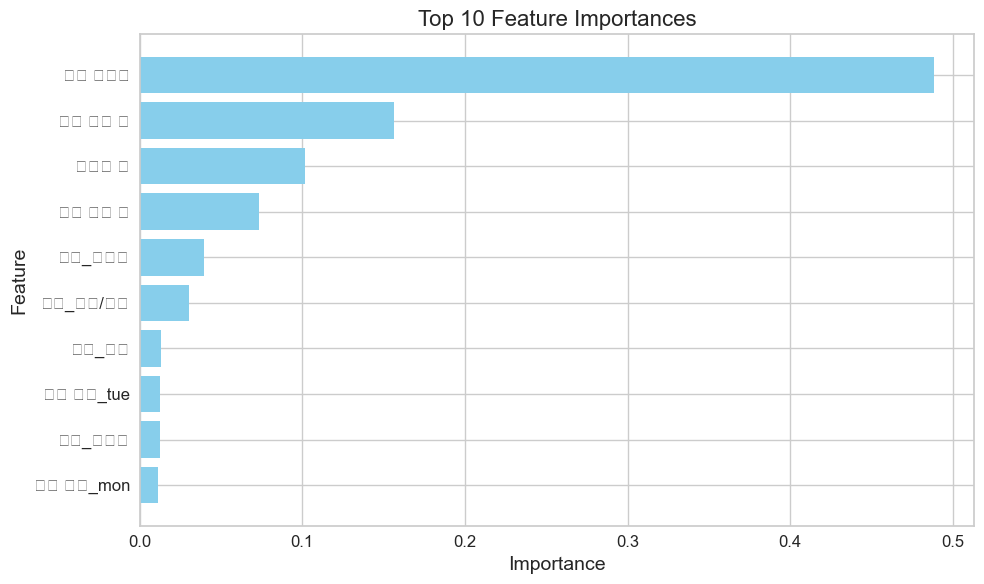

In [82]:
# Feature 중요도 시각화 함수
def plot_feature_importances(feature_importance_df, top_n=10):
    # 상위 top_n 개의 feature 선택
    top_features = feature_importance_df.head(top_n)

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.barh(top_features["Feature"], top_features["Importance"], color='skyblue')
    plt.gca().invert_yaxis()  # 상위 feature가 위로 오도록 역순 정렬
    plt.title(f"Top {top_n} Feature Importances", fontsize=16)
    plt.xlabel("Importance", fontsize=14)
    plt.ylabel("Feature", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# 시각화 호출
try:
    plot_feature_importances(feature_importance_df, top_n=10)
except NameError:
    print("Feature 중요도 데이터프레임이 없습니다. feature_importance_df를 확인하세요.")

In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# y_test와 y_test_transformed 가져오기
y_test = get_config("y_test")
y_test_transformed = get_config("y_test_transformed")

# 튜닝된 모델의 예측값
y_pred = tuned_rf_model.predict(get_config("X_test_transformed"))

# 성능 계산
mae = mean_absolute_error(y_test_transformed, y_pred)
mse = mean_squared_error(y_test_transformed, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test_transformed, y_pred)

# 결과 출력
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Absolute Error (MAE): 14.8335
Mean Squared Error (MSE): 354.6050
Root Mean Squared Error (RMSE): 18.8310
R-squared (R2): 0.5666


In [57]:
tuned_rf_model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='squared_error',
                      max_depth=None, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, monotonic_cst=None,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=6275, verbose=0, warm_start=False)>

 ### 5-2. 완결 웹툰 데이터 AUTOML

In [2]:
from pycaret.clustering import *
import pandas as pd

finish_webtoon = pd.read_csv('finish_webtoon_metadata.csv')
finish_webtoon

조회수 순위                웹툰 이름  웹툰 별점  \
0        20                 연애혁명   9.87   
1       100                마음의소리   9.86   
2        67                프리드로우   9.79   
3        89                 노블레스   9.62   
4        48            갓 오브 하이스쿨   9.64   
..      ...                  ...    ...   
670     699  유미의 세포들 외전 : 프로 직장인   9.96   
671     392                한줌물망초   9.96   
672    1492              아찔한 전남편   9.89   
673     308                  절벽귀   9.97   
674    1543                 엑스애쉬   9.87   

                                                 웹툰 링크   장르   웹툰 관심수   좋아요 수  \
0    https://comic.naver.com/webtoon/list?titleId=5...  드라마  2622242  387815   
1    https://comic.naver.com/webtoon/list?titleId=2...   개그  1750053  110500   
2    https://comic.naver.com/webtoon/list?titleId=5...  드라마  1575709  193124   
3    https://comic.naver.com/webtoon/list?titleId=2...  판타지  1371554   91983   
4    https://comic.naver.com/webtoon/list?titleId=3...  판타지  1371113  134823   
..                                                 ...  ...      ...     ...   
670  https://comic.naver.com/webtoon/list?titleId=7...  로맨스   100757  167064   
671  https://comic.naver.com/webtoon/list?titleId=4...  판타지   100152   16269   
672  https://comic.naver.com/webtoon/list?titleId=7...  로맨스   100123   38437   
673  https://comic.naver.com/webtoon/list?titleId=6...  스릴러   100073   40043   
674  https://comic.naver.com/webtoon/list?titleId=7...  판타지   100002   37386   

     별점 참여 수  전체 댓글 수  
0     713799   116333  
1     268305    89049  
2     528133   122728  
3     263859    82093  
4     261048    56406  
..       ...      ...  
670    90884    20049  
671   106969    12181  
672    35966     1541  
673    58427     4569  
674    37712     4654  

[675 rows x 9 columns]

In [3]:
# 환경설정
exp1 = setup(finish_webtoon, normalize = True, ignore_features = ['조회수 순위', '웹툰 이름', '웹툰 별점', '웹툰 링크', '별점 참여수']) 
exp1

In [4]:
# Clustering 모델 비교
models = ['kmeans', 'ap', 'meanshift', 'sc', 'hclust', 'dbscan', 'optics', 'birch', 'kmodes']

results = {}

# 모델 별 평가
for model_name in models:
    print(f"Training model: {model_name}")
    try:
        model = create_model(model_name)
        metrics = pull()  
        results[model_name] = metrics.iloc[-1].to_dict()  
    except Exception as e:
        print(f"Error training model {model_name}: {e}")

# 결과 데이터프레임 생성
results_df = pd.DataFrame(results).T

Training model: kmeans


Training model: ap


Training model: meanshift


Training model: sc


Training model: hclust


Training model: dbscan


Training model: optics


Training model: birch


Training model: kmodes
Error training model kmodes: Estimator kmodes not available. Please see docstring for list of available estimators.


In [5]:
# 결과 출력 -> 지표상으로는 sc가  적합? ap가 적합?
print("Clustering Model Comparison:")
results_df

Clustering Model Comparison:


Silhouette  Calinski-Harabasz  Davies-Bouldin  Homogeneity  \
kmeans         0.2414            82.4703          1.5804          0.0   
ap             0.4142           283.0100          0.7857          0.0   
meanshift      0.3695            75.9463          0.6878          0.0   
sc             0.4077            63.6141          0.6565          0.0   
hclust         0.2496            80.4250          1.9902          0.0   
dbscan         0.1585            31.5442          1.4386          0.0   
optics        -0.2132            23.0206          1.0633          0.0   
birch          0.3857            63.7333          0.9991          0.0   

           Rand Index  Completeness  
kmeans            0.0           0.0  
ap                0.0           0.0  
meanshift         0.0           0.0  
sc                0.0           0.0  
hclust            0.0           0.0  
dbscan            0.0           0.0  
optics            0.0           0.0  
birch             0.0           0.0

In [6]:
data = finish_webtoon.drop(['조회수 순위', '웹툰 이름', '웹툰 별점', '웹툰 링크', '별점 참여 수'], axis = 1)

# 장르 원핫인코딩
data = pd.get_dummies(data, columns=["장르"], prefix="장르")

data

웹툰 관심수   좋아요 수  전체 댓글 수  장르_감성  장르_개그  장르_드라마  장르_로맨스  장르_무협/사극  장르_스릴러  \
0    2622242  387815   116333  False  False    True   False     False   False   
1    1750053  110500    89049  False   True   False   False     False   False   
2    1575709  193124   122728  False  False    True   False     False   False   
3    1371554   91983    82093  False  False   False   False     False   False   
4    1371113  134823    56406  False  False   False   False     False   False   
..       ...     ...      ...    ...    ...     ...     ...       ...     ...   
670   100757  167064    20049  False  False   False    True     False   False   
671   100152   16269    12181  False  False   False   False     False   False   
672   100123   38437     1541  False  False   False    True     False   False   
673   100073   40043     4569  False  False   False   False     False    True   
674   100002   37386     4654  False  False   False   False     False   False   

     장르_스포츠  장르_액션  장르_일상  장르_판타지  
0     False  False  False   False  
1     False  False  False   False  
2     False  False  False   False  
3     False  False  False    True  
4     False  False  False    True  
..      ...    ...    ...     ...  
670   False  False  False   False  
671   False  False  False    True  
672   False  False  False   False  
673   False  False  False   False  
674   False  False  False    True  

[675 rows x 13 columns]

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# 기본 Spectral Clustering 모델 설정
base_model = SpectralClustering(assign_labels="kmeans", random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    "n_clusters": [3, 4, 5, 6, 7],  # 클러스터 개수
    "affinity": ["rbf", "nearest_neighbors"],  # affinity 방식
    "gamma": [0.1, 0.5, 1, 2],  # rbf affinity의 gamma 파라미터
    "n_neighbors": [5, 10, 20]  # nearest_neighbors affinity에서 이웃 수
}

# 사용자 정의 스코어링 함수: silhouette_score를 사용합니다.
def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    return silhouette_score(X, cluster_labels)

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=silhouette_scorer,
    cv=10,  # 데이터 분할
    verbose=2,
    n_jobs=-1  # 병렬 실행
)

# 하이퍼파라미터 튜닝 수행
grid_search.fit(data_scaled)

# 최적의 하이퍼파라미터와 점수 확인
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score:.4f}")

# 최적의 모델로 클러스터링 진행
best_model = grid_search.best_estimator_
clusters = best_model.fit_predict(data_scaled)

# 클러스터링 결과를 원본 데이터에 추가
data['Cluster'] = clusters
data

In [11]:
data['Cluster'].value_counts()

Cluster
0    674
1      1
Name: count, dtype: int64

In [10]:
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# 데이터 스케일링
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Affinity Propagation 모델 초기화
base_model = AffinityPropagation(random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    "damping": [0.5, 0.6, 0.7, 0.8, 0.9],  # 감쇠 계수
    "preference": [-50, -25, 0, 25, 50]   # 선호도
}

# 사용자 정의 스코어링 함수: silhouette_score를 사용합니다.
def silhouette_scorer(estimator, X):
    try:
        cluster_labels = estimator.fit_predict(X)
        if len(set(cluster_labels)) > 1:  # 클러스터가 1개가 아니면 점수 계산
            return silhouette_score(X, cluster_labels)
        else:
            return -1  # 클러스터가 1개인 경우 점수를 낮게 설정
    except Exception as e:
        print(f"Error during silhouette scoring: {e}")
        return -1

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=silhouette_scorer,
    cv=10,  # 데이터 분할
    verbose=2,
    n_jobs=-1  # 병렬 실행
)

# 하이퍼파라미터 튜닝 수행
grid_search.fit(data_scaled)

# 최적의 하이퍼파라미터와 점수 확인
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score:.4f}")

# 최적의 모델로 클러스터링 진행
best_model = grid_search.best_estimator_
clusters = best_model.fit_predict(data_scaled)

# 클러스터링 결과를 원본 데이터에 추가
data['Cluster'] = clusters


Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best Parameters: {'damping': 0.7, 'preference': -25}
Best Silhouette Score: 0.6731


In [11]:
data['Cluster'].value_counts()

Cluster
20    149
12     62
26     57
22     51
24     50
9      32
18     31
27     31
28     30
15     29
14     27
5      18
4      13
17     12
7      12
19     10
25     10
13      8
8       8
16      7
21      6
3       5
2       5
6       5
10      3
0       1
11      1
1       1
23      1
Name: count, dtype: int64

In [23]:
import pickle

# 학습된 모델을 .pkl 파일로 저장
model_filename = "best_ap_model.pkl"

with open(model_filename, "wb") as file:
    pickle.dump(best_model, file)

print(f"{model_filename} 모델 저장 완료")

# # 저장된 모델 불러오기
# with open(model_filename, "rb") as file:
#     loaded_model = pickle.load(file)

best_ap_model.pkl 모델 저장 완료


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [17]:
def visualize_clusters_pca(data_scaled, clusters):
    # PCA로 데이터 축소 (2D)
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)

    # 시각화
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label="Cluster")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Clustering Results with PCA")
    plt.show()

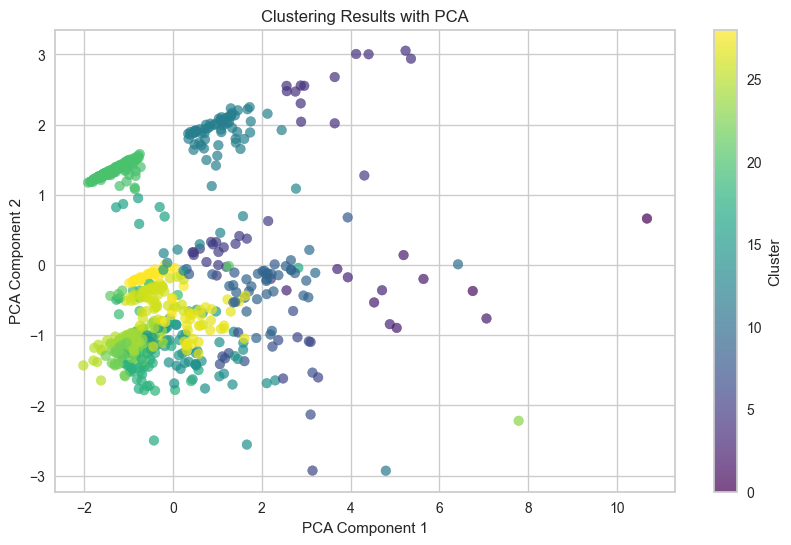

In [18]:
visualize_clusters_pca(data_scaled, clusters)

In [19]:
def visualize_clusters_tsne(data_scaled, clusters):
    # t-SNE로 데이터 축소 (2D)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    data_tsne = tsne.fit_transform(data_scaled)

    # 시각화
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label="Cluster")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title("Clustering Results with t-SNE")
    plt.show()

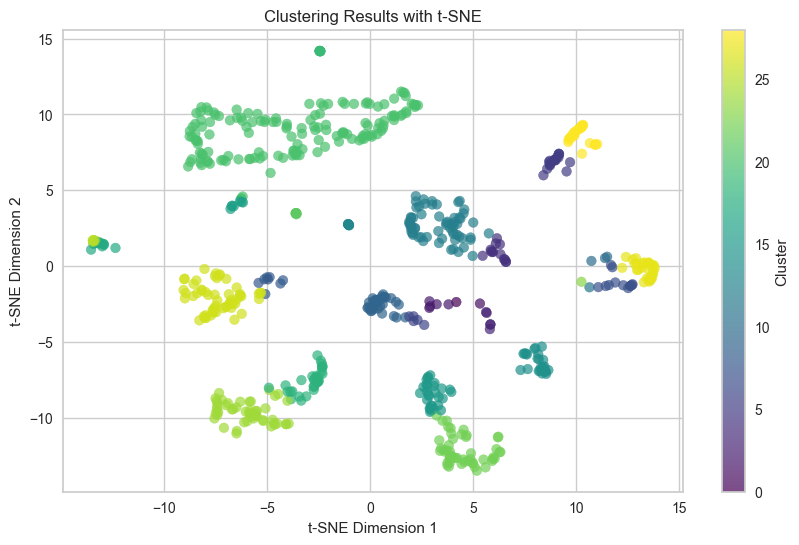

In [20]:
visualize_clusters_tsne(data_scaled, clusters)

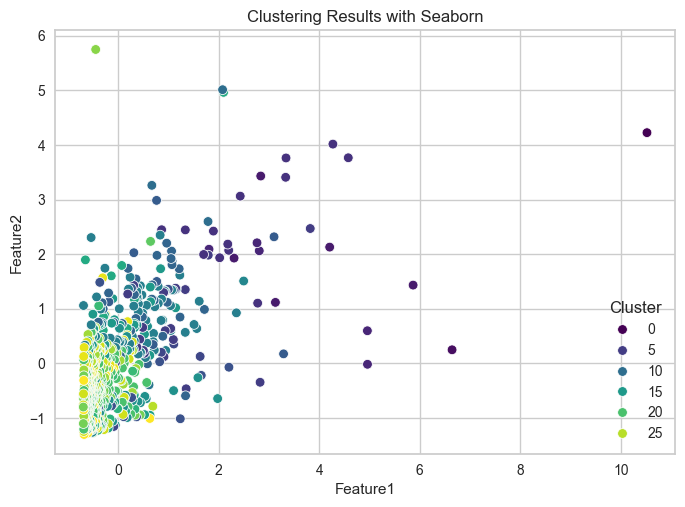

In [22]:
# 데이터프레임에 맞는 열 이름 자동 생성
columns = [f"Feature{i+1}" for i in range(data_scaled.shape[1])]

# 데이터프레임 생성
data_with_clusters = pd.DataFrame(data_scaled, columns=columns)

# 클러스터 결과 추가
data_with_clusters["Cluster"] = clusters

# Seaborn으로 산점도 그리기
sns.scatterplot(data=data_with_clusters, x="Feature1", y="Feature2", hue="Cluster", palette="viridis")
plt.title("Clustering Results with Seaborn")
plt.show()


In [15]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_clusters_3d(data_scaled, clusters):
    # PCA로 데이터 축소 (3D)
    pca = PCA(n_components=3)
    data_pca_3d = pca.fit_transform(data_scaled)

    # 3D 시각화
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2], c=clusters, cmap='viridis', alpha=0.7)
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")
    plt.colorbar(scatter, label="Cluster")
    plt.title("Clustering Results in 3D")
    plt.show()

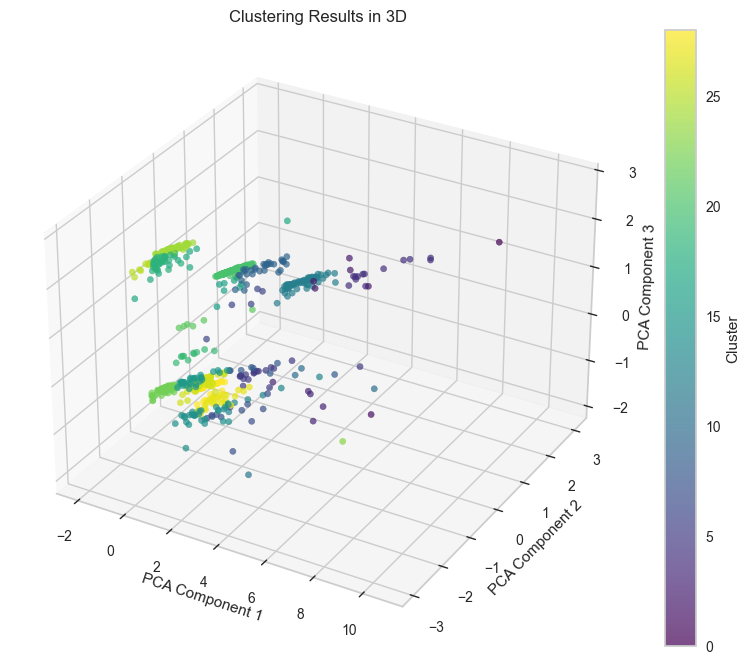

In [16]:
visualize_clusters_3d(data_scaled, clusters)

### 5-3. 마지막 AUTOML

In [2]:
import pandas as pd
from pycaret.classification import setup, compare_models, create_model, tune_model, evaluate_model, save_model, load_model, get_config

final = pd.read_csv('finished.csv')
final.head()

rating  episode_count  originality  work_count  previous_work     likes  \
0  0.941653       0.376167        False    0.021277          False  0.203096   
1  0.944895       0.396267        False    0.010638           True  0.300439   
2  0.991896       0.352477        False    0.106383           True  0.802448   
3  0.896272       0.172290        False    0.031915          False  0.842097   
4  0.949757       0.145011        False    0.127660           True  0.597130   

   rating_participants  comments_count  cluster  genre_감성  ...    PCA_24  \
0             0.376211        0.429757      7.0     False  ... -0.240986   
1             0.372155        0.294944      7.0     False  ... -0.251588   
2             0.300595        0.168407      7.0     False  ...  0.113373   
3             0.510231        0.215133      7.0     False  ...  0.201484   
4             0.280594        0.090449      7.0     False  ...  0.447820   

     PCA_25    PCA_26    PCA_27    PCA_28    PCA_29    PCA_30    PCA_31  \
0  0.581703  1.240549  0.609552 -0.010532  0.143946 -0.205709 -0.520007   
1  0.488433 -0.512301  1.466804 -0.784842  0.594936  0.645049 -0.905110   
2 -0.111749  1.611571 -0.818164 -1.729647  0.766621 -0.976648 -0.663925   
3 -1.341364  0.081646  0.715067  0.344415  0.762019 -0.036132  0.240119   
4  0.307167 -0.178069 -0.360370 -0.164934  0.392610 -1.003705  0.541822   

     PCA_32    PCA_33  
0 -0.662549 -0.162770  
1 -0.541915  0.613693  
2  0.292657 -1.177477  
3  0.139204 -0.472985  
4  0.102055  0.787917  

[5 rows x 336 columns]

In [3]:
# 환경설정
exp1 = setup(final, target = 'cluster', ignore_features = []) 
exp1

In [4]:
# 모델 비교
best_model = compare_models()

c:\Code\ML\env311\Lib\site-packages\pycaret\internal\pycaret_experiment\supervised_experiment.py:339: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_cols, subset=["TT (Sec)"])


In [8]:
# 모델 훈련
xgb_model = create_model('xgboost')

# 모델 평가
evaluate_model(xgb_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [9]:
# 파인튜닝
tuned_xgb_model = tune_model(xgb_model)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [10]:
# 1. PyCaret에서 최종 전처리된 학습 데이터 가져오기
processed_X = get_config("X_train_transformed")  # 최종 전처리된 학습 데이터
processed_features = processed_X.columns  # 최종 학습에 사용된 feature 이름

# 2. 모델에서 사용된 feature 중요도 가져오기
try:
    feature_importances = tuned_xgb_model.feature_importances_  # 모델에서 feature 중요도 가져오기
    if len(processed_features) != len(feature_importances):
        print("Feature 수와 중요도 배열 길이가 일치하지 않습니다. 일부 feature가 제거되었을 수 있습니다.")
    else:
        # 중요도와 feature 이름 매핑
        feature_importance_df = pd.DataFrame({
            "Feature": processed_features,
            "Importance": feature_importances
        }).sort_values(by="Importance", ascending=False)

        print("Feature 중요도:")
        print(feature_importance_df)
except AttributeError:
    print("이 모델은 feature_importances_ 속성을 제공하지 않습니다.")

Feature 중요도:
                 Feature  Importance
57                    공감    0.051125
6    rating_participants    0.046591
16              genre_일상    0.032114
53                   고인물    0.030457
163                 시리어스    0.028622
..                   ...         ...
158                  스릴러    0.000000
159                  스포츠    0.000000
160                스포츠성장    0.000000
161                 스핀오프    0.000000
167                아이돌연애    0.000000

[335 rows x 2 columns]


## 6. 댓글 감성분석

In [179]:
webtoon_emotion = pd.read_csv('webtoon_emotion.csv')
finish_emotion = pd.read_csv('finish_emotion.csv')

In [180]:
webtoon_emotion['emotion'].unique()

array(['기대감', '안타까움/실망', '없음', '불평/불만', '어이없음', '신기함/관심', '당황/난처', '기쁨',
       '놀람', '즐거움/신남', '감동/감탄', '깨달음', '의심/불신', '불안/걱정', '흐뭇함(귀여움/예쁨)',
       '슬픔', '불쌍함/연민', '아껴주는', '한심함', '화남/분노', '존경', '안심/신뢰', '고마움', '짜증',
       '경악', '재미없음', '우쭐댐/무시함', '환영/호의', '행복', '힘듦/지침', '증오/혐오', '공포/무서움',
       '비장함', '귀찮음', '절망', '부담/안_내킴', '지긋지긋'], dtype=object)

In [6]:
# 웹툰별로 감정 분포 확인
def analyze_emotions_by_webtoon(data, webtoon_column, emotion_column):
    """
    웹툰 이름별로 감정 분포를 확인합니다.

    Parameters:
        data (pd.DataFrame): 웹툰 데이터프레임
        webtoon_column (str): 웹툰 이름이 있는 열 이름
        emotion_column (str): 감정 결과가 있는 열 이름

    Returns:
        pd.DataFrame: 웹툰별 감정 분포 데이터프레임
    """
    # 웹툰별 감정 분포 계산
    emotion_summary = data.groupby(webtoon_column)[emotion_column].value_counts().unstack(fill_value=0)
    return emotion_summary

In [7]:
def calculate_emotion_ratios(data, webtoon_column, emotion_column):
    """
    웹툰별 특정 감정의 댓글 비율을 계산합니다.

    Parameters:
        data (pd.DataFrame): 웹툰 데이터프레임
        webtoon_column (str): 웹툰 이름이 있는 열 이름
        emotion_column (str): 감정 결과가 있는 열 이름

    Returns:
        pd.DataFrame: 웹툰별 특정 감정의 댓글 비율 데이터프레임
    """
    # 웹툰별 감정 분포 계산
    emotion_counts = data.groupby(webtoon_column)[emotion_column].value_counts().unstack(fill_value=0)

    # 총 댓글 수 계산
    emotion_counts["Total Comments"] = emotion_counts.sum(axis=1)

    # 비율 계산
    emotion_ratios = emotion_counts.div(emotion_counts["Total Comments"], axis=0)

    # 총 댓글 수는 다시 제거
    emotion_ratios.drop(columns=["Total Comments"], inplace=True)

    return emotion_ratios

### 1. 연재중 웹툰

In [183]:
# 웹툰별 감정 분석
emotion_summary = analyze_emotions_by_webtoon(webtoon_emotion, webtoon_column="웹툰 이름", emotion_column="emotion")

# 결과 확인
emotion_summary

emotion             감동/감탄  경악  고마움  공포/무서움  귀찮음  기대감  기쁨  깨달음  놀람  당황/난처  ...  \
웹툰 이름                                                                     ...   
108명의 그녀들               1   0    0       0    0    6   1    2   3      1  ...   
1825일                   3   0    0       0    0    4   2    0   1      1  ...   
1등급 싸움과외                7   0    0       0    0    6   1    0   2      0  ...   
1초                      4   0    2       0    0   12   1    0   1      3  ...   
205호 고은혜               10   1    0       0    0    9   0    0   6      0  ...   
...                   ...  ..  ...     ...  ...  ...  ..  ...  ..    ...  ...   
흔한 빙의물인 줄 알았다          10   0    0       0    0    6   0    1   2      0  ...   
흔한햄                     8   0    4       0    0    2   1   11   1      2  ...   
히든클래스 중력자로 최강을 노린다      1   0    0       0    0    4   0    0   1      1  ...   
히어로 킬러                  8   0    0       0    0    5   0    1   2      0  ...   
히어로메이커                  9   0    0       0    0    7   0    7   9      4  ...   

emotion             즐거움/신남  증오/혐오  지긋지긋  짜증  한심함  행복  화남/분노  환영/호의  \
웹툰 이름                                                                
108명의 그녀들                1      0     0   0    0   0      0      0   
1825일                    3      0     0   0    0   0      0      0   
1등급 싸움과외                 6      0     0   0    1   0      1      0   
1초                       2      0     0   1    0   0      2      0   
205호 고은혜                 9      0     0   0    1   0      3      0   
...                    ...    ...   ...  ..  ...  ..    ...    ...   
흔한 빙의물인 줄 알았다            1      1     0   6    0   0      4      0   
흔한햄                      6      0     0   2    0   1      0      1   
히든클래스 중력자로 최강을 노린다       3      0     0   1    0   0      1      0   
히어로 킬러                   7      1     0   3    3   0      1      0   
히어로메이커                  10      0     0   3    1   0      0      0   

emotion             흐뭇함(귀여움/예쁨)  힘듦/지침  
웹툰 이름                                   
108명의 그녀들                     1      0  
1825일                         3      0  
1등급 싸움과외                      0      0  
1초                            1      0  
205호 고은혜                      2      0  
...                         ...    ...  
흔한 빙의물인 줄 알았다                 3      0  
흔한햄                           2      3  
히든클래스 중력자로 최강을 노린다            0      0  
히어로 킬러                        0      0  
히어로메이커                        0      0  

[667 rows x 37 columns]

In [184]:
# 웹툰별 감정 비율 계산
emotion_ratios = calculate_emotion_ratios(webtoon_emotion, webtoon_column="웹툰 이름", emotion_column="emotion")

# 결과 확인
emotion_ratios

emotion                감동/감탄        경악       고마움  공포/무서움  귀찮음       기대감  \
웹툰 이름                                                                     
108명의 그녀들           0.020000  0.000000  0.000000     0.0  0.0  0.120000   
1825일               0.062500  0.000000  0.000000     0.0  0.0  0.083333   
1등급 싸움과외            0.170732  0.000000  0.000000     0.0  0.0  0.146341   
1초                  0.053333  0.000000  0.026667     0.0  0.0  0.160000   
205호 고은혜            0.147059  0.014706  0.000000     0.0  0.0  0.132353   
...                      ...       ...       ...     ...  ...       ...   
흔한 빙의물인 줄 알았다       0.144928  0.000000  0.000000     0.0  0.0  0.086957   
흔한햄                 0.106667  0.000000  0.053333     0.0  0.0  0.026667   
히든클래스 중력자로 최강을 노린다  0.027778  0.000000  0.000000     0.0  0.0  0.111111   
히어로 킬러              0.106667  0.000000  0.000000     0.0  0.0  0.066667   
히어로메이커              0.120000  0.000000  0.000000     0.0  0.0  0.093333   

emotion                   기쁨       깨달음        놀람     당황/난처  ...    즐거움/신남  \
웹툰 이름                                                       ...             
108명의 그녀들           0.020000  0.040000  0.060000  0.020000  ...  0.020000   
1825일               0.041667  0.000000  0.020833  0.020833  ...  0.062500   
1등급 싸움과외            0.024390  0.000000  0.048780  0.000000  ...  0.146341   
1초                  0.013333  0.000000  0.013333  0.040000  ...  0.026667   
205호 고은혜            0.000000  0.000000  0.088235  0.000000  ...  0.132353   
...                      ...       ...       ...       ...  ...       ...   
흔한 빙의물인 줄 알았다       0.000000  0.014493  0.028986  0.000000  ...  0.014493   
흔한햄                 0.013333  0.146667  0.013333  0.026667  ...  0.080000   
히든클래스 중력자로 최강을 노린다  0.000000  0.000000  0.027778  0.027778  ...  0.083333   
히어로 킬러              0.000000  0.013333  0.026667  0.000000  ...  0.093333   
히어로메이커              0.000000  0.093333  0.120000  0.053333  ...  0.133333   

emotion                증오/혐오  지긋지긋        짜증       한심함        행복     화남/분노  \
웹툰 이름                                                                        
108명의 그녀들           0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
1825일               0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
1등급 싸움과외            0.000000   0.0  0.000000  0.024390  0.000000  0.024390   
1초                  0.000000   0.0  0.013333  0.000000  0.000000  0.026667   
205호 고은혜            0.000000   0.0  0.000000  0.014706  0.000000  0.044118   
...                      ...   ...       ...       ...       ...       ...   
흔한 빙의물인 줄 알았다       0.014493   0.0  0.086957  0.000000  0.000000  0.057971   
흔한햄                 0.000000   0.0  0.026667  0.000000  0.013333  0.000000   
히든클래스 중력자로 최강을 노린다  0.000000   0.0  0.027778  0.000000  0.000000  0.027778   
히어로 킬러              0.013333   0.0  0.040000  0.040000  0.000000  0.013333   
히어로메이커              0.000000   0.0  0.040000  0.013333  0.000000  0.000000   

emotion                환영/호의  흐뭇함(귀여움/예쁨)  힘듦/지침  
웹툰 이름                                             
108명의 그녀들           0.000000     0.020000   0.00  
1825일               0.000000     0.062500   0.00  
1등급 싸움과외            0.000000     0.000000   0.00  
1초                  0.000000     0.013333   0.00  
205호 고은혜            0.000000     0.029412   0.00  
...                      ...          ...    ...  
흔한 빙의물인 줄 알았다       0.000000     0.043478   0.00  
흔한햄                 0.013333     0.026667   0.04  
히든클래스 중력자로 최강을 노린다  0.000000     0.000000   0.00  
히어로 킬러              0.000000     0.000000   0.00  
히어로메이커              0.000000     0.000000   0.00  

[667 rows x 37 columns]

In [185]:
emotion_ratios = emotion_ratios.reset_index()
emotion_ratios.rename(columns={"index": "webtoon_name"}, inplace=True)
emotion_ratios

emotion               웹툰 이름     감동/감탄        경악       고마움  공포/무서움  귀찮음  \
0                 108명의 그녀들  0.020000  0.000000  0.000000     0.0  0.0   
1                     1825일  0.062500  0.000000  0.000000     0.0  0.0   
2                  1등급 싸움과외  0.170732  0.000000  0.000000     0.0  0.0   
3                        1초  0.053333  0.000000  0.026667     0.0  0.0   
4                  205호 고은혜  0.147059  0.014706  0.000000     0.0  0.0   
..                      ...       ...       ...       ...     ...  ...   
662           흔한 빙의물인 줄 알았다  0.144928  0.000000  0.000000     0.0  0.0   
663                     흔한햄  0.106667  0.000000  0.053333     0.0  0.0   
664      히든클래스 중력자로 최강을 노린다  0.027778  0.000000  0.000000     0.0  0.0   
665                  히어로 킬러  0.106667  0.000000  0.000000     0.0  0.0   
666                  히어로메이커  0.120000  0.000000  0.000000     0.0  0.0   

emotion       기대감        기쁨       깨달음        놀람  ...    즐거움/신남     증오/혐오  \
0        0.120000  0.020000  0.040000  0.060000  ...  0.020000  0.000000   
1        0.083333  0.041667  0.000000  0.020833  ...  0.062500  0.000000   
2        0.146341  0.024390  0.000000  0.048780  ...  0.146341  0.000000   
3        0.160000  0.013333  0.000000  0.013333  ...  0.026667  0.000000   
4        0.132353  0.000000  0.000000  0.088235  ...  0.132353  0.000000   
..            ...       ...       ...       ...  ...       ...       ...   
662      0.086957  0.000000  0.014493  0.028986  ...  0.014493  0.014493   
663      0.026667  0.013333  0.146667  0.013333  ...  0.080000  0.000000   
664      0.111111  0.000000  0.000000  0.027778  ...  0.083333  0.000000   
665      0.066667  0.000000  0.013333  0.026667  ...  0.093333  0.013333   
666      0.093333  0.000000  0.093333  0.120000  ...  0.133333  0.000000   

emotion  지긋지긋        짜증       한심함        행복     화남/분노     환영/호의  흐뭇함(귀여움/예쁨)  \
0         0.0  0.000000  0.000000  0.000000  0.000000  0.000000     0.020000   
1         0.0  0.000000  0.000000  0.000000  0.000000  0.000000     0.062500   
2         0.0  0.000000  0.024390  0.000000  0.024390  0.000000     0.000000   
3         0.0  0.013333  0.000000  0.000000  0.026667  0.000000     0.013333   
4         0.0  0.000000  0.014706  0.000000  0.044118  0.000000     0.029412   
..        ...       ...       ...       ...       ...       ...          ...   
662       0.0  0.086957  0.000000  0.000000  0.057971  0.000000     0.043478   
663       0.0  0.026667  0.000000  0.013333  0.000000  0.013333     0.026667   
664       0.0  0.027778  0.000000  0.000000  0.027778  0.000000     0.000000   
665       0.0  0.040000  0.040000  0.000000  0.013333  0.000000     0.000000   
666       0.0  0.040000  0.013333  0.000000  0.000000  0.000000     0.000000   

emotion  힘듦/지침  
0         0.00  
1         0.00  
2         0.00  
3         0.00  
4         0.00  
..         ...  
662       0.00  
663       0.04  
664       0.00  
665       0.00  
666       0.00  

[667 rows x 38 columns]

### 2. 완결웹툰

In [67]:
# 웹툰별 감정 분석
finish_emotion_summary = analyze_emotions_by_webtoon(finish_emotion, webtoon_column="웹툰 이름", emotion_column="emotion")

# 결과 확인
finish_emotion_summary

emotion               감동/감탄  경악  고마움  공포/무서움  귀찮음  기대감  기쁨  깨달음  놀람  당황/난처  \
웹툰 이름                                                                        
10월 28일                   6   0    0       0    0    6   1    3   9      4   
12시네점심                   10   0    1       0    0   12   4    1   2      4   
2013 전설의고향               11   2    0       0    0    4   0    1   7      2   
2015 사이                  17   0    1       0    0    2   1    2   2      2   
2015 소름                   7   4    1       0    0    5   1    2   9      2   
...                     ...  ..  ...     ...  ...  ...  ..  ...  ..    ...   
후아유!                      6   0    0       0    0    4   0    1   7      4   
흑막 여주가 날 새엄마로 만들려고 해     10   1    0       0    0    3   0    3   2      1   
흑화한 노예남을 길들였다             7   1    2       0    0    4   0    1   2      3   
희란국연가                    24   0    0       0    0    7   2    2   9      0   
힙한남자                     13   0    0       0    0    3   0    1   3      2   

emotion               ...  즐거움/신남  증오/혐오  지긋지긋  짜증  한심함  행복  화남/분노  환영/호의  \
웹툰 이름                 ...                                                   
10월 28일               ...       3      0     0   1    1   0      1      2   
12시네점심                ...      11      0     0   1    1   0      0      0   
2013 전설의고향            ...       2      1     0   2    1   0      2      0   
2015 사이               ...       9      0     0   1    5   0      0      0   
2015 소름               ...       1      0     0   2    1   0      1      0   
...                   ...     ...    ...   ...  ..  ...  ..    ...    ...   
후아유!                  ...       3      0     0   1    1   0      0      0   
흑막 여주가 날 새엄마로 만들려고 해  ...      14      0     0   2    1   1      3      1   
흑화한 노예남을 길들였다         ...       7      0     0   2    3   0      3      0   
희란국연가                 ...       5      0     0   1    0   0      0      0   
힙한남자                  ...      12      0     0   3    1   0      3      2   

emotion               흐뭇함(귀여움/예쁨)  힘듦/지침  
웹툰 이름                                     
10월 28일                         0      1  
12시네점심                          1      0  
2013 전설의고향                      0      0  
2015 사이                         0      0  
2015 소름                         0      0  
...                           ...    ...  
후아유!                            2      0  
흑막 여주가 날 새엄마로 만들려고 해           11      0  
흑화한 노예남을 길들였다                   1      0  
희란국연가                           0      0  
힙한남자                            2      0  

[671 rows x 37 columns]

In [97]:
# 웹툰별 감정 비율 계산
finish_emotion_ratios = calculate_emotion_ratios(finish_emotion, webtoon_column="웹툰 이름", emotion_column="emotion")

# 결과 확인
finish_emotion_ratios


emotion                  감동/감탄        경악       고마움  공포/무서움  귀찮음       기대감  \
웹툰 이름                                                                       
10월 28일               0.080000  0.000000  0.000000     0.0  0.0  0.080000   
12시네점심                0.140845  0.000000  0.014085     0.0  0.0  0.169014   
2013 전설의고향            0.146667  0.026667  0.000000     0.0  0.0  0.053333   
2015 사이               0.226667  0.000000  0.013333     0.0  0.0  0.026667   
2015 소름               0.093333  0.053333  0.013333     0.0  0.0  0.066667   
...                        ...       ...       ...     ...  ...       ...   
후아유!                  0.080000  0.000000  0.000000     0.0  0.0  0.053333   
흑막 여주가 날 새엄마로 만들려고 해  0.133333  0.013333  0.000000     0.0  0.0  0.040000   
흑화한 노예남을 길들였다         0.095890  0.013699  0.027397     0.0  0.0  0.054795   
희란국연가                 0.320000  0.000000  0.000000     0.0  0.0  0.093333   
힙한남자                  0.175676  0.000000  0.000000     0.0  0.0  0.040541   

emotion                     기쁨       깨달음        놀람     당황/난처  ...    즐거움/신남  \
웹툰 이름                                                         ...             
10월 28일               0.013333  0.040000  0.120000  0.053333  ...  0.040000   
12시네점심                0.056338  0.014085  0.028169  0.056338  ...  0.154930   
2013 전설의고향            0.000000  0.013333  0.093333  0.026667  ...  0.026667   
2015 사이               0.013333  0.026667  0.026667  0.026667  ...  0.120000   
2015 소름               0.013333  0.026667  0.120000  0.026667  ...  0.013333   
...                        ...       ...       ...       ...  ...       ...   
후아유!                  0.000000  0.013333  0.093333  0.053333  ...  0.040000   
흑막 여주가 날 새엄마로 만들려고 해  0.000000  0.040000  0.026667  0.013333  ...  0.186667   
흑화한 노예남을 길들였다         0.000000  0.013699  0.027397  0.041096  ...  0.095890   
희란국연가                 0.026667  0.026667  0.120000  0.000000  ...  0.066667   
힙한남자                  0.000000  0.013514  0.040541  0.027027  ...  0.162162   

emotion                  증오/혐오  지긋지긋        짜증       한심함        행복     화남/분노  \
웹툰 이름                                                                          
10월 28일               0.000000   0.0  0.013333  0.013333  0.000000  0.013333   
12시네점심                0.000000   0.0  0.014085  0.014085  0.000000  0.000000   
2013 전설의고향            0.013333   0.0  0.026667  0.013333  0.000000  0.026667   
2015 사이               0.000000   0.0  0.013333  0.066667  0.000000  0.000000   
2015 소름               0.000000   0.0  0.026667  0.013333  0.000000  0.013333   
...                        ...   ...       ...       ...       ...       ...   
후아유!                  0.000000   0.0  0.013333  0.013333  0.000000  0.000000   
흑막 여주가 날 새엄마로 만들려고 해  0.000000   0.0  0.026667  0.013333  0.013333  0.040000   
흑화한 노예남을 길들였다         0.000000   0.0  0.027397  0.041096  0.000000  0.041096   
희란국연가                 0.000000   0.0  0.013333  0.000000  0.000000  0.000000   
힙한남자                  0.000000   0.0  0.040541  0.013514  0.000000  0.040541   

emotion                  환영/호의  흐뭇함(귀여움/예쁨)     힘듦/지침  
웹툰 이름                                                  
10월 28일               0.026667     0.000000  0.013333  
12시네점심                0.000000     0.014085  0.000000  
2013 전설의고향            0.000000     0.000000  0.000000  
2015 사이               0.000000     0.000000  0.000000  
2015 소름               0.000000     0.000000  0.000000  
...                        ...          ...       ...  
후아유!                  0.000000     0.026667  0.000000  
흑막 여주가 날 새엄마로 만들려고 해  0.013333     0.146667  0.000000  
흑화한 노예남을 길들였다         0.000000     0.013699  0.000000  
희란국연가                 0.000000     0.000000  0.000000  
힙한남자                  0.027027     0.027027  0.000000  

[671 rows x 37 columns]

In [98]:
finish_emotion_ratios = finish_emotion_ratios.reset_index()
finish_emotion_ratios.rename(columns={"index": "webtoon_name"}, inplace=True)
finish_emotion_ratios

emotion                 웹툰 이름     감동/감탄        경악       고마움  공포/무서움  귀찮음  \
0                     10월 28일  0.080000  0.000000  0.000000     0.0  0.0   
1                      12시네점심  0.140845  0.000000  0.014085     0.0  0.0   
2                  2013 전설의고향  0.146667  0.026667  0.000000     0.0  0.0   
3                     2015 사이  0.226667  0.000000  0.013333     0.0  0.0   
4                     2015 소름  0.093333  0.053333  0.013333     0.0  0.0   
..                        ...       ...       ...       ...     ...  ...   
666                      후아유!  0.080000  0.000000  0.000000     0.0  0.0   
667      흑막 여주가 날 새엄마로 만들려고 해  0.133333  0.013333  0.000000     0.0  0.0   
668             흑화한 노예남을 길들였다  0.095890  0.013699  0.027397     0.0  0.0   
669                     희란국연가  0.320000  0.000000  0.000000     0.0  0.0   
670                      힙한남자  0.175676  0.000000  0.000000     0.0  0.0   

emotion       기대감        기쁨       깨달음        놀람  ...    즐거움/신남     증오/혐오  \
0        0.080000  0.013333  0.040000  0.120000  ...  0.040000  0.000000   
1        0.169014  0.056338  0.014085  0.028169  ...  0.154930  0.000000   
2        0.053333  0.000000  0.013333  0.093333  ...  0.026667  0.013333   
3        0.026667  0.013333  0.026667  0.026667  ...  0.120000  0.000000   
4        0.066667  0.013333  0.026667  0.120000  ...  0.013333  0.000000   
..            ...       ...       ...       ...  ...       ...       ...   
666      0.053333  0.000000  0.013333  0.093333  ...  0.040000  0.000000   
667      0.040000  0.000000  0.040000  0.026667  ...  0.186667  0.000000   
668      0.054795  0.000000  0.013699  0.027397  ...  0.095890  0.000000   
669      0.093333  0.026667  0.026667  0.120000  ...  0.066667  0.000000   
670      0.040541  0.000000  0.013514  0.040541  ...  0.162162  0.000000   

emotion  지긋지긋        짜증       한심함        행복     화남/분노     환영/호의  흐뭇함(귀여움/예쁨)  \
0         0.0  0.013333  0.013333  0.000000  0.013333  0.026667     0.000000   
1         0.0  0.014085  0.014085  0.000000  0.000000  0.000000     0.014085   
2         0.0  0.026667  0.013333  0.000000  0.026667  0.000000     0.000000   
3         0.0  0.013333  0.066667  0.000000  0.000000  0.000000     0.000000   
4         0.0  0.026667  0.013333  0.000000  0.013333  0.000000     0.000000   
..        ...       ...       ...       ...       ...       ...          ...   
666       0.0  0.013333  0.013333  0.000000  0.000000  0.000000     0.026667   
667       0.0  0.026667  0.013333  0.013333  0.040000  0.013333     0.146667   
668       0.0  0.027397  0.041096  0.000000  0.041096  0.000000     0.013699   
669       0.0  0.013333  0.000000  0.000000  0.000000  0.000000     0.000000   
670       0.0  0.040541  0.013514  0.000000  0.040541  0.027027     0.027027   

emotion     힘듦/지침  
0        0.013333  
1        0.000000  
2        0.000000  
3        0.000000  
4        0.000000  
..            ...  
666      0.000000  
667      0.000000  
668      0.000000  
669      0.000000  
670      0.000000  

[671 rows x 38 columns]

### 3. test 데이터 병합

In [4]:
test = pd.read_csv('test.csv')
test2 = pd.read_csv('test_emotion.csv')

In [8]:
# 웹툰별 감정 분석
test_emotion_summary = analyze_emotions_by_webtoon(test2, webtoon_column="webtoon_name", emotion_column="emotion")

# 결과 확인
test_emotion_summary

emotion            감동/감탄  놀람  당황/난처  불쌍함/연민  불안/걱정  불평/불만  슬픔  신기함/관심  아껴주는  \
webtoon_name                                                                  
송이연 50살, 이혼 한 달 차      7   1      1       1      2      1   8       1     4   

emotion            안심/신뢰  안타까움/실망  어이없음  의심/불신  증오/혐오  한심함  화남/분노  
webtoon_name                                                       
송이연 50살, 이혼 한 달 차      1       17     8      1      2    2      3

In [16]:
# 웹툰별 감정 비율 계산
test_emotion_ratios = calculate_emotion_ratios(test2, webtoon_column="webtoon_name", emotion_column="emotion")

# 결과 확인
test_emotion_ratios

emotion               감동/감탄        놀람     당황/난처    불쌍함/연민     불안/걱정     불평/불만  \
webtoon_name                                                                    
송이연 50살, 이혼 한 달 차  0.116667  0.016667  0.016667  0.016667  0.033333  0.016667   

emotion                  슬픔    신기함/관심      아껴주는     안심/신뢰   안타까움/실망      어이없음  \
webtoon_name                                                                    
송이연 50살, 이혼 한 달 차  0.133333  0.016667  0.066667  0.016667  0.283333  0.133333   

emotion               의심/불신     증오/혐오       한심함  화남/분노  
webtoon_name                                            
송이연 50살, 이혼 한 달 차  0.016667  0.033333  0.033333   0.05

In [17]:
test_emotion_ratios

emotion               감동/감탄        놀람     당황/난처    불쌍함/연민     불안/걱정     불평/불만  \
webtoon_name                                                                    
송이연 50살, 이혼 한 달 차  0.116667  0.016667  0.016667  0.016667  0.033333  0.016667   

emotion                  슬픔    신기함/관심      아껴주는     안심/신뢰   안타까움/실망      어이없음  \
webtoon_name                                                                    
송이연 50살, 이혼 한 달 차  0.133333  0.016667  0.066667  0.016667  0.283333  0.133333   

emotion               의심/불신     증오/혐오       한심함  화남/분노  
webtoon_name                                            
송이연 50살, 이혼 한 달 차  0.016667  0.033333  0.033333   0.05

# 7. 최종 데이터 병합

In [25]:
def merge_with_dataframe(original_df, emotion_ratios_df, key_column, output_file):
    """
    두 데이터프레임을 특정 키를 기준으로 병합하고 결과를 저장합니다.

    Parameters:
        original_df (pd.DataFrame): 원본 데이터프레임
        emotion_ratios_df (pd.DataFrame): 감정 비율 데이터프레임
        key_column (str): 병합에 사용할 키 열 이름
        output_file (str): 병합 결과를 저장할 파일 이름

    Returns:
        pd.DataFrame: 병합된 데이터프레임
    """
    # 병합 키 열 이름 변경
    if "웹툰 이름" in emotion_ratios_df.columns:
        emotion_ratios_df = emotion_ratios_df.rename(columns={"웹툰 이름": "webtoon_name"})

    # 병합 수행
    merged_df = pd.merge(original_df, emotion_ratios_df, on=key_column, how="left")

    # 결과 저장
    merged_df['cluster'] = []
    merged_df.to_csv(output_file, index=False, encoding="utf-8-sig")
    print(f"병합 결과가 '{output_file}' 파일에 저장되었습니다.")

    return merged_df

## 7-1. 학습데이터 병합(완결 웹툰) 

In [3]:
finish_md = pd.read_csv('finish_webtoon_metadata.csv')

In [59]:
finish_md

rank_popularity         webtoon_name  rating  \
0                 20                 연애혁명    9.87   
1                100                마음의소리    9.86   
2                 67                프리드로우    9.79   
3                 89                 노블레스    9.62   
4                 48            갓 오브 하이스쿨    9.64   
..               ...                  ...     ...   
670              699  유미의 세포들 외전 : 프로 직장인    9.96   
671              392                한줌물망초    9.96   
672             1492              아찔한 전남편    9.89   
673              308                  절벽귀    9.97   
674             1543                 엑스애쉬    9.87   

                                                  link genre  interest  \
0    https://comic.naver.com/webtoon/list?titleId=5...   드라마   2622242   
1    https://comic.naver.com/webtoon/list?titleId=2...    개그   1750053   
2    https://comic.naver.com/webtoon/list?titleId=5...   드라마   1575709   
3    https://comic.naver.com/webtoon/list?titleId=2...   판타지   1371554   
4    https://comic.naver.com/webtoon/list?titleId=3...   판타지   1371113   
..                                                 ...   ...       ...   
670  https://comic.naver.com/webtoon/list?titleId=7...   로맨스    100757   
671  https://comic.naver.com/webtoon/list?titleId=4...   판타지    100152   
672  https://comic.naver.com/webtoon/list?titleId=7...   로맨스    100123   
673  https://comic.naver.com/webtoon/list?titleId=6...   스릴러    100073   
674  https://comic.naver.com/webtoon/list?titleId=7...   판타지    100002   

    episode_count  originality              authors  work_count  \
0             442            0              ['232']    2.000000   
1            1238            0               ['조석']   18.000000   
2             516            0              ['전선욱']    3.000000   
3             545            0       ['손제호', '이광수']    3.500000   
4             573            0              ['박용제']    2.000000   
..            ...          ...                  ...         ...   
670             6            0              ['이동건']   11.000000   
671            96            0              ['혜진양']    5.000000   
672           101            1  ['마풍각', '여백', '별규']    1.666667   
673             8            0              ['오성대']    4.000000   
674           108            0       ['김세훈', '이광수']    4.500000   

     previous_work   likes  rating_participants  comments_count  
0                0  387815               713799          116333  
1                0  110500               268305           89049  
2                0  193124               528133          122728  
3                0   91983               263859           82093  
4                1  134823               261048           56406  
..             ...     ...                  ...             ...  
670              1  167064                90884           20049  
671              1   16269               106969           12181  
672              0   38437                35966            1541  
673              1   40043                58427            4569  
674              1   37386                37712            4654  

[675 rows x 14 columns]

In [99]:
merge_emotion_ratios_with_dataframe(
    original_df = finish_md, 
    emotion_ratios_df = finish_emotion_ratios, 
    key_column = "webtoon_name",  # 병합할 키
    output_file="train.csv"  # 저장할 파일 이름
)

병합 결과가 'train.csv' 파일에 저장되었습니다.


rank_popularity         webtoon_name  rating  \
0                 20                 연애혁명    9.87   
1                100                마음의소리    9.86   
2                 67                프리드로우    9.79   
3                 89                 노블레스    9.62   
4                 48            갓 오브 하이스쿨    9.64   
..               ...                  ...     ...   
670              699  유미의 세포들 외전 : 프로 직장인    9.96   
671              392                한줌물망초    9.96   
672             1492              아찔한 전남편    9.89   
673              308                  절벽귀    9.97   
674             1543                 엑스애쉬    9.87   

                                                  link genre  interest  \
0    https://comic.naver.com/webtoon/list?titleId=5...   드라마   2622242   
1    https://comic.naver.com/webtoon/list?titleId=2...    개그   1750053   
2    https://comic.naver.com/webtoon/list?titleId=5...   드라마   1575709   
3    https://comic.naver.com/webtoon/list?titleId=2...   판타지   1371554   
4    https://comic.naver.com/webtoon/list?titleId=3...   판타지   1371113   
..                                                 ...   ...       ...   
670  https://comic.naver.com/webtoon/list?titleId=7...   로맨스    100757   
671  https://comic.naver.com/webtoon/list?titleId=4...   판타지    100152   
672  https://comic.naver.com/webtoon/list?titleId=7...   로맨스    100123   
673  https://comic.naver.com/webtoon/list?titleId=6...   스릴러    100073   
674  https://comic.naver.com/webtoon/list?titleId=7...   판타지    100002   

    episode_count  originality              authors  work_count  ...  \
0             442            0              ['232']    2.000000  ...   
1            1238            0               ['조석']   18.000000  ...   
2             516            0              ['전선욱']    3.000000  ...   
3             545            0       ['손제호', '이광수']    3.500000  ...   
4             573            0              ['박용제']    2.000000  ...   
..            ...          ...                  ...         ...  ...   
670             6            0              ['이동건']   11.000000  ...   
671            96            0              ['혜진양']    5.000000  ...   
672           101            1  ['마풍각', '여백', '별규']    1.666667  ...   
673             8            0              ['오성대']    4.000000  ...   
674           108            0       ['김세훈', '이광수']    4.500000  ...   

       즐거움/신남     증오/혐오  지긋지긋        짜증       한심함        행복     화남/분노  \
0    0.160000  0.000000   0.0  0.040000  0.013333  0.013333  0.000000   
1    0.093333  0.013333   0.0  0.013333  0.000000  0.000000  0.000000   
2    0.080000  0.000000   0.0  0.026667  0.000000  0.000000  0.000000   
3    0.133333  0.000000   0.0  0.026667  0.000000  0.000000  0.000000   
4    0.106667  0.000000   0.0  0.000000  0.013333  0.000000  0.000000   
..        ...       ...   ...       ...       ...       ...       ...   
670  0.186667  0.000000   0.0  0.013333  0.013333  0.026667  0.013333   
671  0.080000  0.000000   0.0  0.080000  0.000000  0.000000  0.013333   
672  0.100000  0.000000   0.0  0.042857  0.000000  0.000000  0.028571   
673  0.133333  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
674  0.081633  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   

        환영/호의  흐뭇함(귀여움/예쁨)  힘듦/지침  
0    0.013333     0.000000    0.0  
1    0.000000     0.000000    0.0  
2    0.026667     0.000000    0.0  
3    0.000000     0.000000    0.0  
4    0.000000     0.013333    0.0  
..        ...          ...    ...  
670  0.000000     0.013333    0.0  
671  0.000000     0.013333    0.0  
672  0.014286     0.028571    0.0  
673  0.000000     0.000000    0.0  
674  0.000000     0.000000    0.0  

[675 rows x 51 columns]

## 7-2. 평가데이터 병합(연재중)

In [177]:
webtoon_md = pd.read_csv('webtoon_metadata.csv')

In [178]:
webtoon_md

webtoon_name  rating  \
0                      참교육    9.89   
1                     환생천마    9.95   
2                   똑 닮은 딸    9.98   
3                     신의 탑    9.84   
4           어느날 갑자기 가슴이 커짐    9.81   
..                     ...     ...   
662  밤필드의 아이들 by DARK MOON    9.84   
663             노래 못 하는 남자    9.92   
664      마섹남 - 마술하는 섹시한 남자    9.89   
665           주인공의 주식을 팝니다    9.84   
666                  프린키피아    9.84   

                                                  link  day  genre  interest  \
0    https://comic.naver.com/webtoon/list?titleId=7...  mon     액션    952557   
1    https://comic.naver.com/webtoon/list?titleId=8...  mon  무협/사극    153632   
2    https://comic.naver.com/webtoon/list?titleId=7...  mon    스릴러    673334   
3    https://comic.naver.com/webtoon/list?titleId=1...  mon    판타지   1909208   
4    https://comic.naver.com/webtoon/list?titleId=8...  mon     일상     70824   
..                                                 ...  ...    ...       ...   
662  https://comic.naver.com/webtoon/list?titleId=8...  sun    판타지     49934   
663  https://comic.naver.com/webtoon/list?titleId=8...  sun    로맨스     22545   
664  https://comic.naver.com/webtoon/list?titleId=7...  sun    로맨스     54426   
665  https://comic.naver.com/webtoon/list?titleId=8...  sun    로맨스     57199   
666  https://comic.naver.com/webtoon/list?titleId=8...  sun    판타지     23203   

     rank_day episode_count  originality               authors  work_count  \
0           1           179            0        ['한가람', '채용택']    2.500000   
1           2            52            1   ['부겸', '장영훈', 'JP']    4.333333   
2           3           142            0                ['이담']    1.000000   
3           4           653            0               ['SIU']    1.000000   
4           5            25            0               ['물렁이']    1.000000   
..        ...           ...          ...                   ...         ...   
662        91            48            0              ['HYBE']    7.000000   
663        92            57            0         ['재은', '이해금']    1.000000   
664        93            90            1  ['랑또', '육시몬', '티르스']    4.000000   
665        94            96            1   ['목감기', '가얌', '50']    1.333333   
666        95            66            0         ['버튼', '한경찰']    3.500000   

     previous_work   likes  rating_participants  comments_count  
0              1.0  257327               232678           22417  
1              1.0   29817                37419            2213  
2              0.0  160967               133750            6172  
3              0.0  262687               476327          131963  
4              0.0   48787                30052            6003  
..             ...     ...                  ...             ...  
662            1.0   11676                 7777            2513  
663            0.0    4658                 3955             282  
664            1.0   21651                17845            1257  
665            1.0   27970                21482            1275  
666            1.0    9460                 9436             680  

[667 rows x 15 columns]

In [187]:
merge_emotion_ratios_with_dataframe(
    original_df = webtoon_md, 
    emotion_ratios_df = emotion_ratios, 
    key_column = "webtoon_name",  # 병합할 키
    output_file = "validate.csv"  # 저장할 파일 이름
)

병합 결과가 'validate.csv' 파일에 저장되었습니다.


webtoon_name  rating  \
0                      참교육    9.89   
1                     환생천마    9.95   
2                   똑 닮은 딸    9.98   
3                     신의 탑    9.84   
4           어느날 갑자기 가슴이 커짐    9.81   
..                     ...     ...   
662  밤필드의 아이들 by DARK MOON    9.84   
663             노래 못 하는 남자    9.92   
664      마섹남 - 마술하는 섹시한 남자    9.89   
665           주인공의 주식을 팝니다    9.84   
666                  프린키피아    9.84   

                                                  link  day  genre  interest  \
0    https://comic.naver.com/webtoon/list?titleId=7...  mon     액션    952557   
1    https://comic.naver.com/webtoon/list?titleId=8...  mon  무협/사극    153632   
2    https://comic.naver.com/webtoon/list?titleId=7...  mon    스릴러    673334   
3    https://comic.naver.com/webtoon/list?titleId=1...  mon    판타지   1909208   
4    https://comic.naver.com/webtoon/list?titleId=8...  mon     일상     70824   
..                                                 ...  ...    ...       ...   
662  https://comic.naver.com/webtoon/list?titleId=8...  sun    판타지     49934   
663  https://comic.naver.com/webtoon/list?titleId=8...  sun    로맨스     22545   
664  https://comic.naver.com/webtoon/list?titleId=7...  sun    로맨스     54426   
665  https://comic.naver.com/webtoon/list?titleId=8...  sun    로맨스     57199   
666  https://comic.naver.com/webtoon/list?titleId=8...  sun    판타지     23203   

     rank_day episode_count  originality               authors  ...    즐거움/신남  \
0           1           179            0        ['한가람', '채용택']  ...  0.026667   
1           2            52            1   ['부겸', '장영훈', 'JP']  ...  0.341463   
2           3           142            0                ['이담']  ...  0.053333   
3           4           653            0               ['SIU']  ...  0.133333   
4           5            25            0               ['물렁이']  ...  0.066667   
..        ...           ...          ...                   ...  ...       ...   
662        91            48            0              ['HYBE']  ...  0.112676   
663        92            57            0         ['재은', '이해금']  ...  0.000000   
664        93            90            1  ['랑또', '육시몬', '티르스']  ...  0.188406   
665        94            96            1   ['목감기', '가얌', '50']  ...  0.160714   
666        95            66            0         ['버튼', '한경찰']  ...  0.015152   

        증오/혐오      지긋지긋        짜증       한심함   행복     화남/분노     환영/호의  \
0    0.013333  0.013333  0.173333  0.026667  0.0  0.053333  0.000000   
1    0.024390  0.000000  0.024390  0.000000  0.0  0.024390  0.024390   
2    0.000000  0.000000  0.013333  0.026667  0.0  0.040000  0.000000   
3    0.000000  0.000000  0.080000  0.013333  0.0  0.013333  0.000000   
4    0.000000  0.000000  0.026667  0.026667  0.0  0.026667  0.013333   
..        ...       ...       ...       ...  ...       ...       ...   
662  0.000000  0.000000  0.014085  0.000000  0.0  0.000000  0.000000   
663  0.000000  0.000000  0.032258  0.000000  0.0  0.032258  0.000000   
664  0.000000  0.000000  0.014493  0.000000  0.0  0.014493  0.014493   
665  0.000000  0.000000  0.000000  0.000000  0.0  0.017857  0.000000   
666  0.000000  0.000000  0.030303  0.015152  0.0  0.000000  0.000000   

     흐뭇함(귀여움/예쁨)  힘듦/지침  
0       0.000000    0.0  
1       0.000000    0.0  
2       0.000000    0.0  
3       0.040000    0.0  
4       0.000000    0.0  
..           ...    ...  
662     0.084507    0.0  
663     0.064516    0.0  
664     0.028986    0.0  
665     0.071429    0.0  
666     0.045455    0.0  

[667 rows x 52 columns]

In [29]:
webtoon_info = pd.read_csv('웹툰 태그,인포.csv')
labels = pd.read_csv('labels_included.csv')

webtoon_info

Unnamed: 0           웹툰 이름  웹툰 별점  \
0              0             참교육   9.89   
1              1            환생천마   9.95   
2              2          똑 닮은 딸   9.98   
3              3            신의 탑   9.84   
4              4  어느날 갑자기 가슴이 커짐   9.81   
...          ...             ...    ...   
3056        2362         블로섬 데이즈   9.88   
3057        2363        메이드 인 헤븐   9.79   
3058        2364            치렐루야   9.16   
3059        2365  아마데우스(Amadeus)   8.59   
3060        2366      종이비행기를 날리면   8.42   

                                                  웹툰 링크 연재 요일     장르  \
0     https://comic.naver.com/webtoon/list?titleId=7...   mon     액션   
1     https://comic.naver.com/webtoon/list?titleId=8...   mon  무협/사극   
2     https://comic.naver.com/webtoon/list?titleId=7...   mon    스릴러   
3     https://comic.naver.com/webtoon/list?titleId=1...   mon    판타지   
4     https://comic.naver.com/webtoon/list?titleId=8...   mon     일상   
...                                                 ...   ...    ...   
3056  https://comic.naver.com/webtoon/list?titleId=8...   NaN    로맨스   
3057  https://comic.naver.com/webtoon/list?titleId=8...   NaN    스릴러   
3058  https://comic.naver.com/webtoon/list?titleId=8...   NaN     개그   
3059  https://comic.naver.com/webtoon/list?titleId=8...   NaN    드라마   
3060  https://comic.naver.com/webtoon/list?titleId=8...   NaN    로맨스   

         웹툰 관심수  요일별 순위   회차  원작 유무                 작가이름      작품 수  전작 유무  \
0       952,557     1.0  179    0.0       ['한가람', '채용택']  2.500000    1.0   
1       153,632     2.0   52    1.0  ['부겸', '장영훈', 'JP']  4.333333    1.0   
2       673,334     3.0  142    0.0               ['이담']  1.000000    0.0   
3     1,909,208     4.0  653    0.0              ['SIU']  1.000000    0.0   
4        70,824     5.0   25    0.0              ['물렁이']  1.000000    0.0   
...         ...     ...  ...    ...                  ...       ...    ...   
3056        794     NaN  NaN    NaN                  NaN       NaN    NaN   
3057        776     NaN  NaN    NaN                  NaN       NaN    NaN   
3058        279     NaN  NaN    NaN                  NaN       NaN    NaN   
3059      1,774     NaN  NaN    NaN                  NaN       NaN    NaN   
3060        431     NaN  NaN    NaN                  NaN       NaN    NaN   

                                                    tag  \
0     ['사이다', '학원액션', '자극적인', '사회고발', '참교육', '블루스트링'...   
1     ['사이다', '동양', '환생', '액션', '고인물', '환골탈태', '동양풍판...   
2     ['명작', '고자극드라마', '자극적인', '시리어스', '미스터리', '범죄',...   
3     ['명작', '이능력', '배틀', '모험', '전쟁', '액션', '성장물', '...   
4                             ['감성적인', '공감', '하이퍼리얼리즘']   
...                                                 ...   
3056                           ['성장물', '연상연하', '완결로맨스']   
3057                     ['미스터리', '공포', '역사물', '완결스릴러']   
3058                      ['개그', '힐링', '음식&요리', '완결개그']   
3059                                          ['완결드라마']   
3060                          ['첫사랑', '감성드라마', '완결로맨스']   

                                                   info  
0     무너진 교권을 지키기 위해 교권보호국 소속 나화진의 참교육이 시작된다!\n<부활남>...  
1     철혈의 맹주, 강호의 절대자 '천하진'. 가문의 수치라 불리는 망나니 '벽리단'의 ...  
2     '우리 엄마가 살인마인 것 같다.' \n성적 우수, 품행 단정, 모범적인 자식인 길...  
3       자신의 모든 것이었던 소녀를 쫓아 탑에 들어온 소년\n그리고 그런 소년을 시험하는 탑  
4     이것은 행운인가 불운인가? 어느날 갑자기 예상치 못하게 가슴 사이즈가 A컵에서 H컵...  
...                                                 ...  
3056  [신임 교사 송지원과 이웃사촌 고등학생 장산하의 풋풋한 순정 만화]\n\n기간제 신...  
3057  [빽빽한 숲 깊숙한 곳에 자리 잡은 미스터리한 저택에서 펼쳐지는 살인]\n\n고아원...  
3058  [와! 치킨! 맛있겠다! 오, 쟤네 잘생겼다! 어? 근데 이거 개그만화냐?!]\n\...  
3059  큰 고민 없고 밝은 성격의 평범한 학생, 시아.\n어느 날 갑자기 살인 연극에 참여...  
3060  29살, 연애 한번 못 해본 모태솔로 '수연' 그 원인은 바로 첫사랑 실패?!\n"...  

[3061 rows x 15 columns]

In [30]:
labels.drop(['rank_popularity', 'day', 'rank_day', 'scaled_rank', 'scaled_interest'], axis = 1, inplace = True)

In [31]:
labels

webtoon_name  rating  \
0                  노블레스    9.62   
1             갓 오브 하이스쿨    9.64   
2               유미의 세포들    9.93   
3                  여신강림    9.34   
4                  싸움독학    9.67   
...                 ...     ...   
1202         노래 못 하는 남자    9.92   
1203  마섹남 - 마술하는 섹시한 남자    9.89   
1204       주인공의 주식을 팝니다    9.84   
1205              프린키피아    9.84   
1206              프린키피아    9.84   

                                                   link genre  interest  \
0     https://comic.naver.com/webtoon/list?titleId=2...   판타지   1371554   
1     https://comic.naver.com/webtoon/list?titleId=3...   판타지   1371113   
2     https://comic.naver.com/webtoon/list?titleId=6...   로맨스   1285627   
3     https://comic.naver.com/webtoon/list?titleId=7...   로맨스   1216760   
4     https://comic.naver.com/webtoon/list?titleId=7...    액션   1115468   
...                                                 ...   ...       ...   
1202  https://comic.naver.com/webtoon/list?titleId=8...   로맨스     22545   
1203  https://comic.naver.com/webtoon/list?titleId=7...   로맨스     54426   
1204  https://comic.naver.com/webtoon/list?titleId=8...   로맨스     57199   
1205  https://comic.naver.com/webtoon/list?titleId=8...   판타지     23203   
1206  https://comic.naver.com/webtoon/list?titleId=8...   판타지     23203   

      episode_count  originality               authors  work_count  \
0               545            0        ['손제호', '이광수']    3.500000   
1               573            0               ['박용제']    2.000000   
2               512            0               ['이동건']   11.000000   
3               261            0               ['야옹이']    4.000000   
4               223            0        ['박만사', '김정현']   13.500000   
...             ...          ...                   ...         ...   
1202             57            0         ['재은', '이해금']    1.000000   
1203             90            1  ['랑또', '육시몬', '티르스']    4.000000   
1204             96            1   ['목감기', '가얌', '50']    1.333333   
1205             66            0         ['버튼', '한경찰']    3.500000   
1206             66            0         ['버튼', '한경찰']    3.500000   

      previous_work  ...     증오/혐오  지긋지긋        짜증       한심함   행복     화남/분노  \
0               0.0  ...  0.000000   0.0  0.026667  0.000000  0.0  0.000000   
1               1.0  ...  0.000000   0.0  0.000000  0.013333  0.0  0.000000   
2               1.0  ...  0.000000   0.0  0.106667  0.026667  0.0  0.066667   
3               0.0  ...  0.000000   0.0  0.066667  0.040000  0.0  0.000000   
4               1.0  ...  0.013333   0.0  0.000000  0.000000  0.0  0.013333   
...             ...  ...       ...   ...       ...       ...  ...       ...   
1202            0.0  ...  0.000000   0.0  0.032258  0.000000  0.0  0.032258   
1203            1.0  ...  0.000000   0.0  0.014493  0.000000  0.0  0.014493   
1204            1.0  ...  0.000000   0.0  0.000000  0.000000  0.0  0.017857   
1205            1.0  ...  0.000000   0.0  0.030303  0.015152  0.0  0.000000   
1206            1.0  ...  0.000000   0.0  0.030303  0.015152  0.0  0.000000   

         환영/호의  흐뭇함(귀여움/예쁨)  힘듦/지침  cluster  
0     0.000000     0.000000    0.0      7.0  
1     0.000000     0.013333    0.0      7.0  
2     0.013333     0.026667    0.0      7.0  
3     0.000000     0.053333    0.0      7.0  
4     0.000000     0.013333    0.0      7.0  
...        ...          ...    ...      ...  
1202  0.000000     0.064516    0.0      0.0  
1203  0.014493     0.028986    0.0      0.0  
1204  0.000000     0.071429    0.0      0.0  
1205  0.000000     0.045455    0.0      0.0  
1206  0.000000     0.045455    0.0      0.0  

[1207 rows x 51 columns]

In [32]:
# '웹툰 이름'을 'webtoon_name'으로 열 이름 변경
webtoon_info = webtoon_info.rename(columns={"웹툰 이름": "webtoon_name"})

# 'tag'와 'info' 열만 선택하여 병합
final = pd.merge(
    labels,
    webtoon_info[["webtoon_name", "tag", "info"]],
    how="inner",
    on="webtoon_name"
)

# 결과 확인
final

webtoon_name  rating                                               link  \
0             노블레스    9.62  https://comic.naver.com/webtoon/list?titleId=2...   
1        갓 오브 하이스쿨    9.64  https://comic.naver.com/webtoon/list?titleId=3...   
2          유미의 세포들    9.93  https://comic.naver.com/webtoon/list?titleId=6...   
3             여신강림    9.34  https://comic.naver.com/webtoon/list?titleId=7...   
4             싸움독학    9.67  https://comic.naver.com/webtoon/list?titleId=7...   
...            ...     ...                                                ...   
1232  주인공의 주식을 팝니다    9.84  https://comic.naver.com/webtoon/list?titleId=8...   
1233         프린키피아    9.84  https://comic.naver.com/webtoon/list?titleId=8...   
1234         프린키피아    9.84  https://comic.naver.com/webtoon/list?titleId=8...   
1235         프린키피아    9.84  https://comic.naver.com/webtoon/list?titleId=8...   
1236         프린키피아    9.84  https://comic.naver.com/webtoon/list?titleId=8...   

     genre  interest  episode_count  originality              authors  \
0      판타지   1371554            545            0       ['손제호', '이광수']   
1      판타지   1371113            573            0              ['박용제']   
2      로맨스   1285627            512            0              ['이동건']   
3      로맨스   1216760            261            0              ['야옹이']   
4       액션   1115468            223            0       ['박만사', '김정현']   
...    ...       ...            ...          ...                  ...   
1232   로맨스     57199             96            1  ['목감기', '가얌', '50']   
1233   판타지     23203             66            0        ['버튼', '한경찰']   
1234   판타지     23203             66            0        ['버튼', '한경찰']   
1235   판타지     23203             66            0        ['버튼', '한경찰']   
1236   판타지     23203             66            0        ['버튼', '한경찰']   

      work_count  previous_work  ...        짜증       한심함   행복     화남/분노  \
0       3.500000            0.0  ...  0.026667  0.000000  0.0  0.000000   
1       2.000000            1.0  ...  0.000000  0.013333  0.0  0.000000   
2      11.000000            1.0  ...  0.106667  0.026667  0.0  0.066667   
3       4.000000            0.0  ...  0.066667  0.040000  0.0  0.000000   
4      13.500000            1.0  ...  0.000000  0.000000  0.0  0.013333   
...          ...            ...  ...       ...       ...  ...       ...   
1232    1.333333            1.0  ...  0.000000  0.000000  0.0  0.017857   
1233    3.500000            1.0  ...  0.030303  0.015152  0.0  0.000000   
1234    3.500000            1.0  ...  0.030303  0.015152  0.0  0.000000   
1235    3.500000            1.0  ...  0.030303  0.015152  0.0  0.000000   
1236    3.500000            1.0  ...  0.030303  0.015152  0.0  0.000000   

         환영/호의  흐뭇함(귀여움/예쁨)  힘듦/지침  cluster  \
0     0.000000     0.000000    0.0      7.0   
1     0.000000     0.013333    0.0      7.0   
2     0.013333     0.026667    0.0      7.0   
3     0.000000     0.053333    0.0      7.0   
4     0.000000     0.013333    0.0      7.0   
...        ...          ...    ...      ...   
1232  0.000000     0.071429    0.0      0.0   
1233  0.000000     0.045455    0.0      0.0   
1234  0.000000     0.045455    0.0      0.0   
1235  0.000000     0.045455    0.0      0.0   
1236  0.000000     0.045455    0.0      0.0   

                                                    tag  \
0                                      ['먼치킨', '완결판타지']   
1                      ['명작', '이능력배틀물', '먼치킨', '완결판타지']   
2                        ['명작', '드라마&영화 원작웹툰', '완결로맨스']   
3      ['아이돌', '드라마&영화 원작웹툰', '인플루언서', '삼각관계', '완결로맨스']   
4                     ['학원물', '인플루언서', '소년왕도물', '완결액션']   
...                                                 ...   
1232  ['사이다', '서양', '상태창', '결혼생활', '왕족/귀족', '집착남', '...   
1233  ['액션아포칼립스', '미래', '모험', '세계관', '아포칼립스', 'sf', ...   
1234  ['액션아포칼립스', '미래', '모험', '세계관', '아포칼립스', 'sf', ...   
1235  ['액션아포칼립스', '미래', '모험', '세계관', '아포칼립스', 'sf', ...   
1236  ['액션아포칼립스', '미래', '모험', '세계관', '아포칼

In [33]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237 entries, 0 to 1236
Data columns (total 53 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   webtoon_name         1237 non-null   object 
 1   rating               1237 non-null   float64
 2   link                 1237 non-null   object 
 3   genre                1237 non-null   object 
 4   interest             1237 non-null   int64  
 5   episode_count        1237 non-null   int64  
 6   originality          1237 non-null   int64  
 7   authors              1237 non-null   object 
 8   work_count           1237 non-null   float64
 9   previous_work        1237 non-null   float64
 10  likes                1237 non-null   int64  
 11  rating_participants  1237 non-null   int64  
 12  comments_count       1237 non-null   int64  
 13  감동/감탄                1237 non-null   float64
 14  경악                   1237 non-null   float64
 15  고마움                  1237 non-null   f

In [34]:
final.to_csv('final.csv', index = False, encoding = 'utf-8-sig')

## 7-3. test 병합

In [27]:
def merge_with_dataframe(original_df, emotion_ratios_df, key_column, output_file):
    """
    두 데이터프레임을 특정 키를 기준으로 병합하고 결과를 저장합니다.

    Parameters:
        original_df (pd.DataFrame): 원본 데이터프레임
        emotion_ratios_df (pd.DataFrame): 감정 비율 데이터프레임
        key_column (str): 병합에 사용할 키 열 이름
        output_file (str): 병합 결과를 저장할 파일 이름

    Returns:
        pd.DataFrame: 병합된 데이터프레임
    """
    # 병합 키 열 이름 변경
    if "웹툰 이름" in emotion_ratios_df.columns:
        emotion_ratios_df = emotion_ratios_df.rename(columns={"웹툰 이름": "webtoon_name"})

    # 병합 수행
    merged_df = pd.merge(original_df, emotion_ratios_df, on=key_column, how="left")

    # 결과 저장
    merged_df['cluster'] = None  # 빈 리스트 대신 None 값으로 설정
    merged_df.to_csv(output_file, index=False, encoding="utf-8-sig")

    print(f"병합 결과가 '{output_file}' 파일에 저장되었습니다.")
    return merged_df

In [28]:
merge_with_dataframe(
    original_df = test, 
    emotion_ratios_df = test_emotion_ratios, 
    key_column = "webtoon_name",  # 병합할 키
    output_file="test_final.csv"  # 저장할 파일 이름
)

병합 결과가 'test_final.csv' 파일에 저장되었습니다.


webtoon_name genre  originality  previous_work  likes  \
0  송이연 50살, 이혼 한 달 차   드라마            0              0  16564   

   rating_participants  comments_count  \
0                20598            2763   

                                       best_comments  \
0  ['김치할 땐 오라는 말에 뒷목잡고 쓰러짐', '미용실 아줌마들 진짜 못되먹었다',...   

                                        tag     감동/감탄  ...    신기함/관심  \
0  ['자극적인', '중년', '감성', '연애/결혼공감', '감성드라마']  0.116667  ...  0.016667   

       아껴주는     안심/신뢰   안타까움/실망      어이없음     의심/불신     증오/혐오       한심함  \
0  0.066667  0.016667  0.283333  0.133333  0.016667  0.033333  0.033333   

   화남/분노  cluster  
0   0.05     None  

[1 rows x 26 columns]

In [32]:
mdf = pd.read_csv('test_final.csv')
mdf.drop('best_comments', axis = 1, inplace=True)
mdf.to_csv('test_final.csv', index=False, encoding="utf-8-sig")